# Code 3: Linear Models and Probabilistic Programming Languages

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

## Comparing Two (or More) Groups

### Code 3.1

In [3]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

In [4]:
penguins.shape

(333, 8)

### Table 3.1 and Code 3.2

In [5]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

### Code 3.3

In [6]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_mass = pm.sample(chains=4)
    idata_adelie_mass.extend(pm.sample_prior_predictive(samples=5000))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [mass, μ, σ]


### Figure 3.1

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


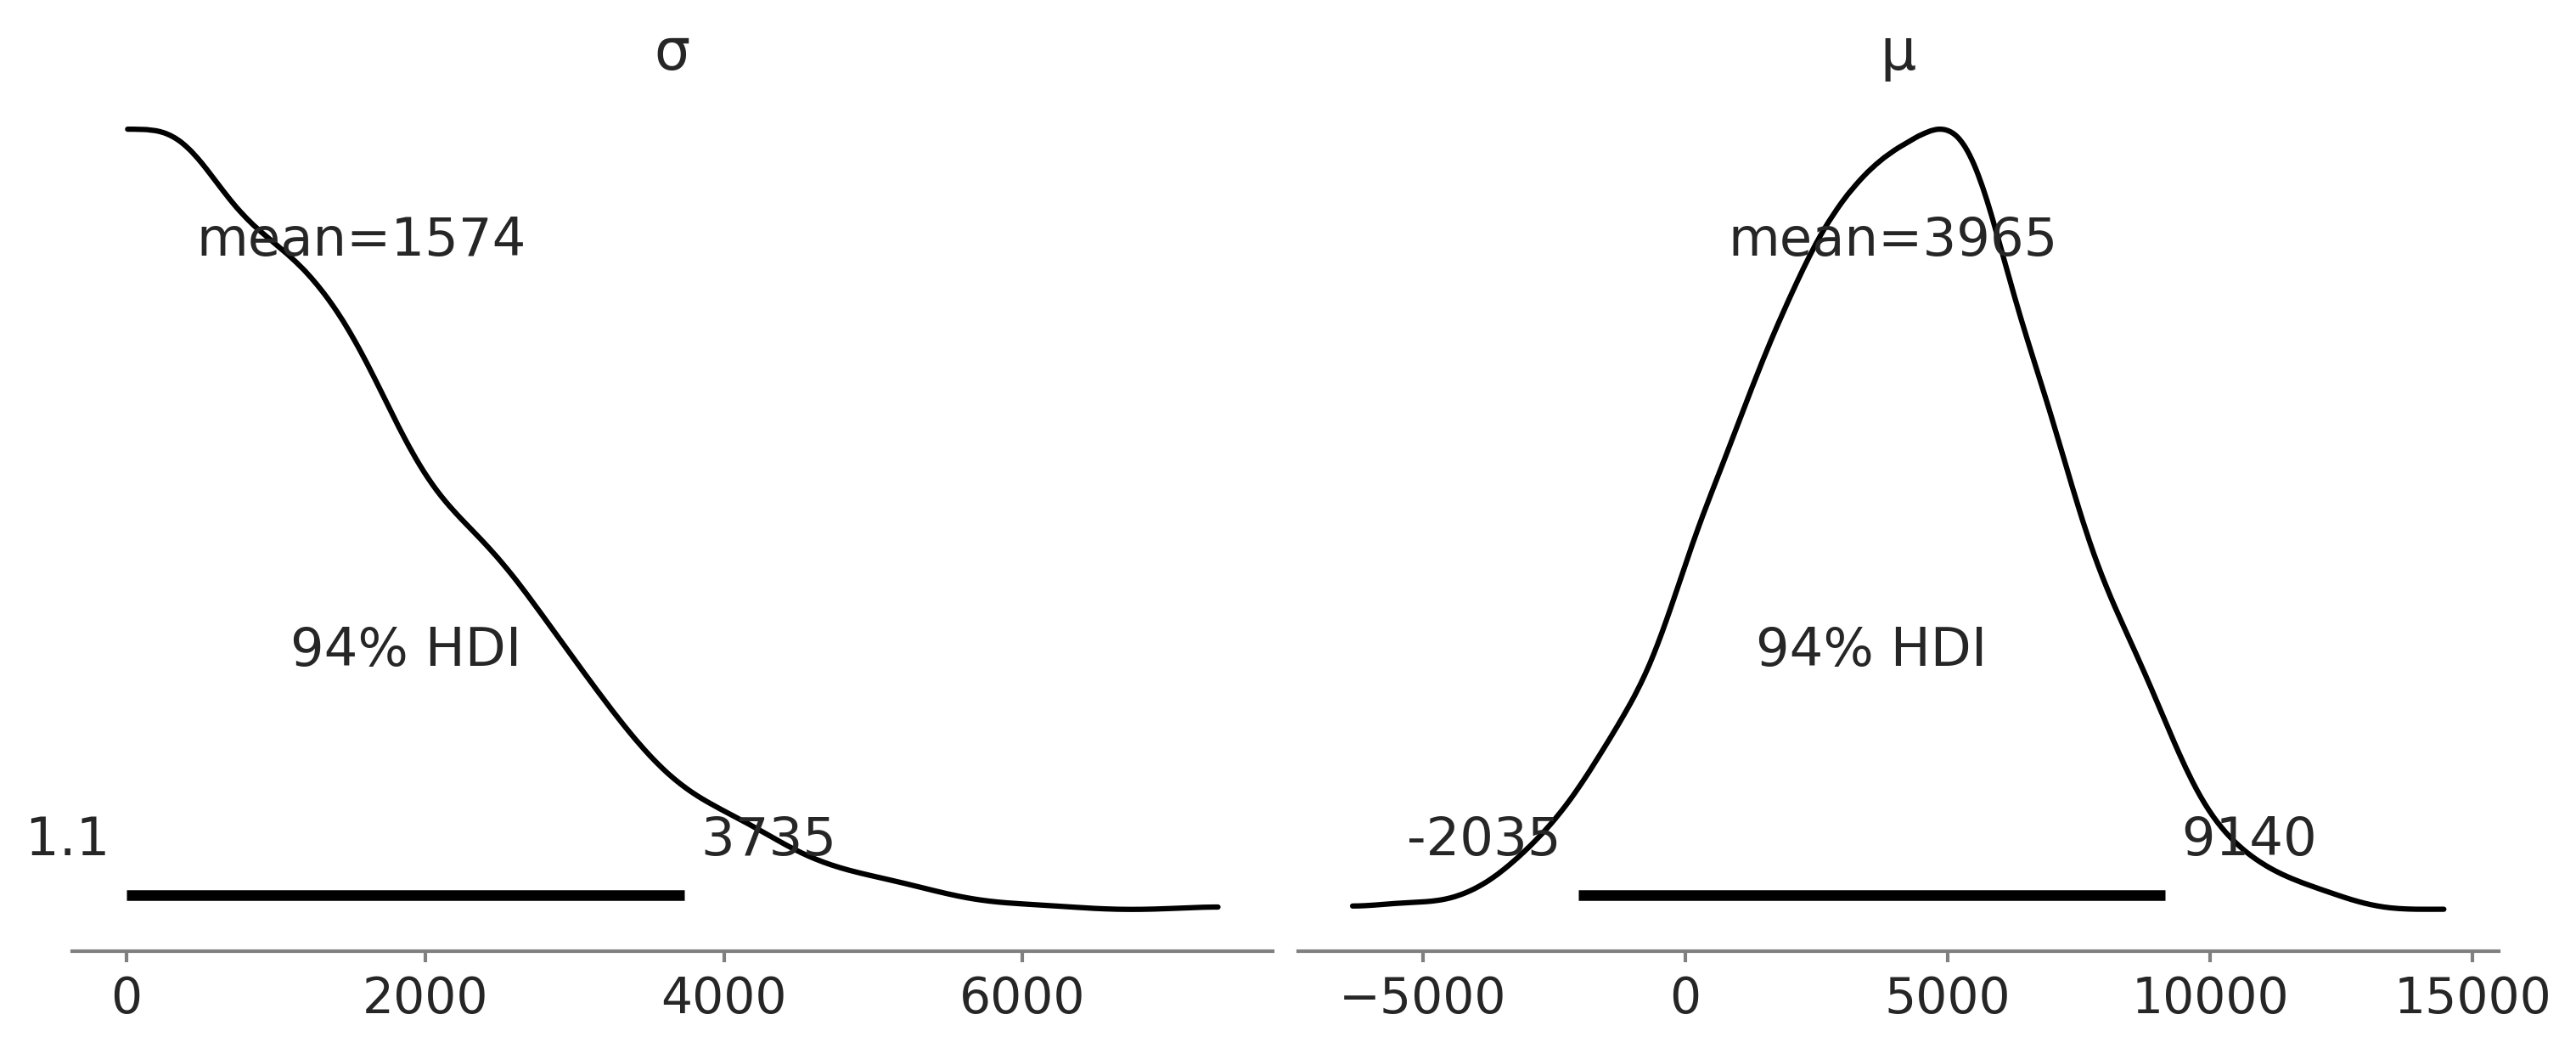

In [7]:
axes = az.plot_posterior(idata_adelie_mass.prior, var_names=["σ", "μ"], figsize=(10, 4))

plt.savefig("img/chp03/single_species_prior_predictive.png")

### Figure 3.2

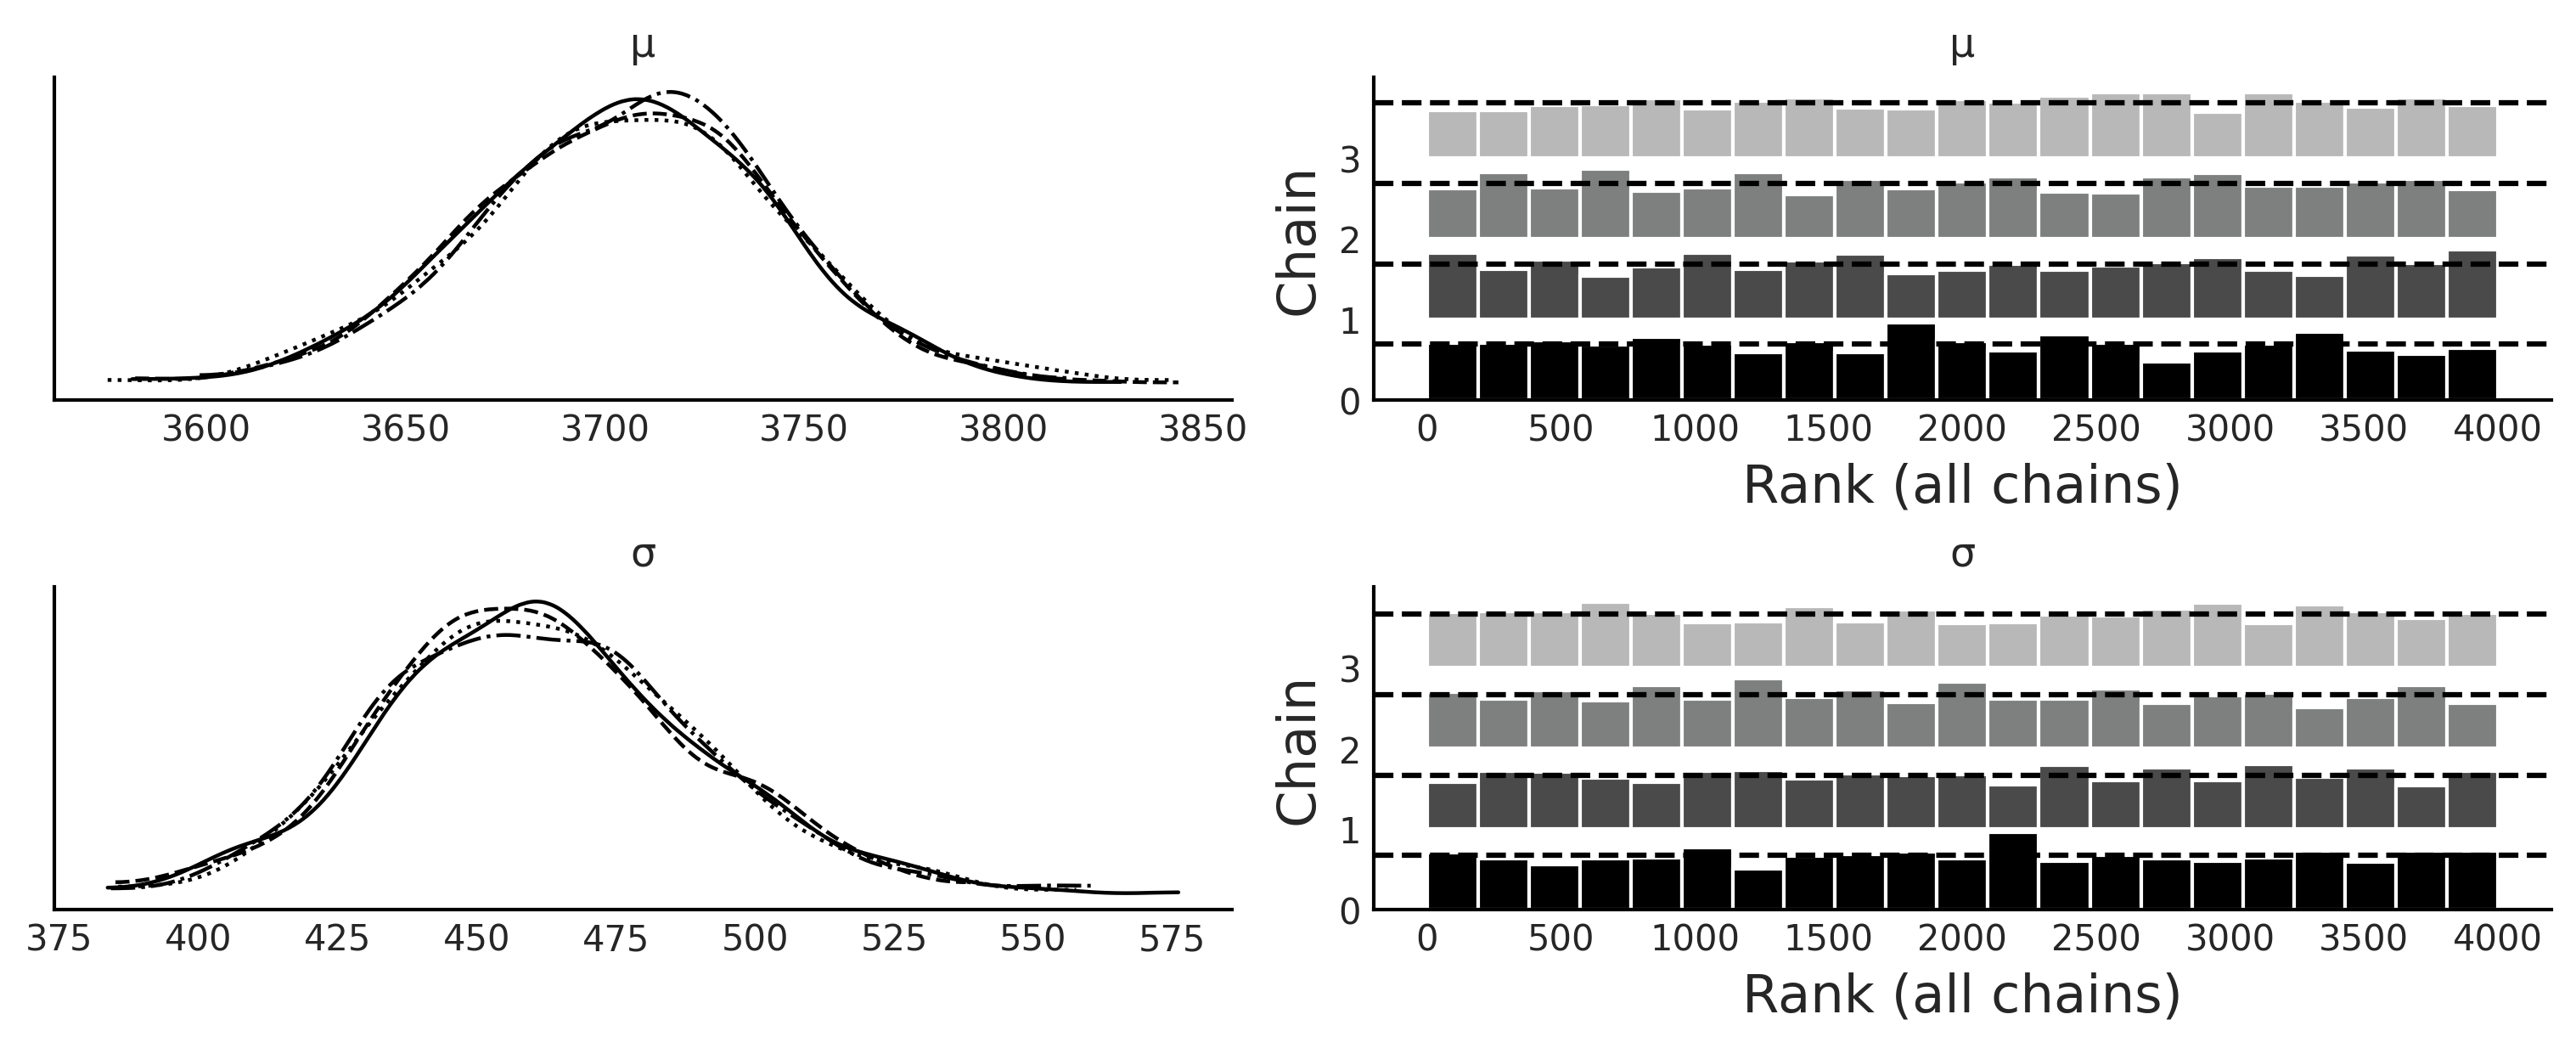

In [8]:
axes = az.plot_trace(idata_adelie_mass, divergences="bottom", kind="rank_bars", figsize=(10, 4))

plt.savefig("img/chp03/single_species_KDE_rankplot.png")

### Table 3.2

In [9]:
az.summary(idata_adelie_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3706.002  38.135  3633.333  3776.853      0.590    0.417    4170.0   
σ   461.744  28.026   412.091   517.831      0.465    0.330    3669.0   

   ess_tail  r_hat  
μ    3211.0    1.0  
σ    2828.0    1.0

In [10]:
#print(az.summary(idata_adelie_mass).round(1).to_latex())

### Figure 3.3

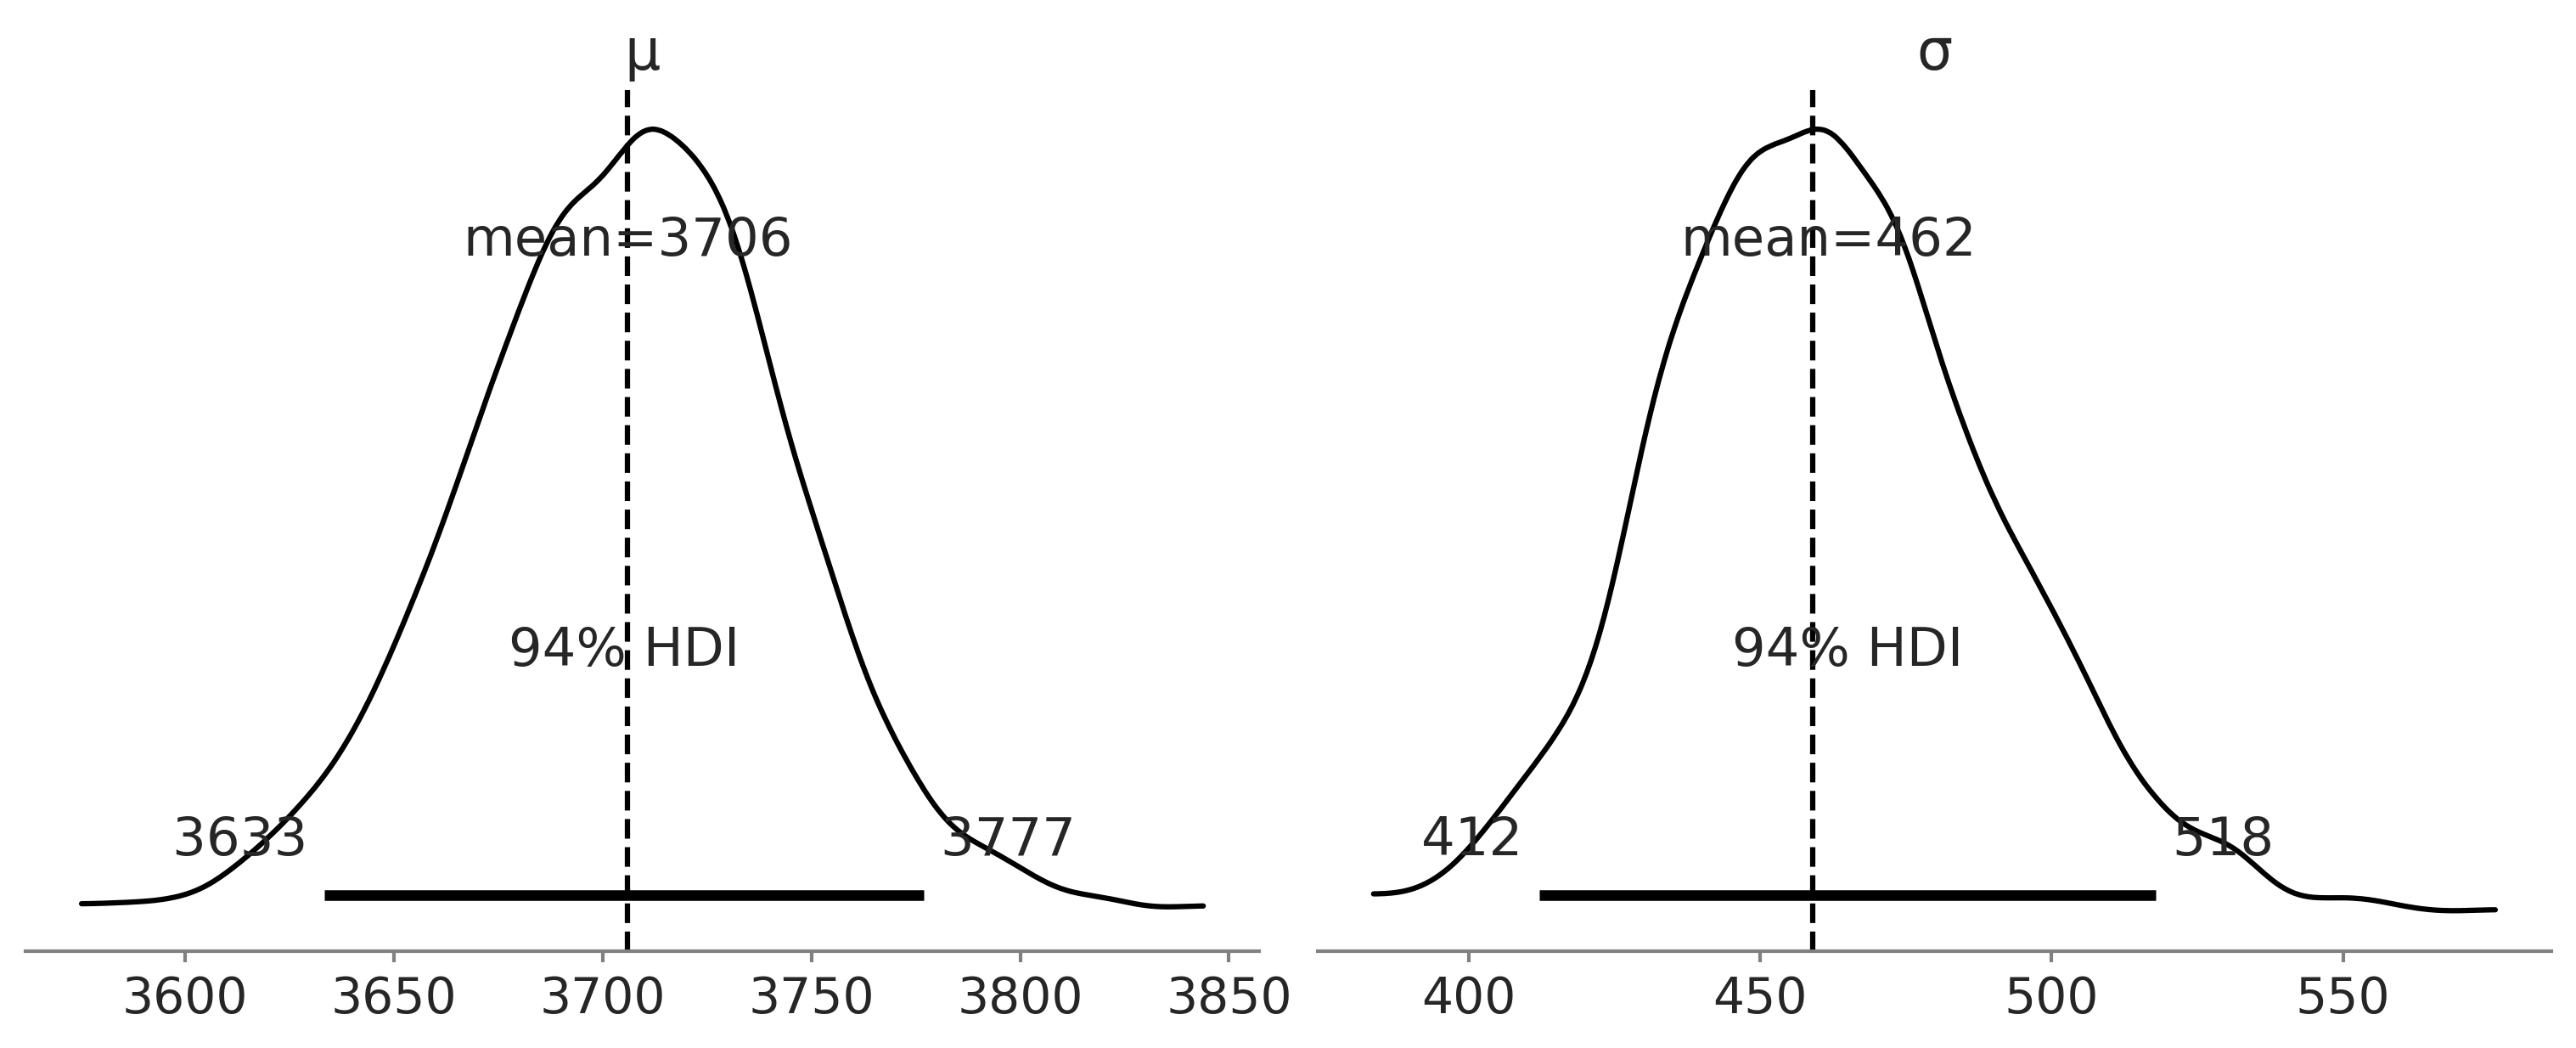

In [11]:
axes = az.plot_posterior(idata_adelie_mass, hdi_prob=.94, figsize=(10, 4));

# Copied from code output 3.2
axes[0].axvline(3706, linestyle="--")
axes[1].axvline(459, linestyle="--")
plt.savefig("img/chp03/single_species_mass_posteriorplot.png")

### Figure 3.4

In [12]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])
coords = {"species": all_species.categories}

with pm.Model(coords=coords) as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, dims="species")
    μ = pm.Normal("μ", 4000, 3000, dims="species")
    mass = pm.Normal("mass",
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    idata_penguin_mass_all_species = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### Figure 3.4

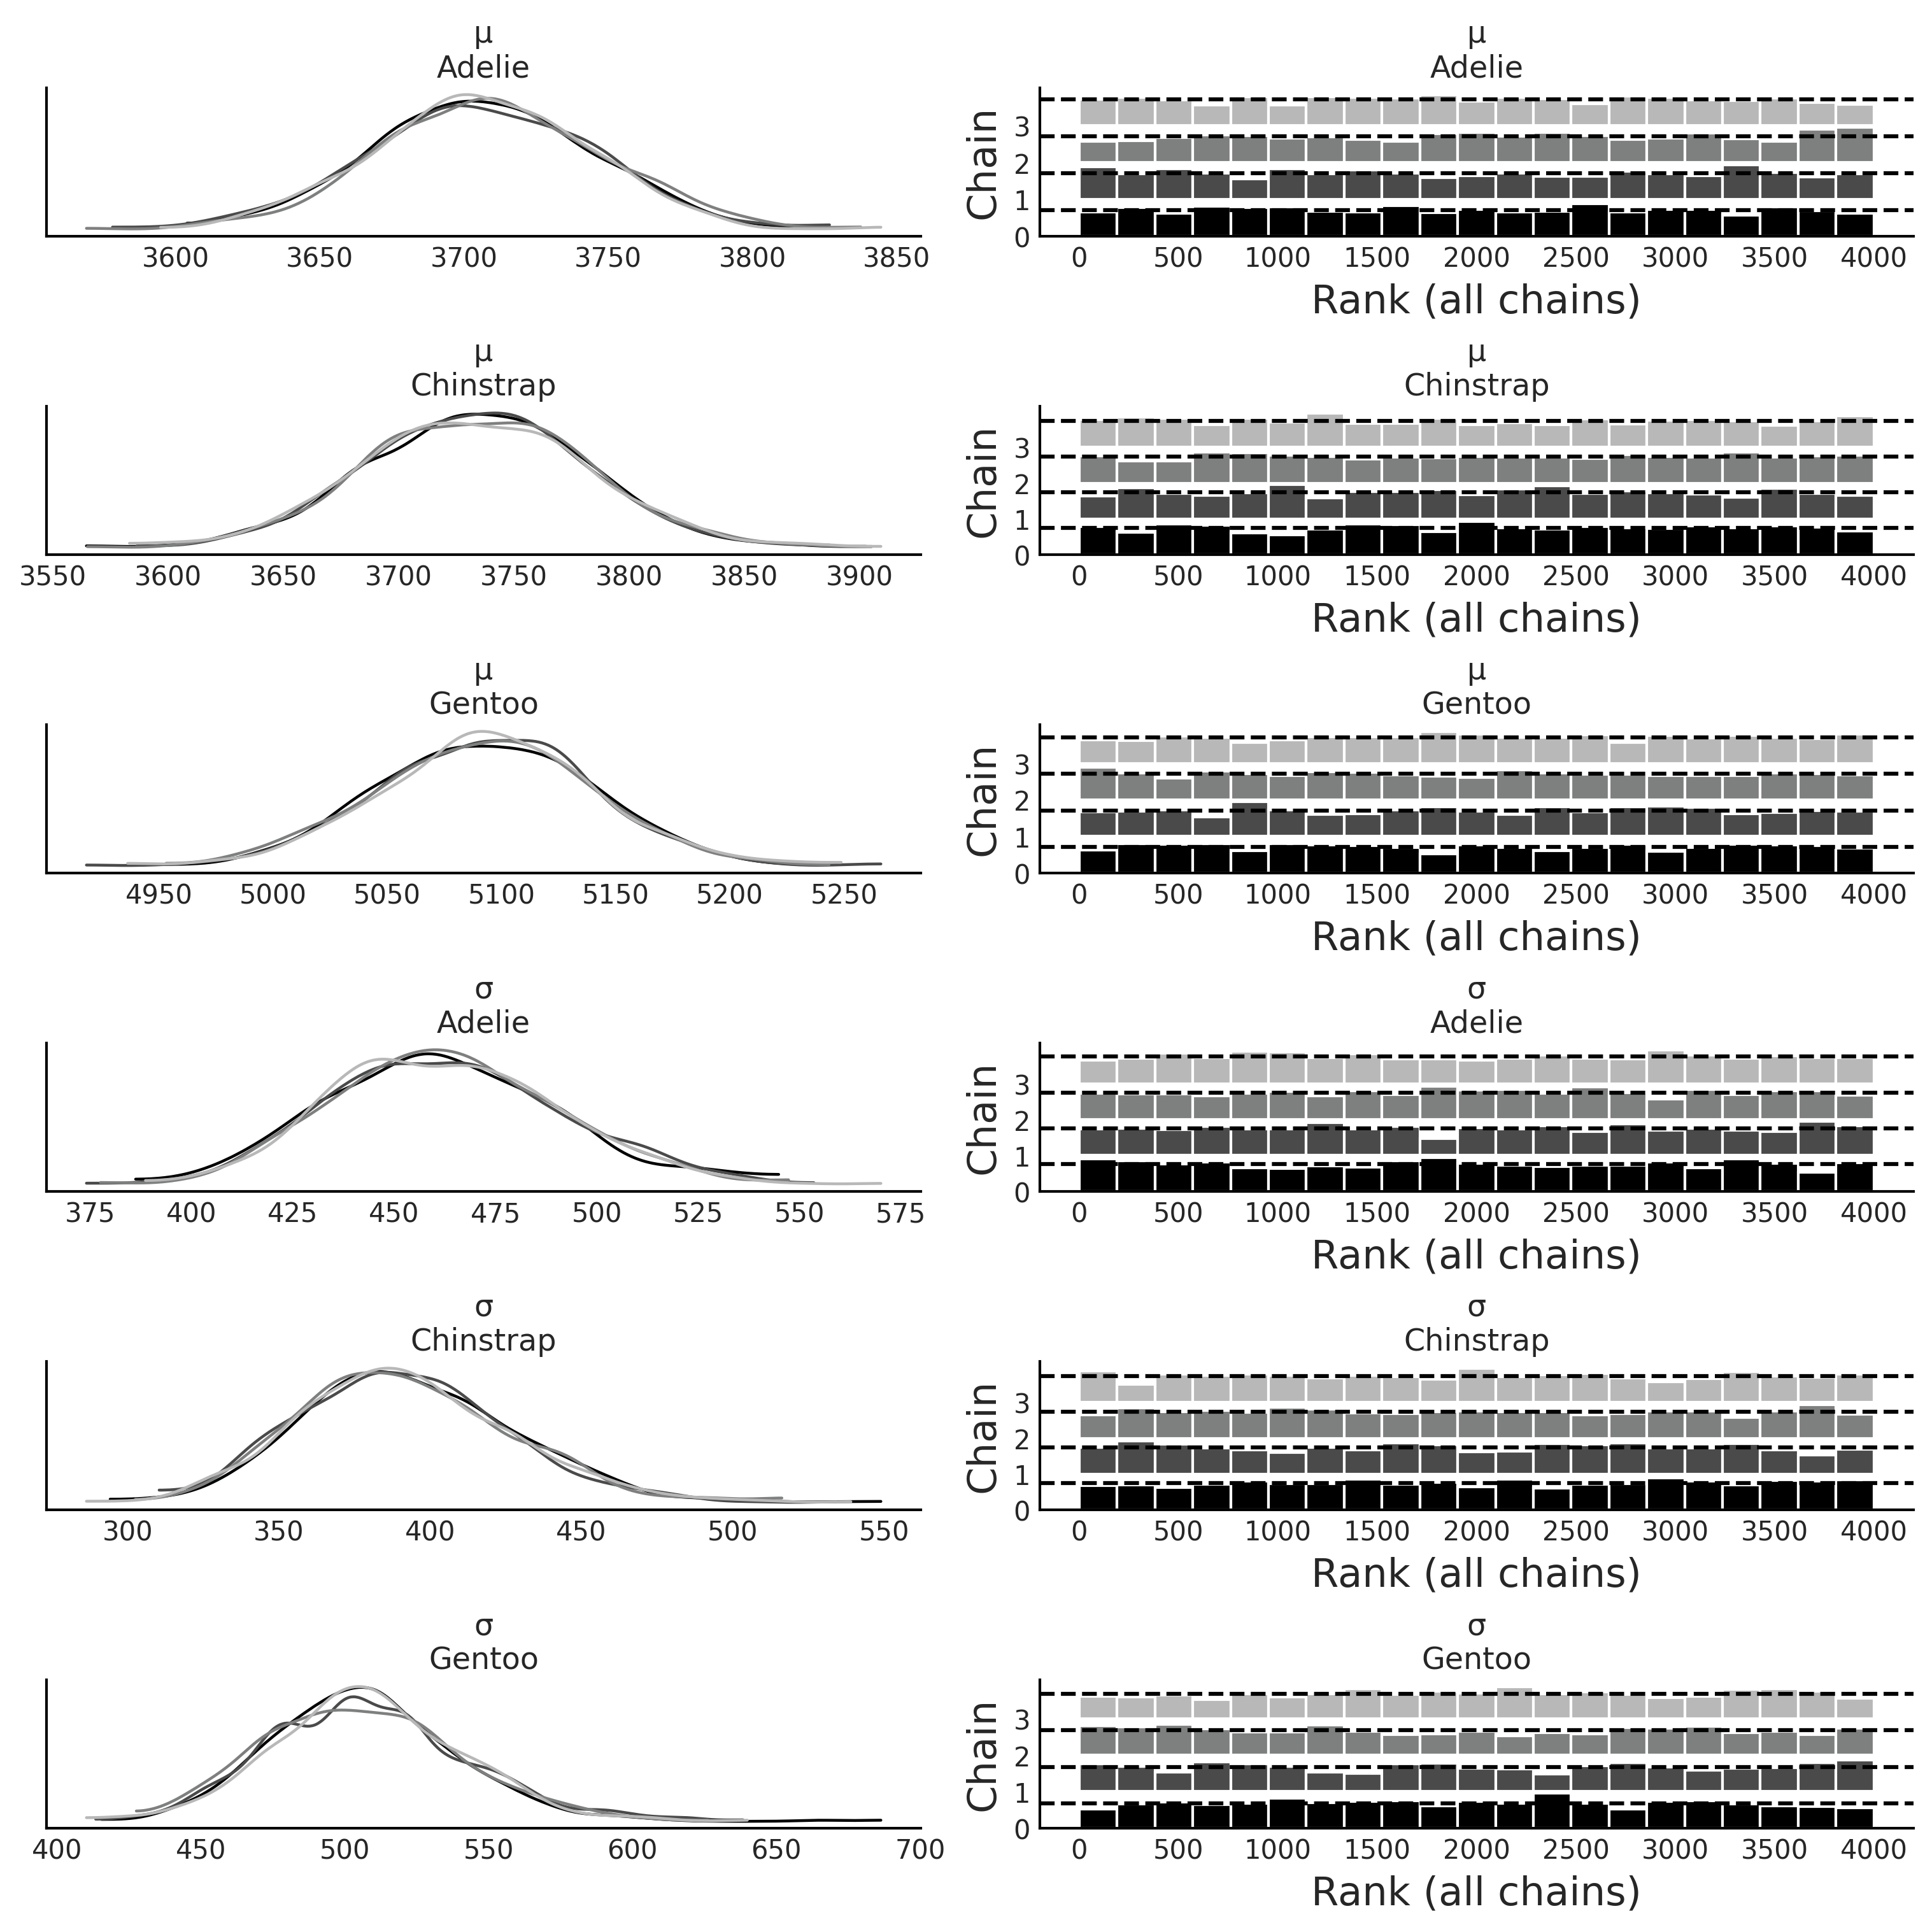

In [13]:
axes = az.plot_trace(idata_penguin_mass_all_species, compact=False,
                     divergences="bottom", kind="rank_bars", figsize=(10, 10));

plt.savefig("img/chp03/all_species_KDE_rankplot.png")

### Code 3.5 and Figure 3.5

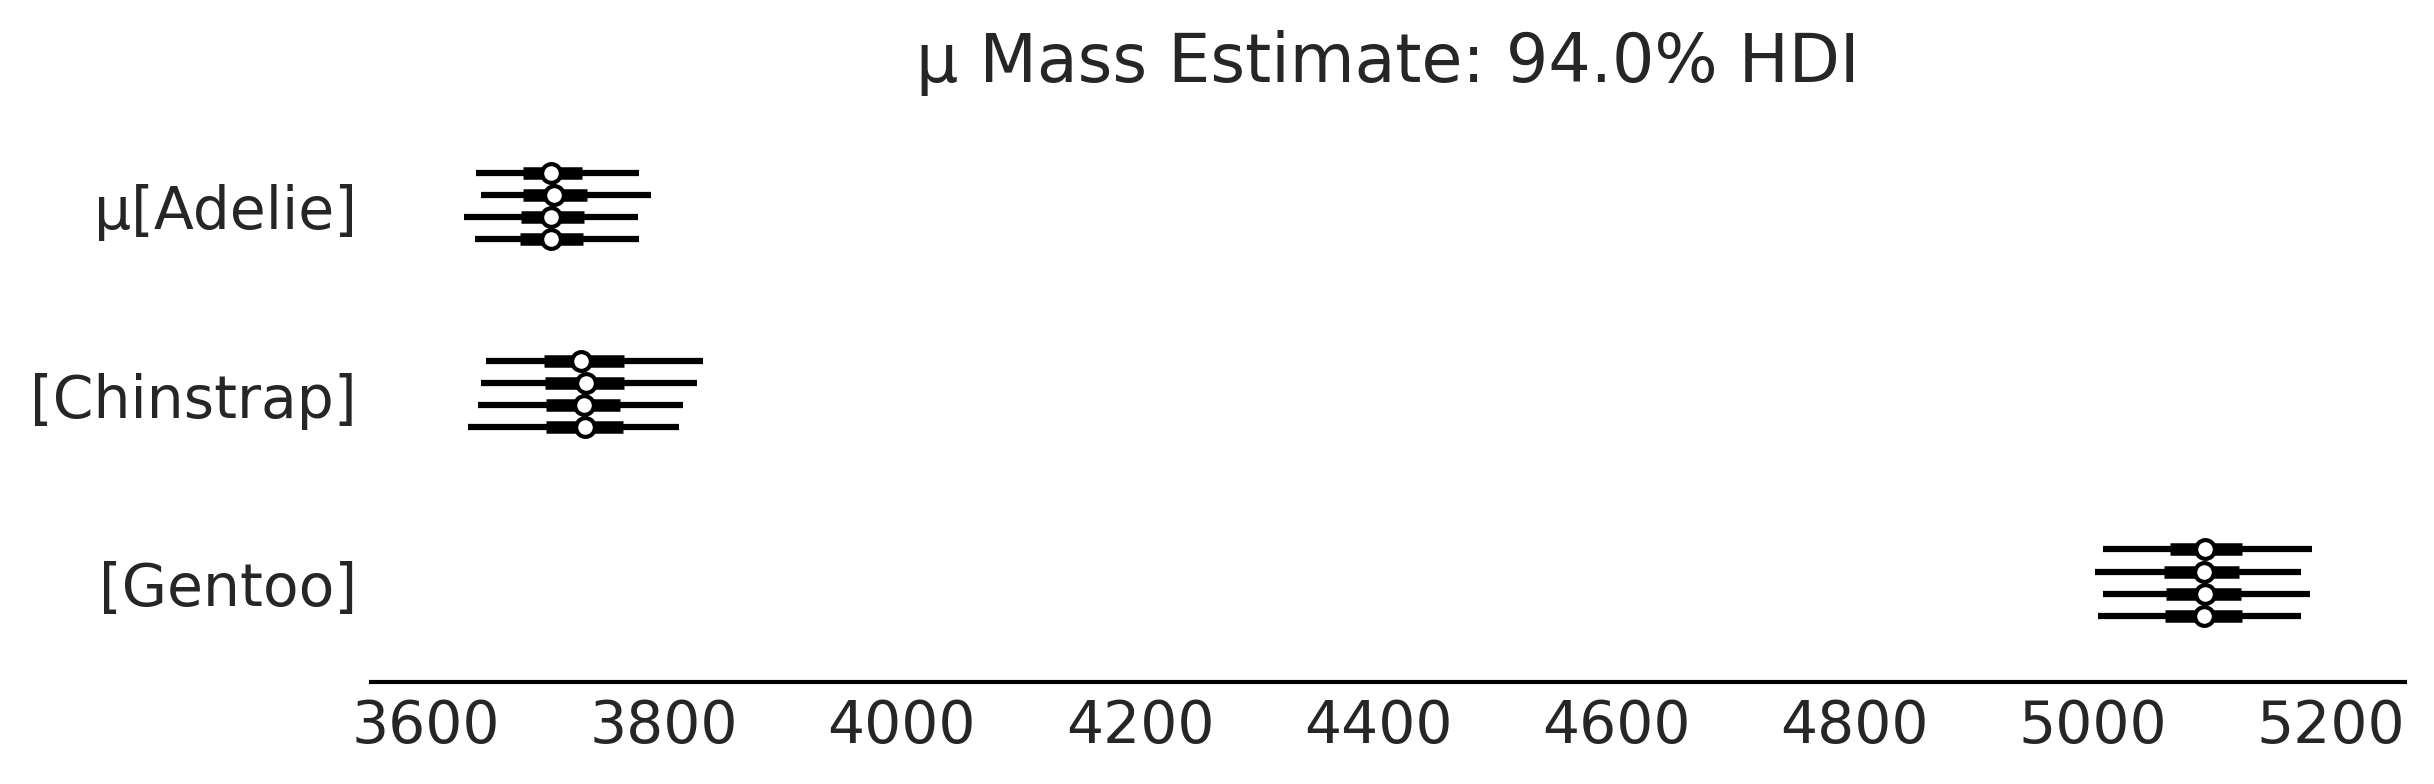

In [14]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotmeans.png")

### Code 3.6 and Figure 3.6

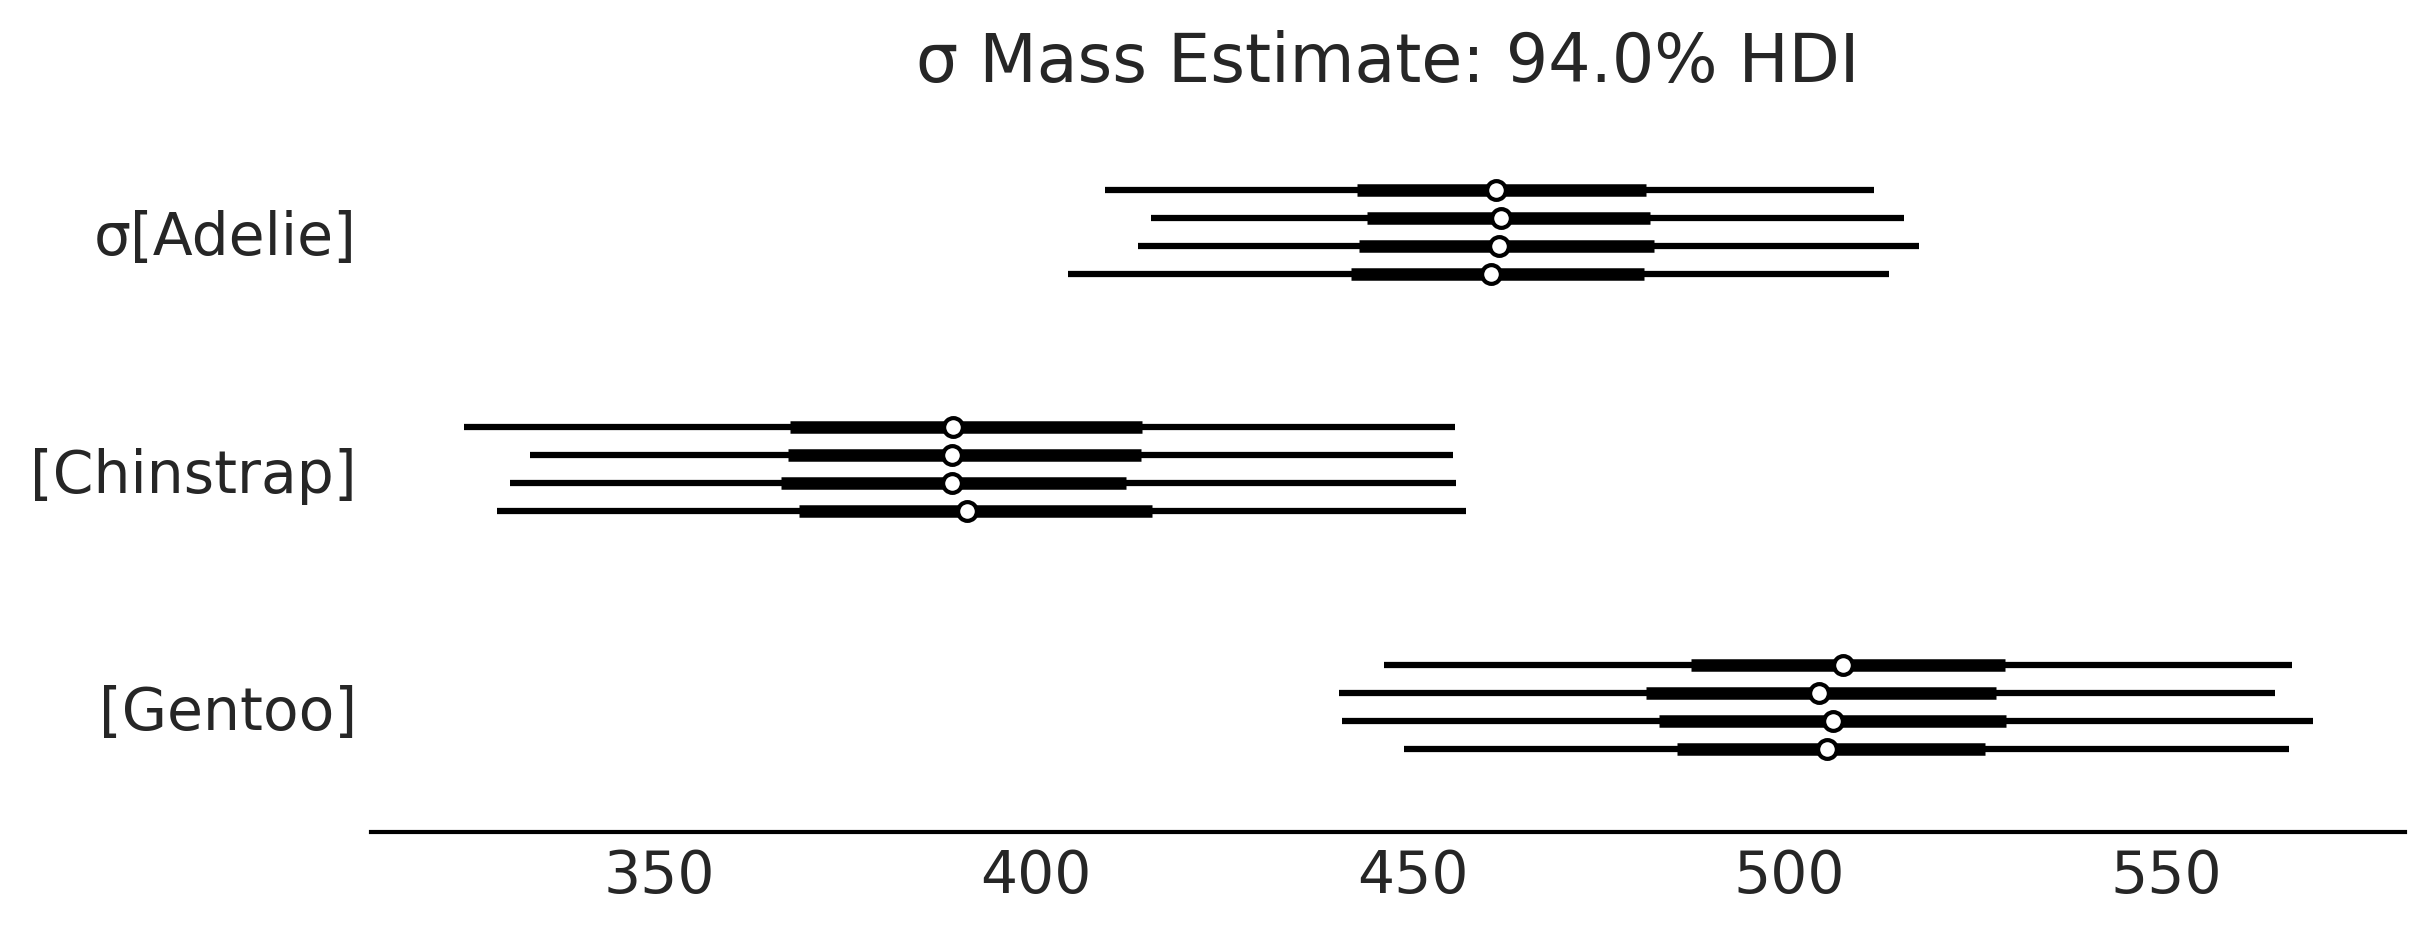

In [15]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["σ"], figsize=(8, 3));
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotsigma.png")

### Code 3.7

In [16]:
# import tensorflow as tf
# import tensorflow_probability as tfp

# tfd = tfp.distributions
# root = tfd.JointDistributionCoroutine.Root

# species_idx = tf.constant(all_species.codes, tf.int32)
# body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

# @tfd.JointDistributionCoroutine
# def jd_penguin_mass_all_species():
#     σ = yield root(tfd.Sample(
#             tfd.HalfStudentT(df=100, loc=0, scale=2000),
#             sample_shape=3,
#             name="sigma"))
#     μ = yield root(tfd.Sample(
#             tfd.Normal(loc=4000, scale=3000),
#             sample_shape=3,
#             name="mu"))
#     mass = yield tfd.Independent(
#         tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
#                    scale=tf.gather(σ, species_idx, axis=-1)),
#         reinterpreted_batch_ndims=1,
#         name="mass")

### Code 3.8

In [17]:
# prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

### Code 3.9

In [18]:
# jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
# jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]))

### Code 3.10

In [19]:
# target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
#     *x, mass=body_mass_g)

# jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
#     mass=body_mass_g)
# target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

# # init_state = jd_penguin_mass_observed.sample_unpinned(10)
# # target_density_function1(*init_state), target_density_function2(*init_state)

### Code 3.11

In [20]:
# run_mcmc = tf.function(
#     tfp.experimental.mcmc.windowed_adaptive_nuts,
#     autograph=False, jit_compile=True)
# mcmc_samples, sampler_stats = run_mcmc(
#     1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=1000,
#     mass=body_mass_g)

# idata_penguin_mass_all_species2 = az.from_dict(
#     posterior={
#         # TFP mcmc returns (num_samples, num_chains, ...), we swap
#         # the first and second axis below for each RV so the shape
#         # is what ArviZ expected.
#         k:np.swapaxes(v, 1, 0)
#         for k, v in mcmc_samples._asdict().items()},
#     sample_stats={
#         k:np.swapaxes(sampler_stats[k], 1, 0)
#         for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
# )

In [21]:
# az.plot_trace(idata_penguin_mass_all_species2, divergences="bottom", kind="rank_bars", figsize=(6,4));

### Code 3.12

In [22]:
# prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
# dist, samples = jd_penguin_mass_all_species.sample_distributions(
#     value=mcmc_samples)
# ppc_samples = samples[-1]
# ppc_distribution = dist[-1].distribution
# data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# # Be careful not to run this code twice during REPL workflow.
# idata_penguin_mass_all_species2.add_groups(
#     prior=prior_predictive_samples[:-1]._asdict(),
#     prior_predictive={"mass": prior_predictive_samples[-1]},
#     posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
#     log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
#     observed_data={"mass": body_mass_g}
# )

In [23]:
# az.plot_ppc(idata_penguin_mass_all_species2)

In [24]:
# az.loo(idata_penguin_mass_all_species2)

## Linear Regression

### Figure 3.7

/tmp/ipykernel_21205/2386653877.py:38: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)


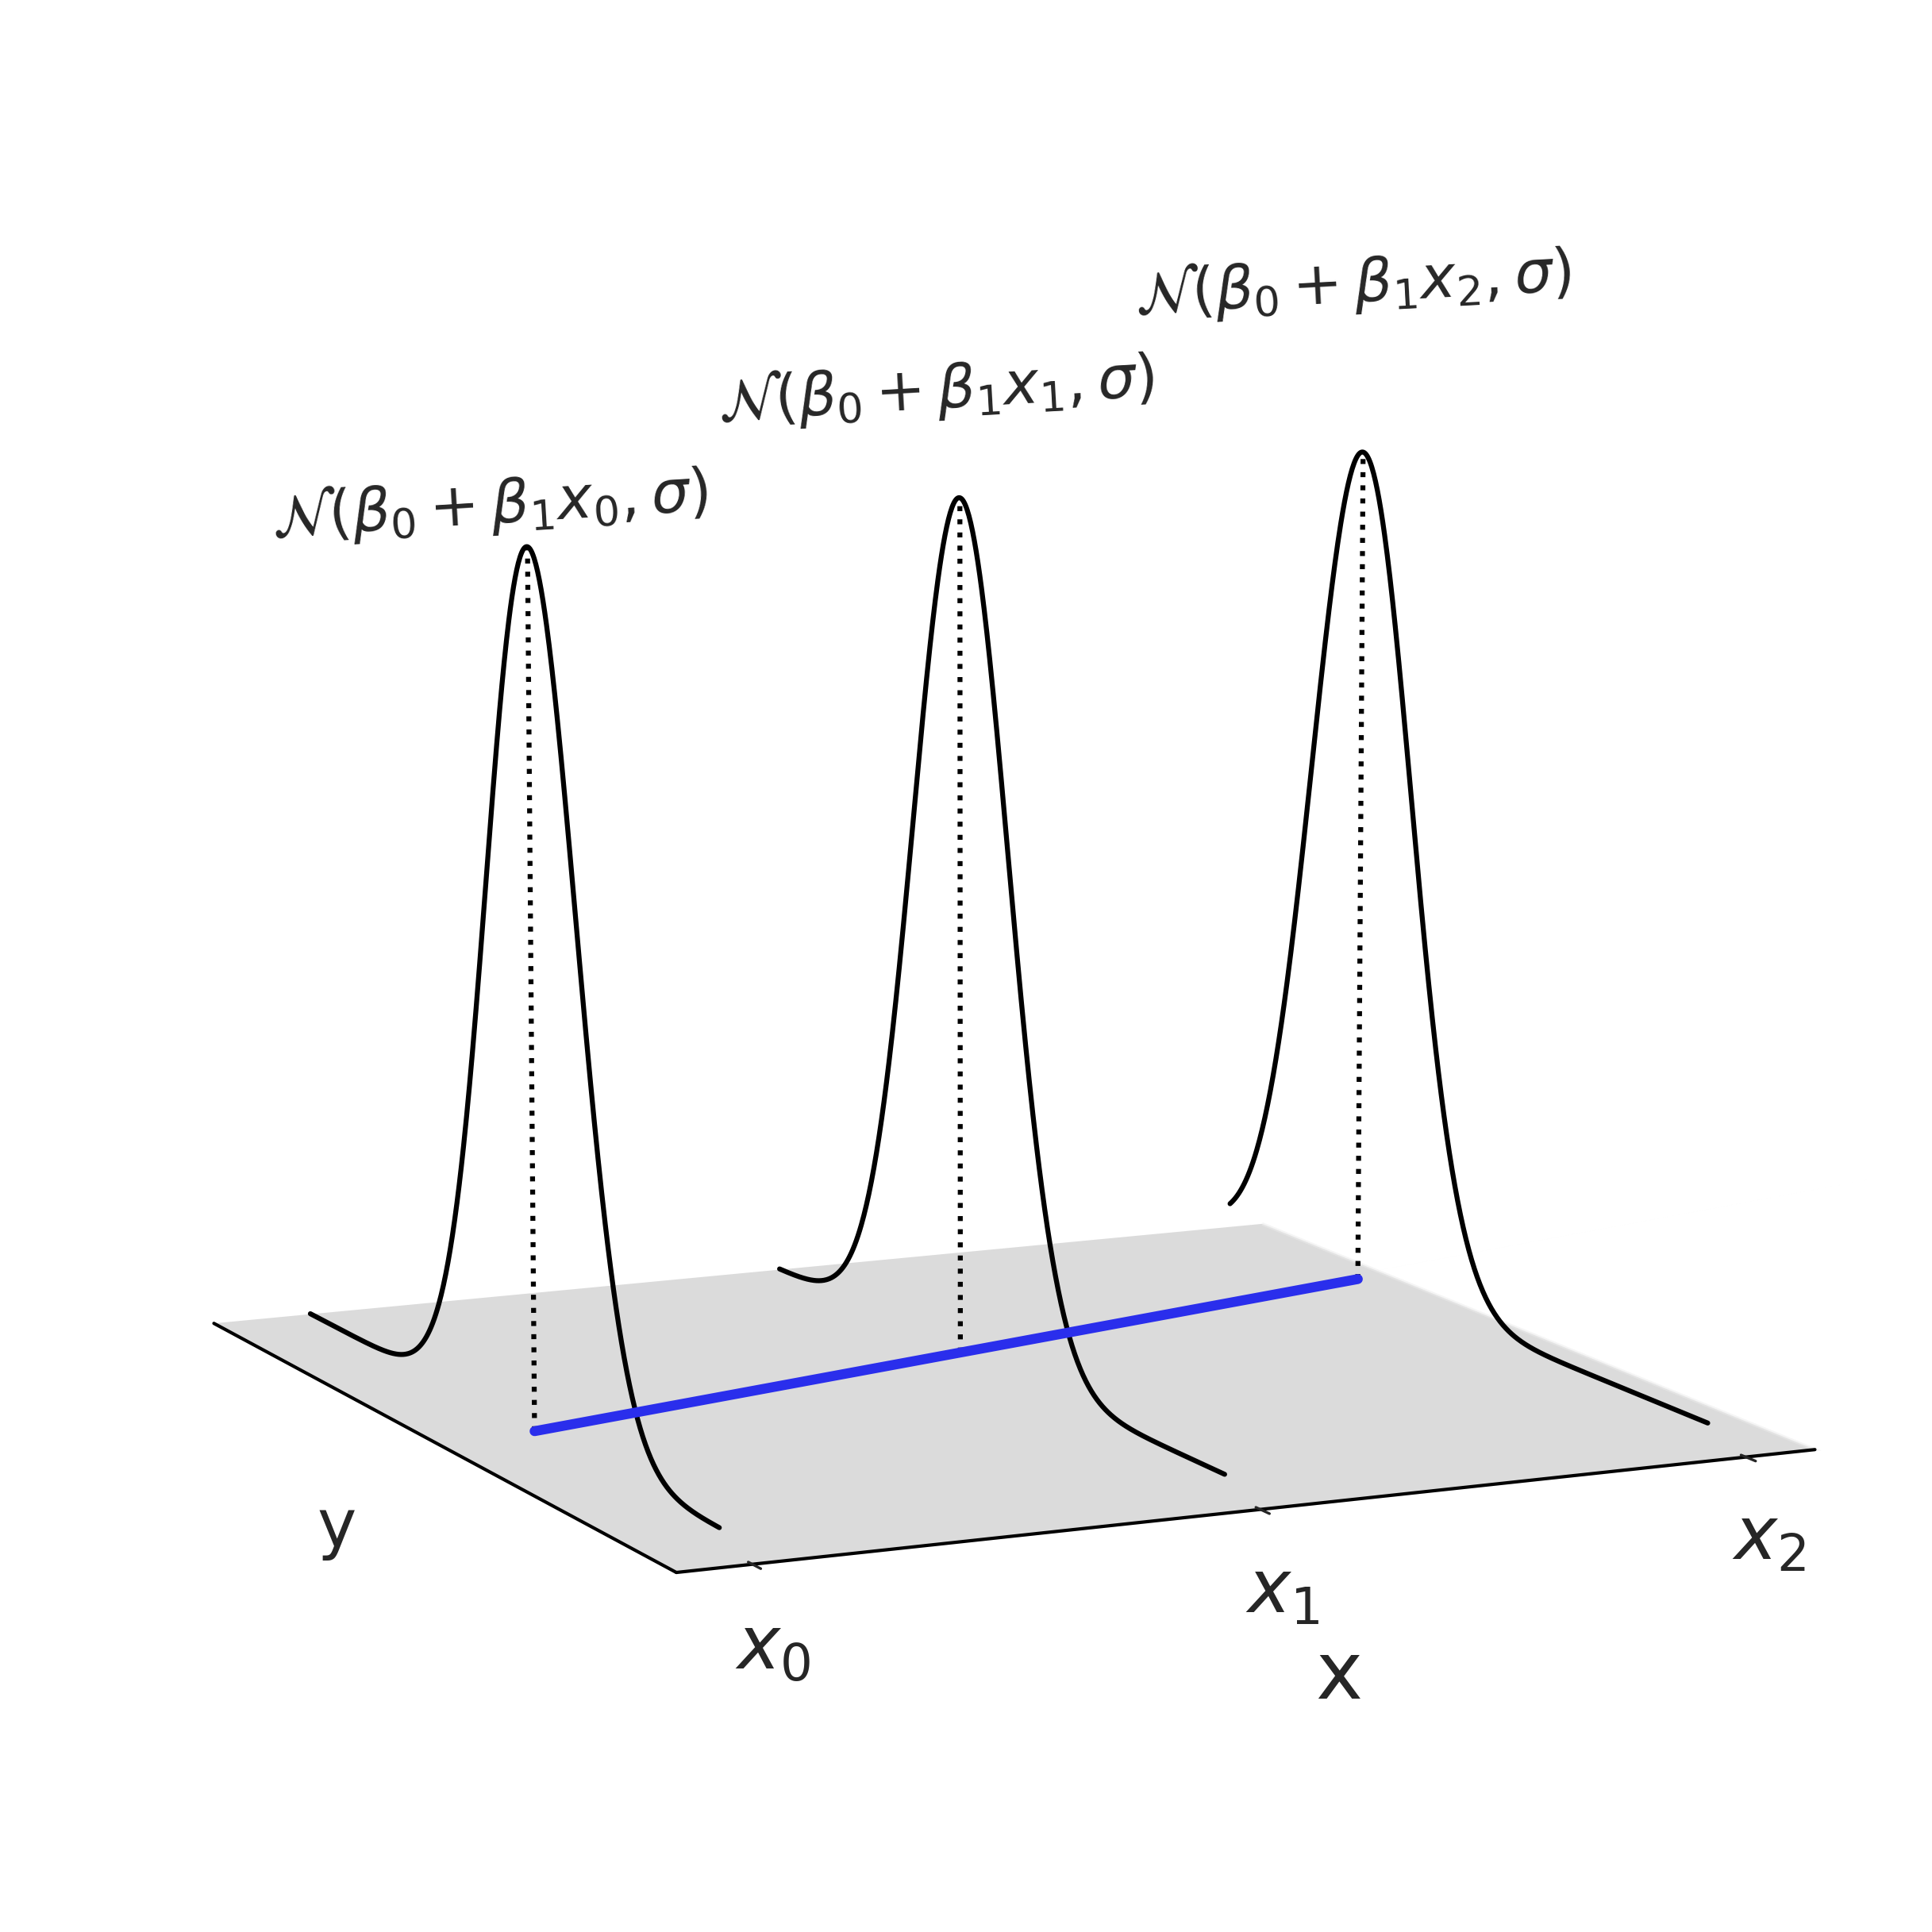

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

x = np.linspace(-16, 12, 500)
z = np.array([0, 4, 8])

for i, zi in enumerate(z):
    dens = stats.norm(-zi, 3).pdf(x)
    ax.plot(x, dens, zs=zi + 1, zdir="y", c="k")
    ax.plot([-zi, -zi], [0, max(dens)], zs=zi + 1, c="k", ls=":", zdir="y")
    ax.text(
        -zi,
        zi - 1,
        max(dens) * 1.03 + i / 100,
        f"$\\mathcal{{N}}(\\beta_0 + \\beta_1 x_{i}, \\sigma)$",
        zdir="y",
        fontsize=18,
    )

ax.plot(-z, z + 1, "C4-", lw=3)


ax.set_xlabel("y", fontsize=20)
ax.set_ylabel("x", fontsize=24, labelpad=20)

ax.set_yticks([zi + 1 for zi in z])
ax.set_yticklabels([f"$x_{i}$" for i in range(len(z))], fontsize=22)
ax.grid(False)
ax.set_xticks([])
ax.set_zticks([])
ax.yaxis.pane.fill = False
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("None")
ax.yaxis.pane.set_edgecolor("None")
ax.zaxis.pane.set_facecolor("C3")
ax.zaxis.line.set_linewidth(0)
ax.view_init(elev=10, azim=-25)
plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)

### Code 3.13

In [26]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.MutableData("adelie_flipper_length", adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_regression = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


### Figure 3.8

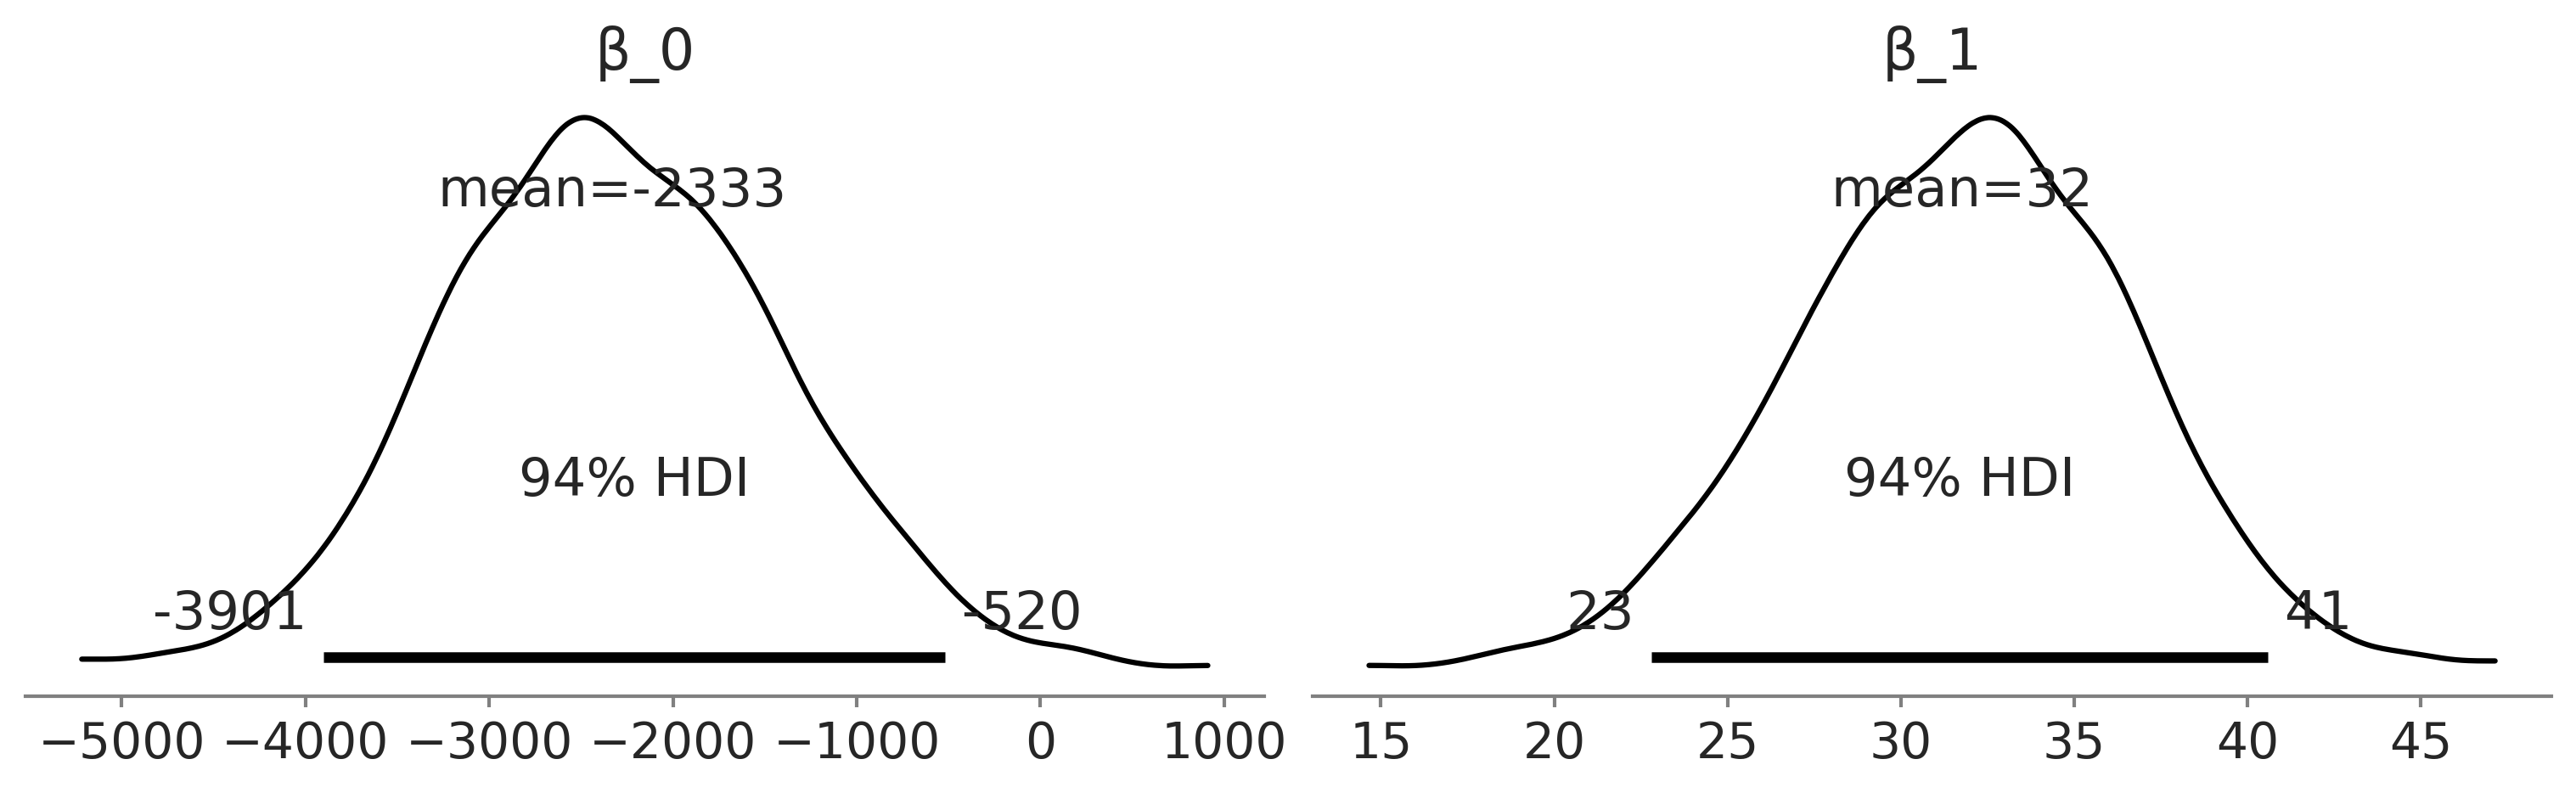

In [27]:
axes = az.plot_posterior(idata_adelie_flipper_regression, var_names = ["β_0", "β_1"], figsize=(10, 3));

plt.savefig("img/chp03/adelie_coefficient_posterior_plots")

### Figure 3.9

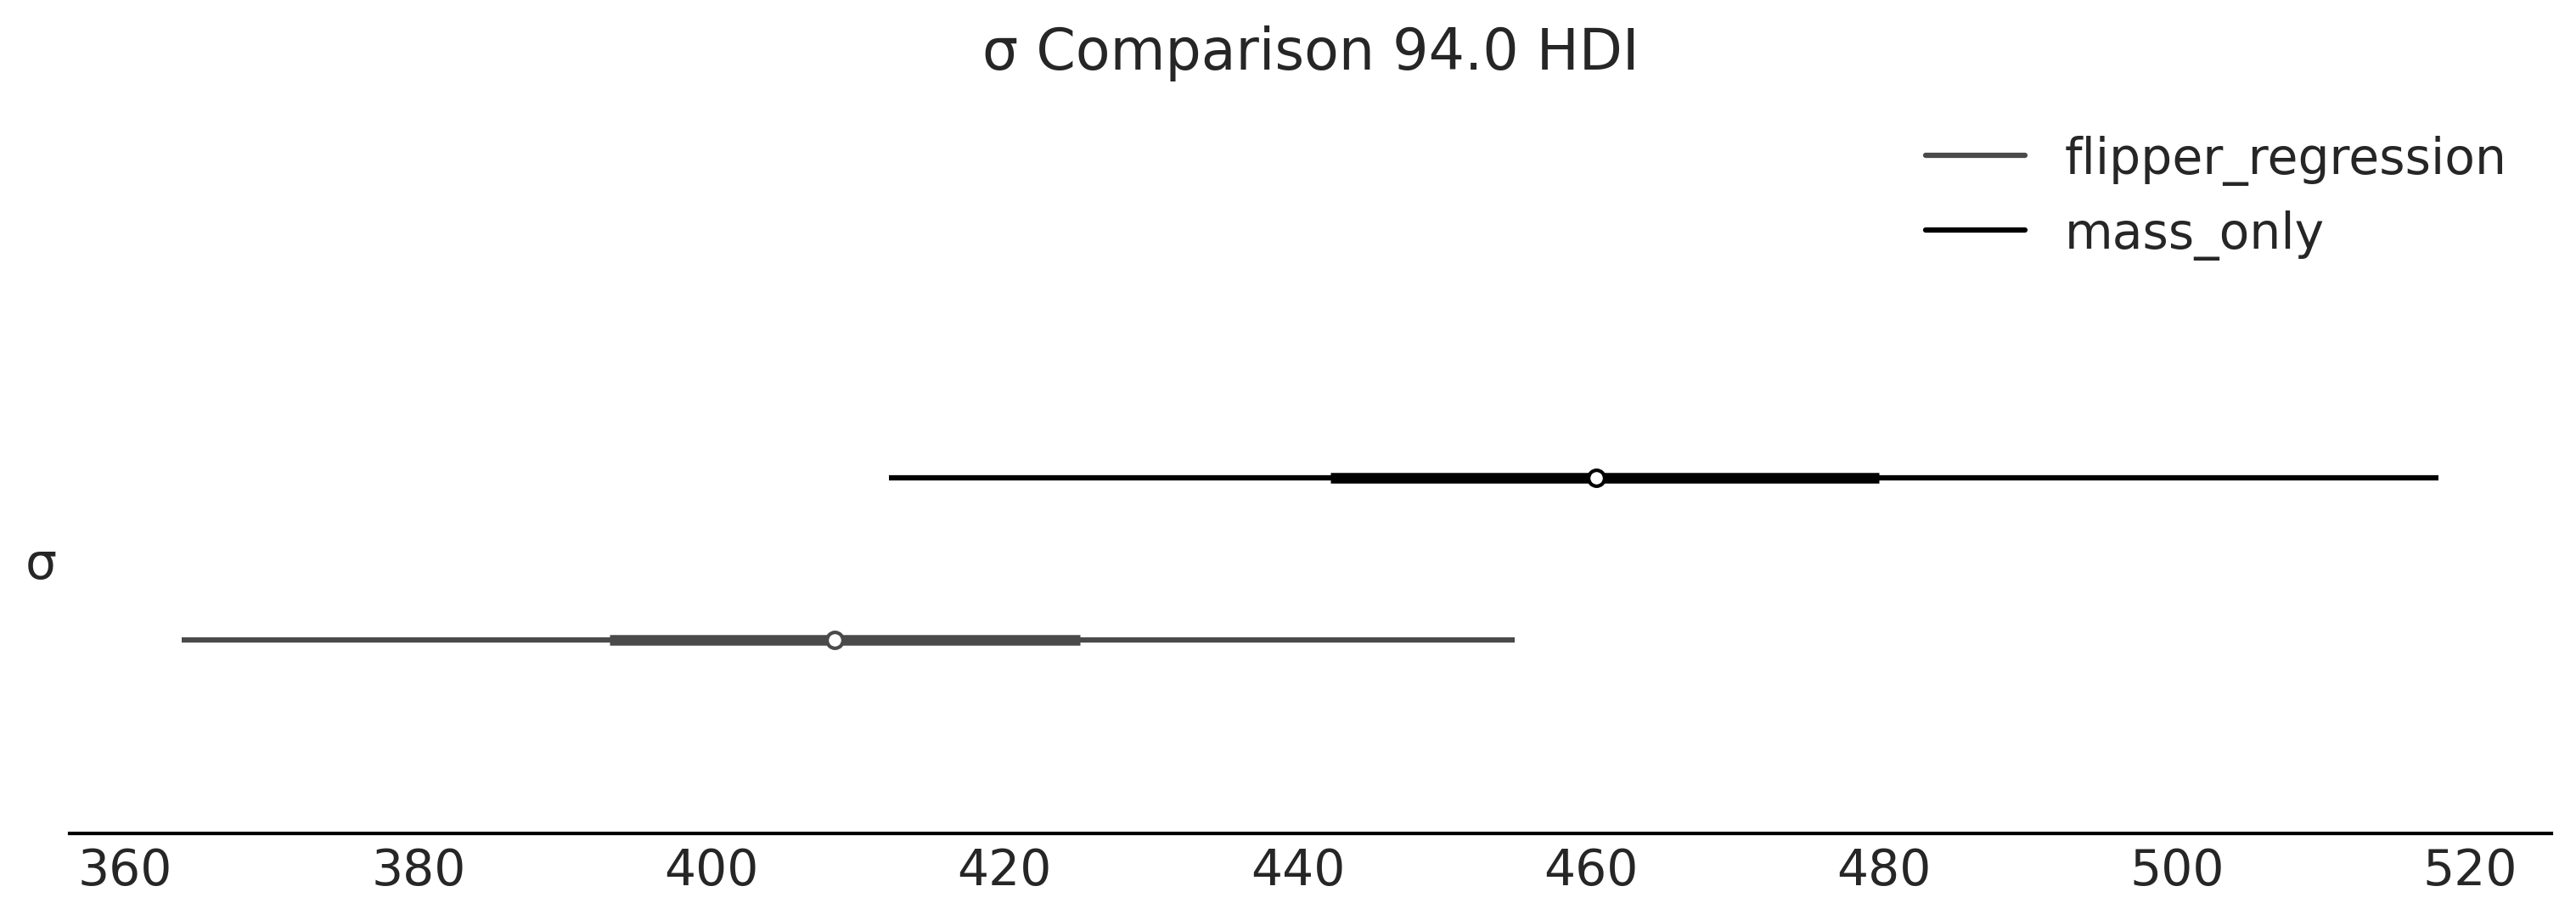

In [28]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"], combined=True, figsize=(10, 3.5))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/SingleSpecies_SingleRegression_Forest_Sigma_Comparison.png")

### Figure 3.10

In [29]:
idata_adelie_flipper_regression.posterior["β_0"].mean().item()

-2332.588031105809

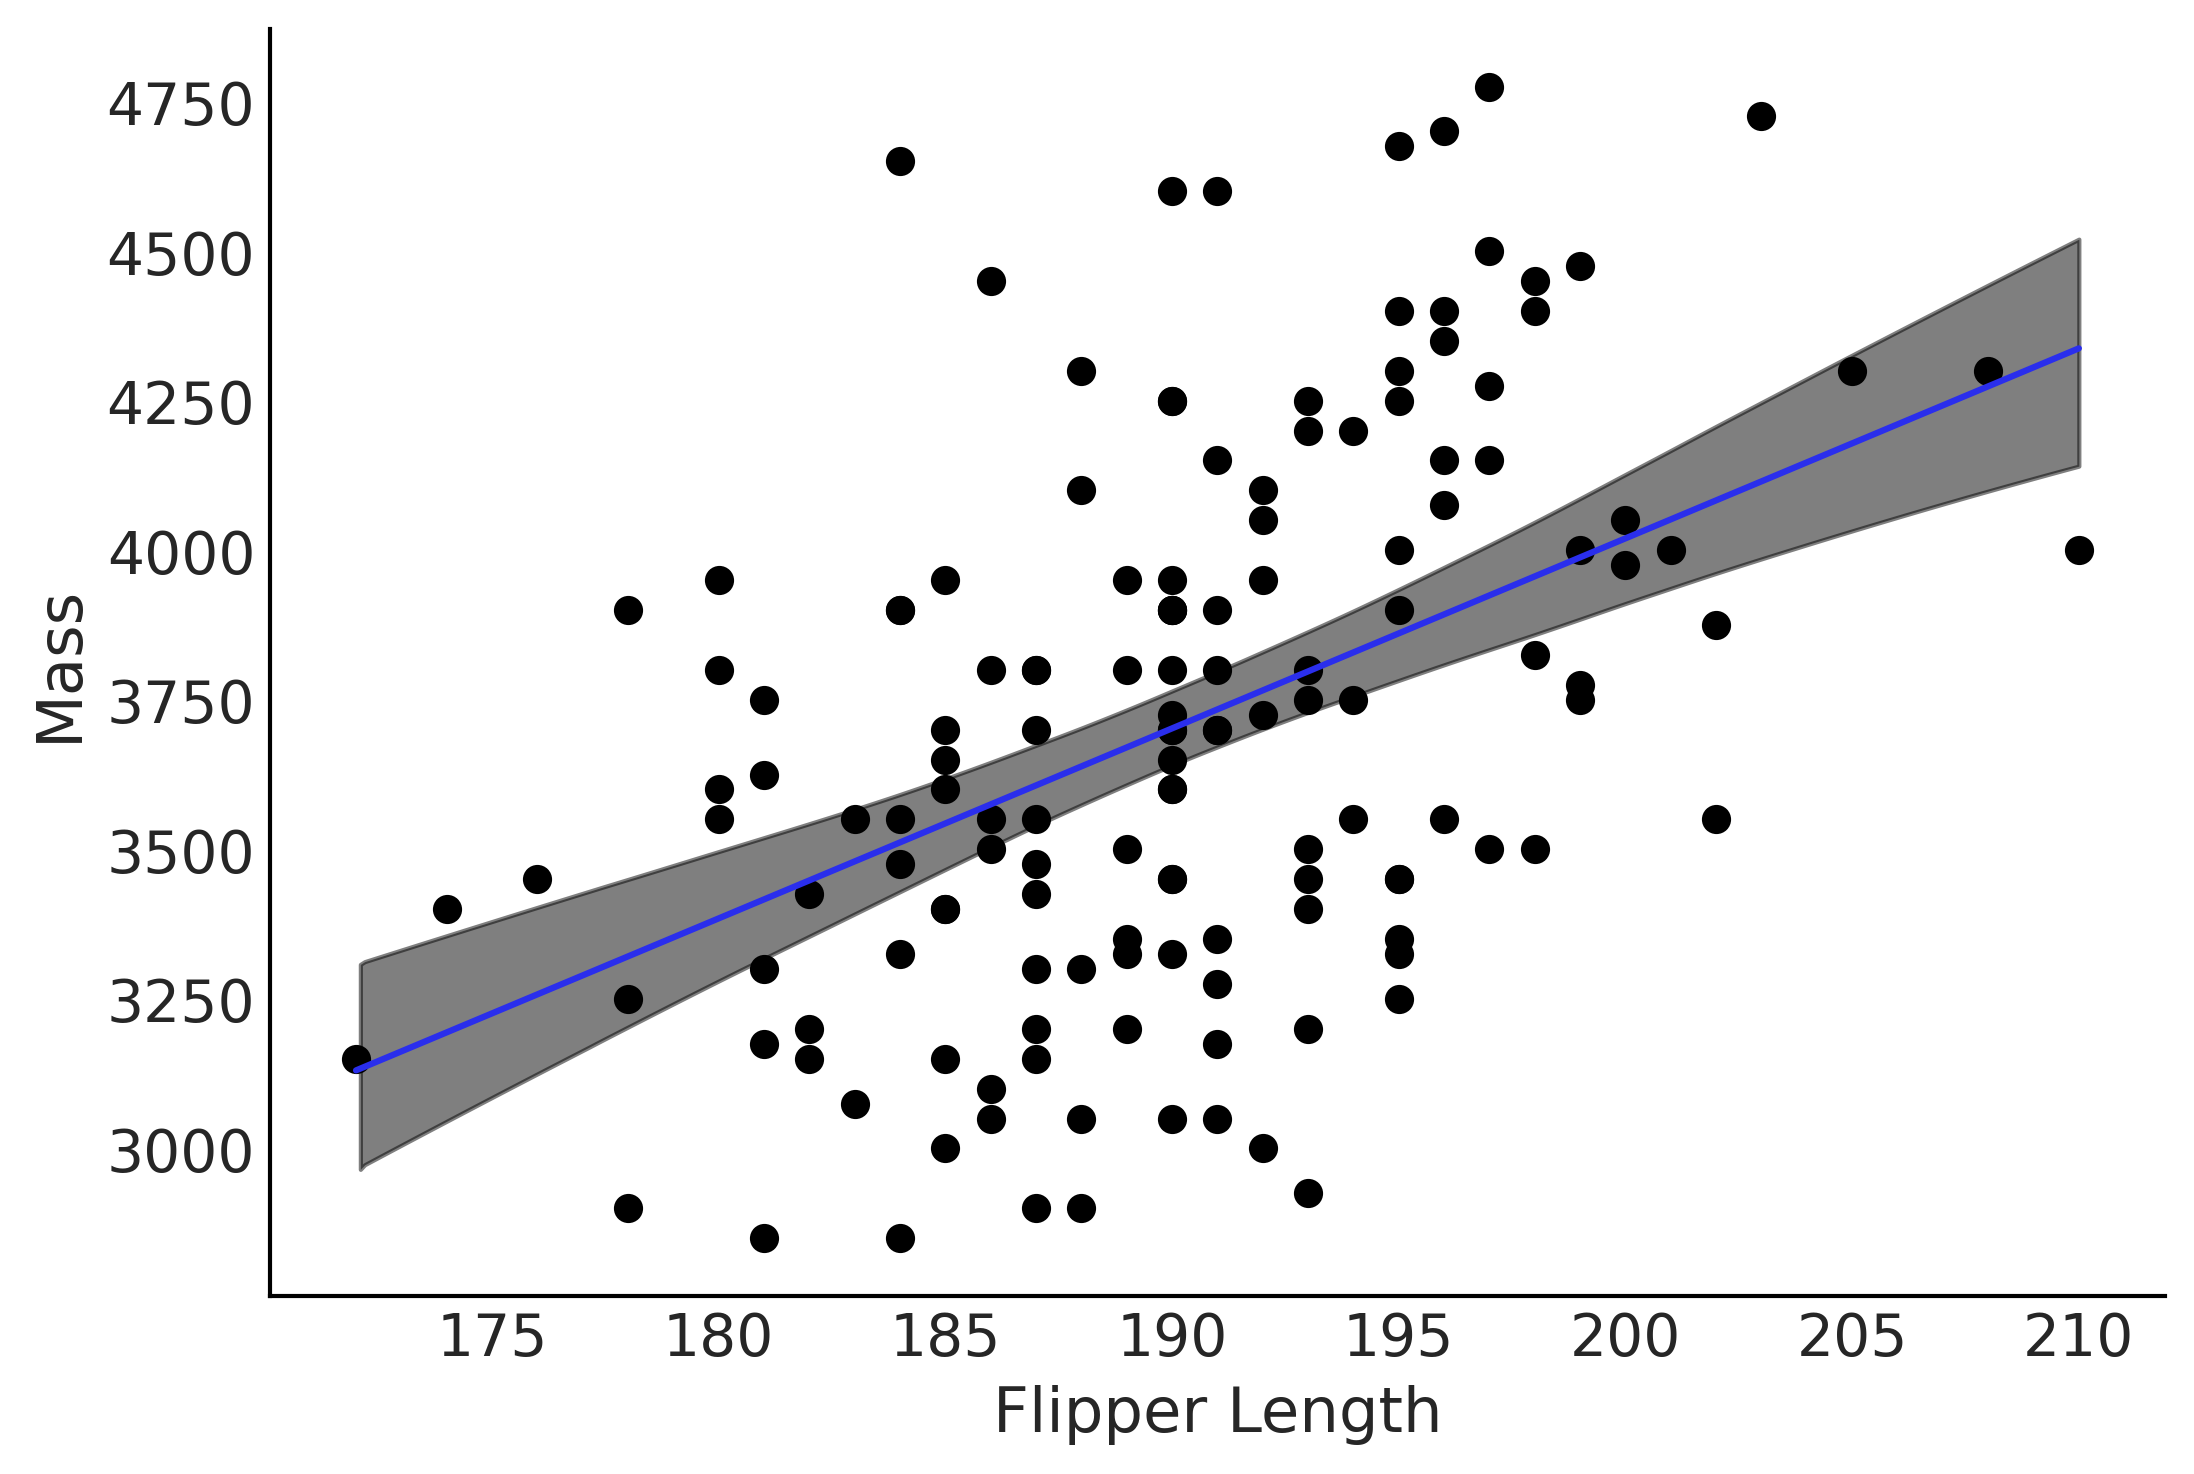

In [30]:
fig, ax = plt.subplots()
alpha_m = idata_adelie_flipper_regression.posterior["β_0"].mean().item()
beta_m = idata_adelie_flipper_regression.posterior["β_1"].mean().item()

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, idata_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
plt.savefig('img/chp03/flipper_length_mass_regression.png', dpi=300)

### Code 3.14

In [31]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        idata_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

Sampling: [mass]


### Figure 3.11

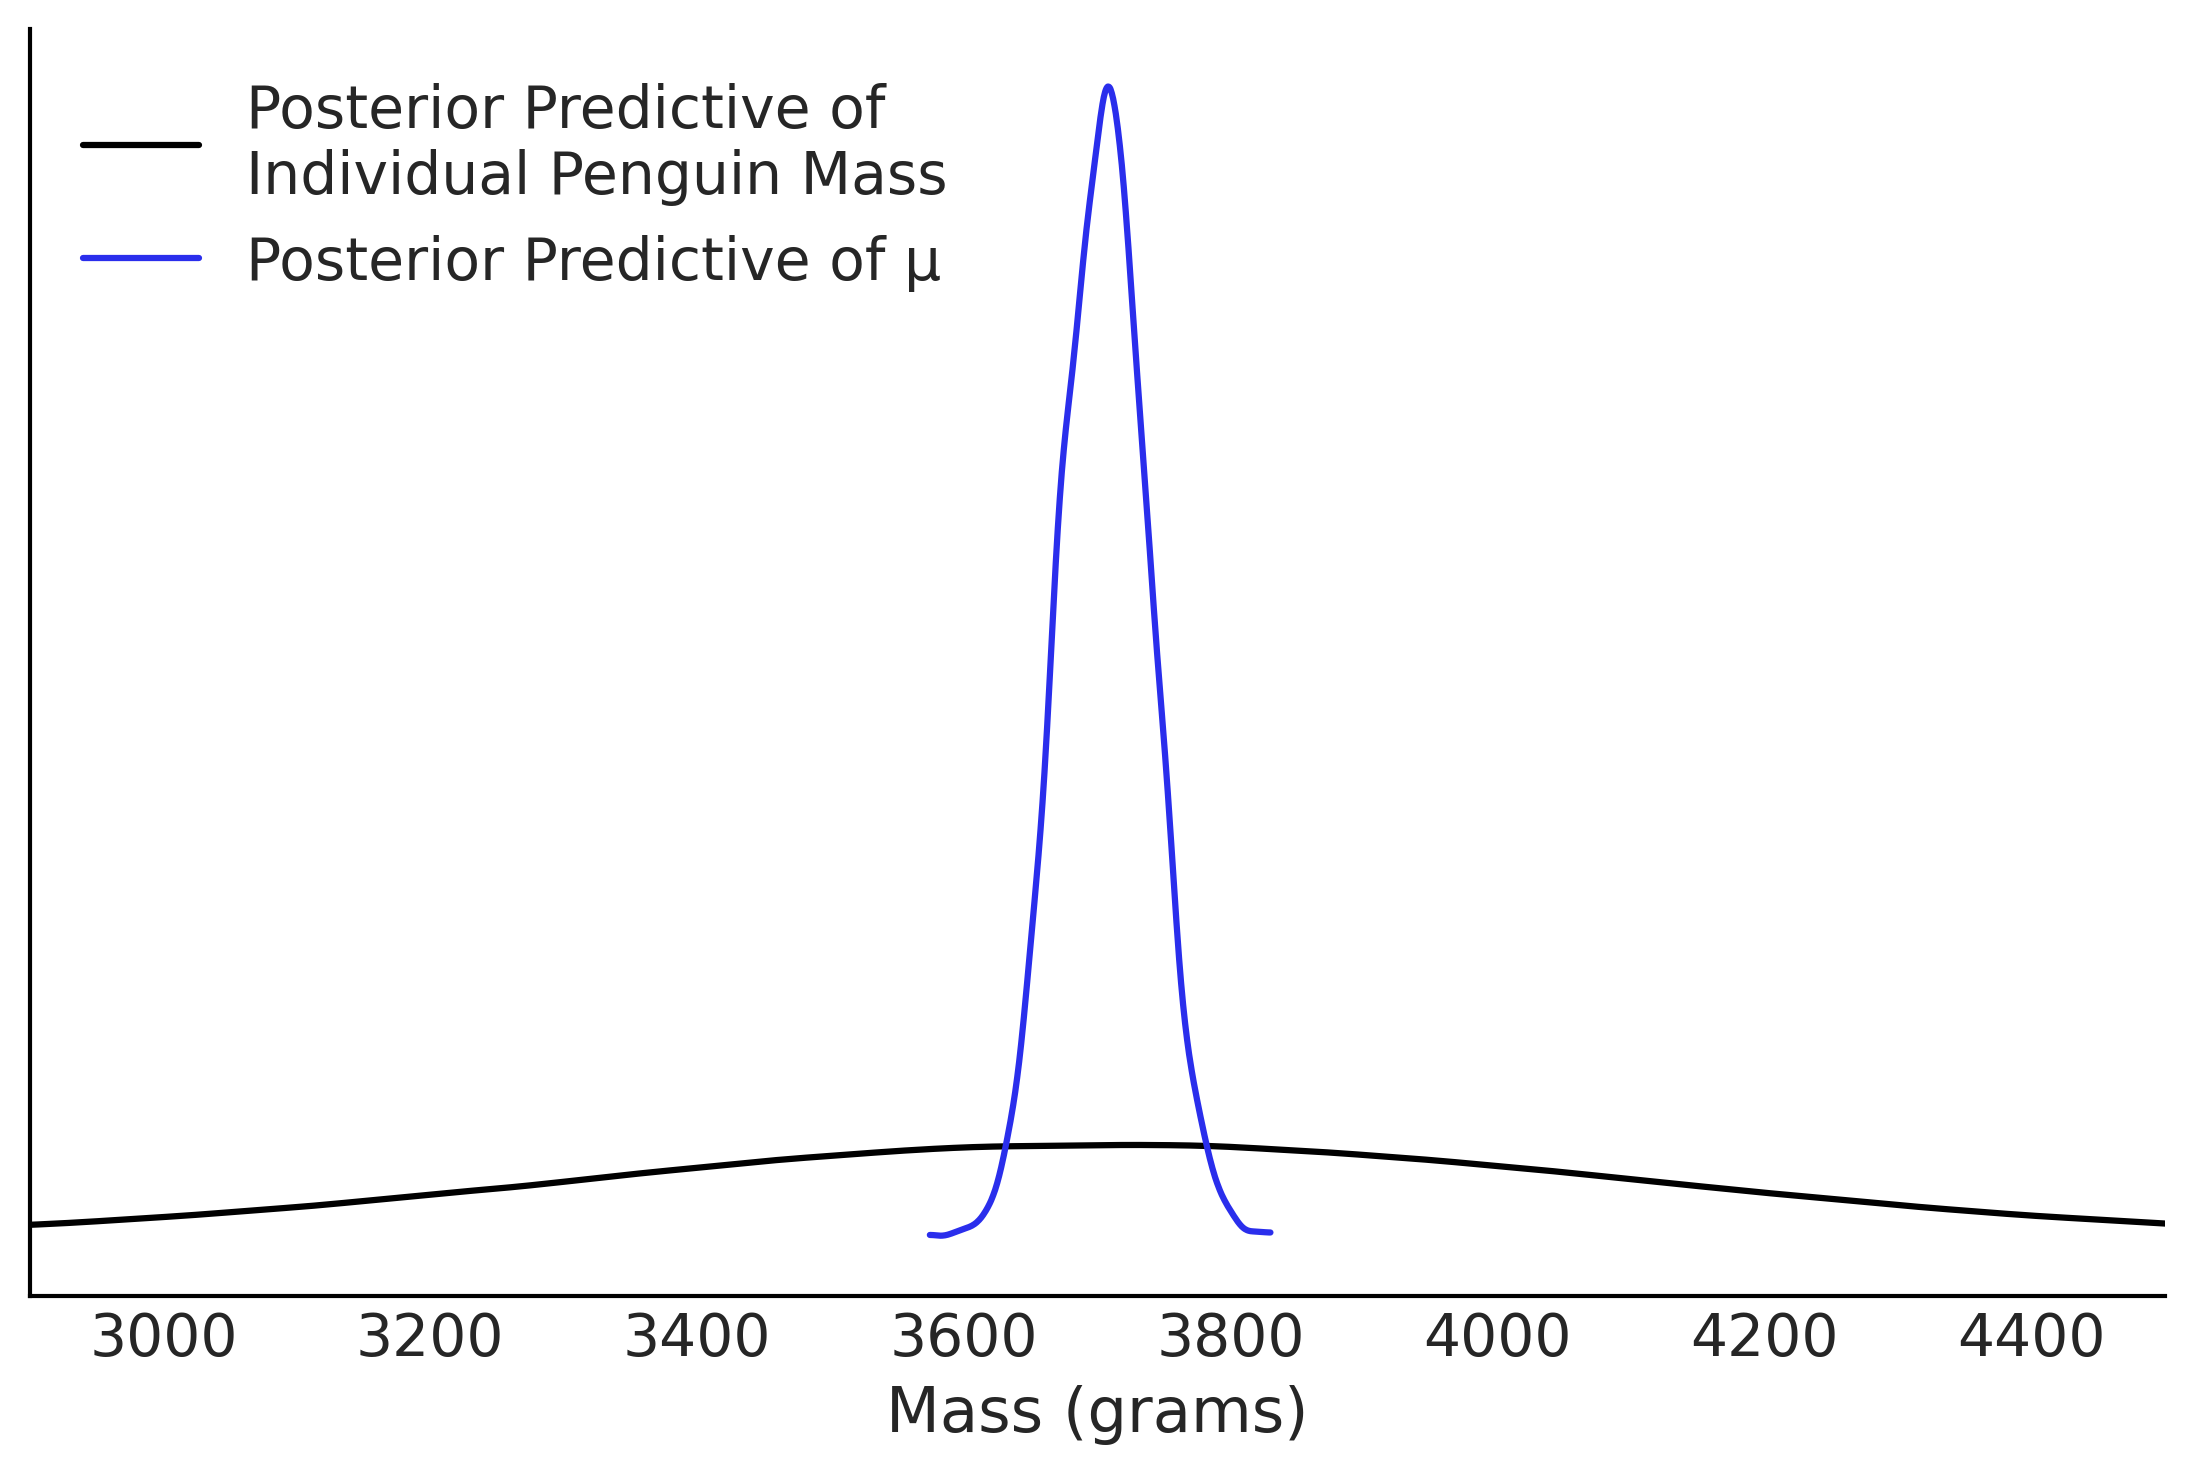

In [32]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictions.posterior_predictive["mass"],
             label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions.posterior_predictive["μ"], label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")
ax.set_yticks([])
plt.savefig('img/chp03/flipper_length_mass_posterior_predictive.png', dpi=300)

### Code 3.15

In [33]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()


### PyMC Centered Model

In [34]:
with pm.Model() as model_adelie_flipper_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_1 = pm.Normal("β_1", 0, 4000)
    β_0 = pm.Normal("β_0", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_c)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    # Need to remove this one I find bug
    inf_data_adelie_flipper_length_c = pm.sample(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


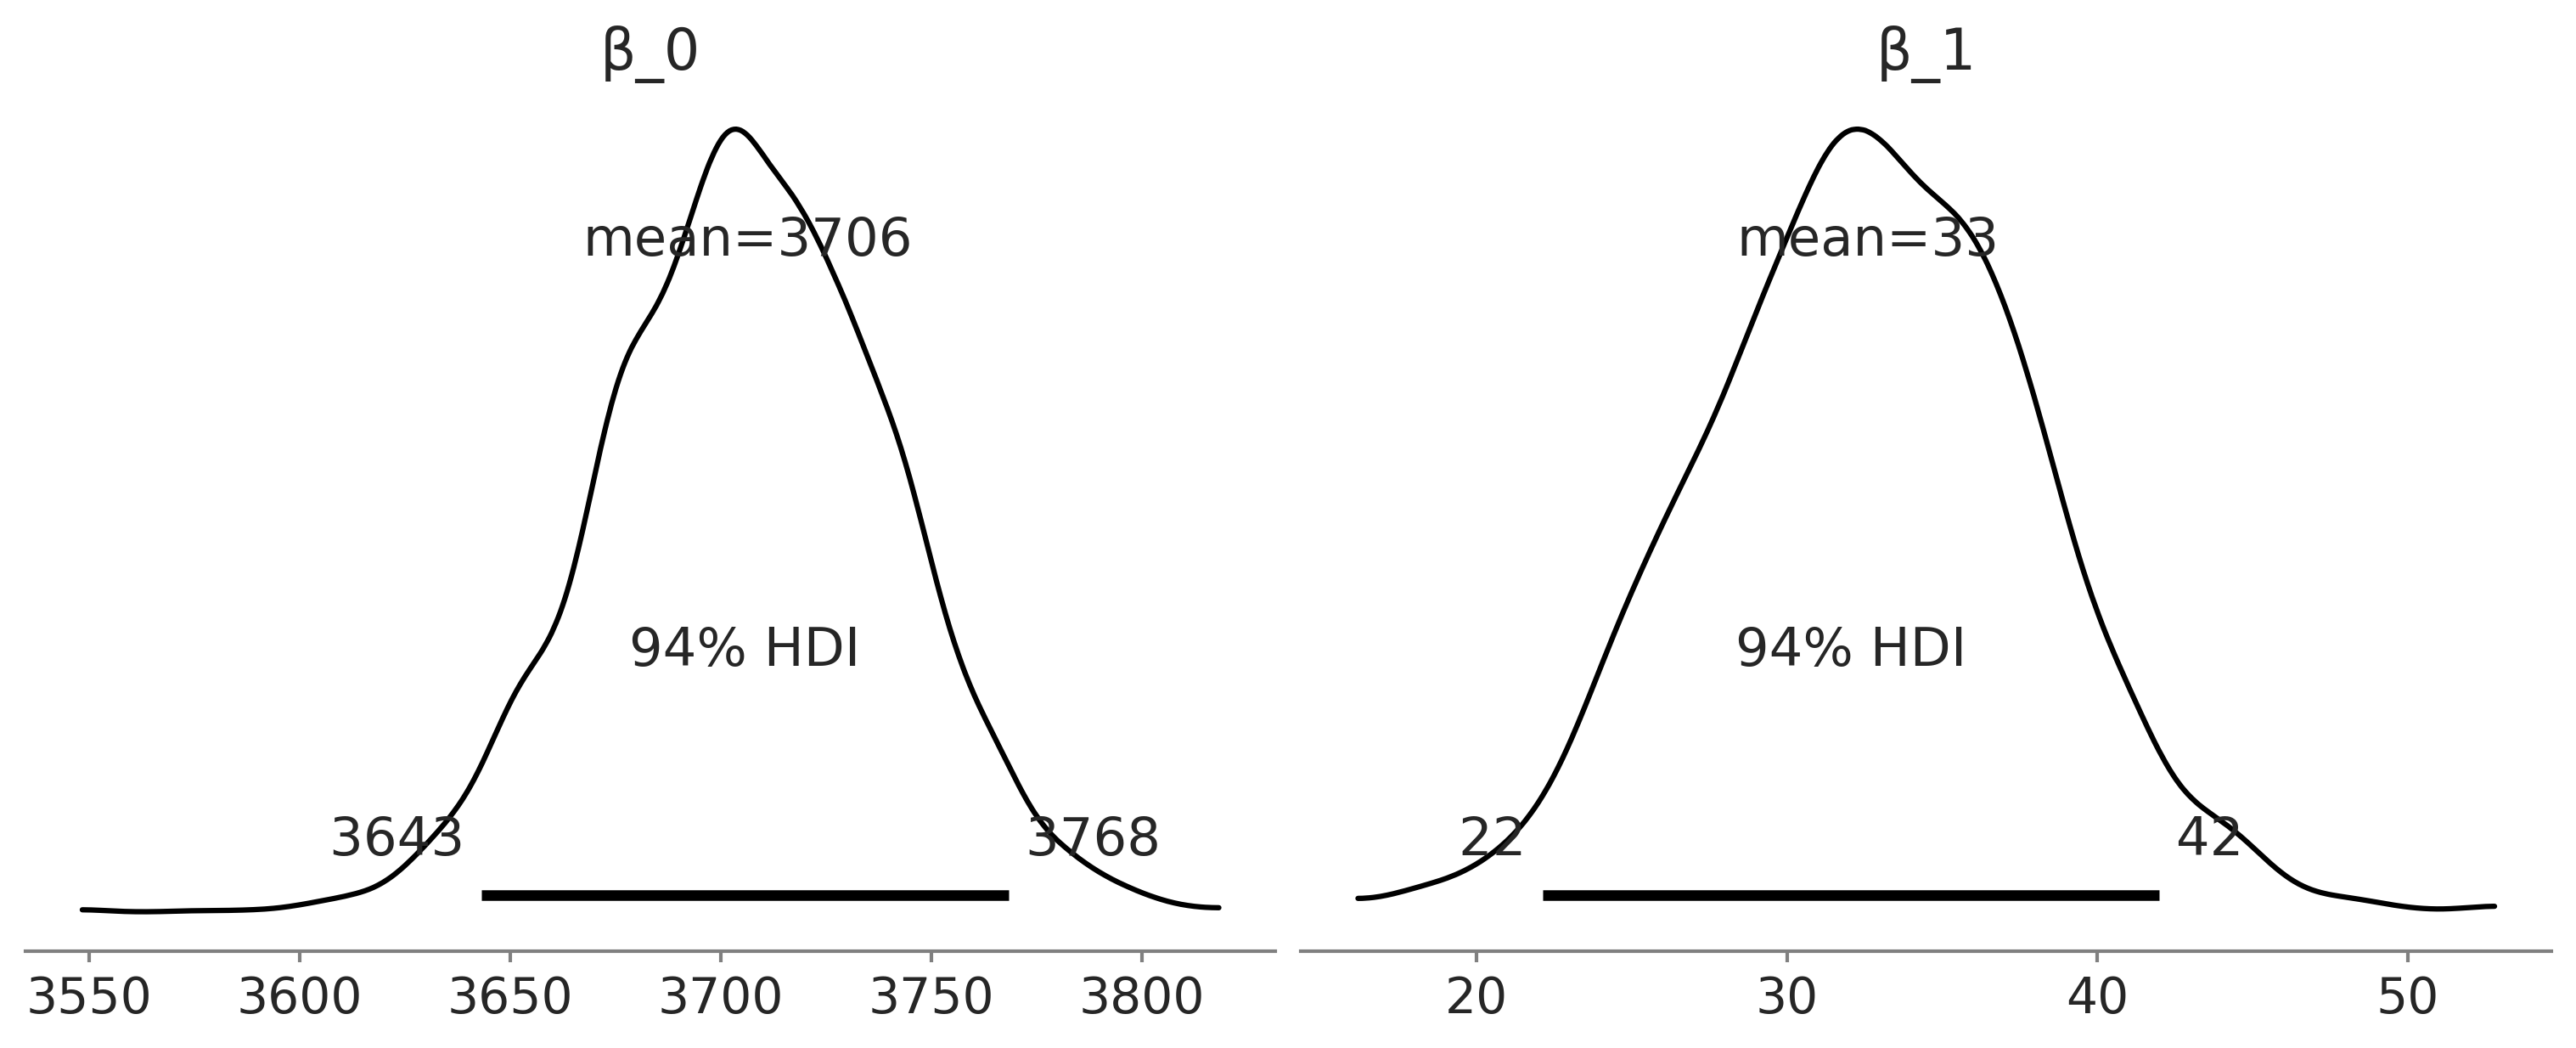

In [35]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["β_0", "β_1"], figsize=(10, 4));
plt.savefig("img/chp03/singlespecies_multipleregression_centered.png")

### Code 3.16

In [36]:
# adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

In [37]:
# def gen_adelie_flipper_model(adelie_flipper_length):
#     adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

#     @tfd.JointDistributionCoroutine
#     def jd_adelie_flipper_regression():
#         σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
#         β_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
#         β_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
#         μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
#         mass = yield tfd.Independent(
#             tfd.Normal(loc=μ, scale=σ[..., None]),
#             reinterpreted_batch_ndims=1,
#             name='mass')

#     return jd_adelie_flipper_regression


# # Use non-centered predictor, this gives the same model as
# # model_adelie_flipper_regression
# jd_adelie_flipper_regression = gen_adelie_flipper_model(
#     adelie_flipper_length_obs)

# # Use centered predictor
# jd_adelie_flipper_regression = gen_adelie_flipper_model(
#     adelie_flipper_length_c)

# mcmc_samples, sampler_stats = run_mcmc(
#     1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
#     mass=tf.constant(adelie_mass_obs, tf.float32))

# inf_data_adelie_flipper_length_c = az.from_dict(
#     posterior={
#         k:np.swapaxes(v, 1, 0)
#         for k, v in mcmc_samples._asdict().items()},
#     sample_stats={
#         k:np.swapaxes(sampler_stats[k], 1, 0)
#         for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
#     }
# )

### Figure 3.12

In [38]:
# az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["beta_0", "beta_1"]);

## Multiple Linear Regression

### Code 3.17

In [39]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


### Figure 3.13

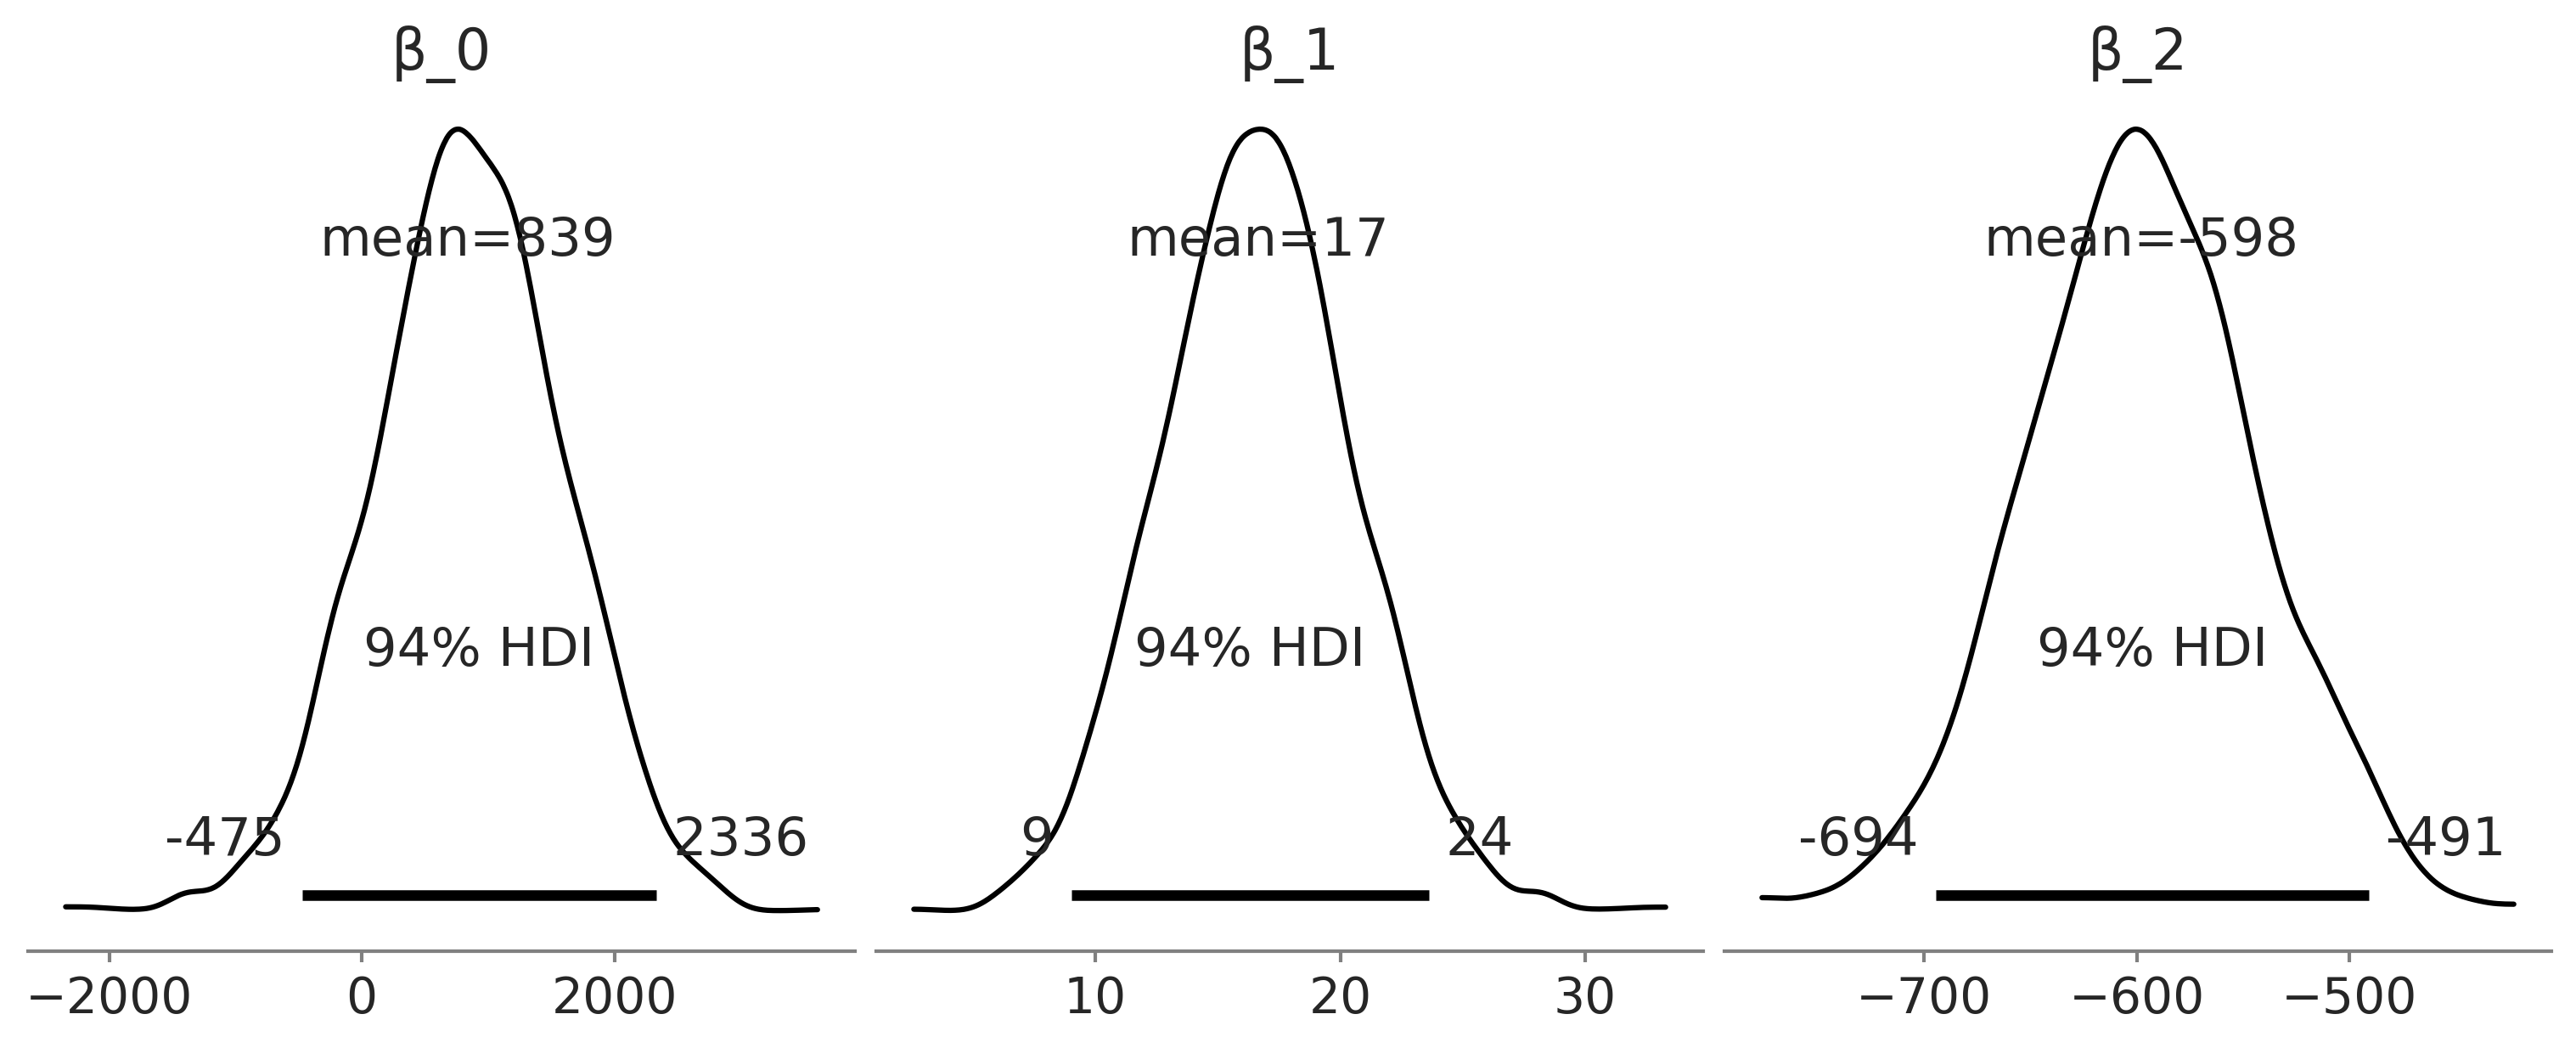

In [40]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names =["β_0", "β_1", "β_2"], figsize=(10, 4))
plt.savefig("img/chp03/adelie_sex_coefficient_posterior.png")

In [41]:
az.summary(inf_data_penguin_mass_categorical, var_names=["β_0","β_1","β_2", "σ"])

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_0  838.885  756.534 -474.609  2335.682     20.052   14.182    1444.0   
β_1   16.657    3.928    9.013    23.607      0.104    0.075    1455.0   
β_2 -597.850   54.367 -694.378  -490.929      1.209    0.858    2022.0   
σ    297.464   18.159  261.869   329.734      0.369    0.264    2484.0   

     ess_tail  r_hat  
β_0    1480.0    1.0  
β_1    1457.0    1.0  
β_2    2110.0    1.0  
σ      1908.0    1.0

### Code 3.19 and Figure 3.15

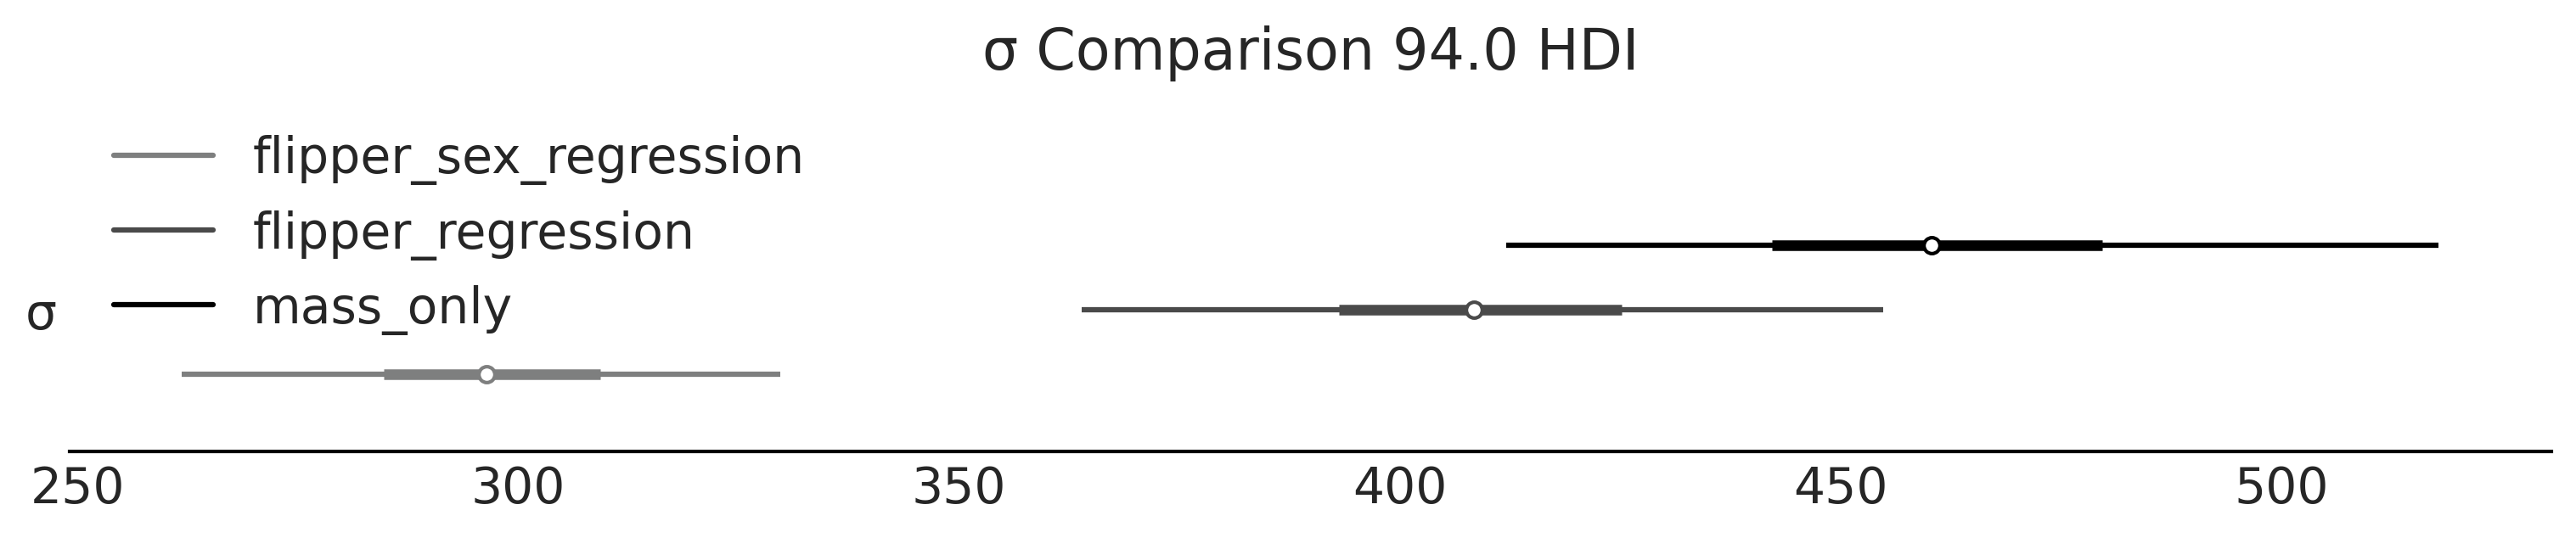

In [42]:
axes = az.plot_forest(
    [idata_adelie_mass, idata_adelie_flipper_regression, inf_data_penguin_mass_categorical],
    model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/singlespecies_multipleregression_forest_sigma_comparison.png")

### Figure 3.14

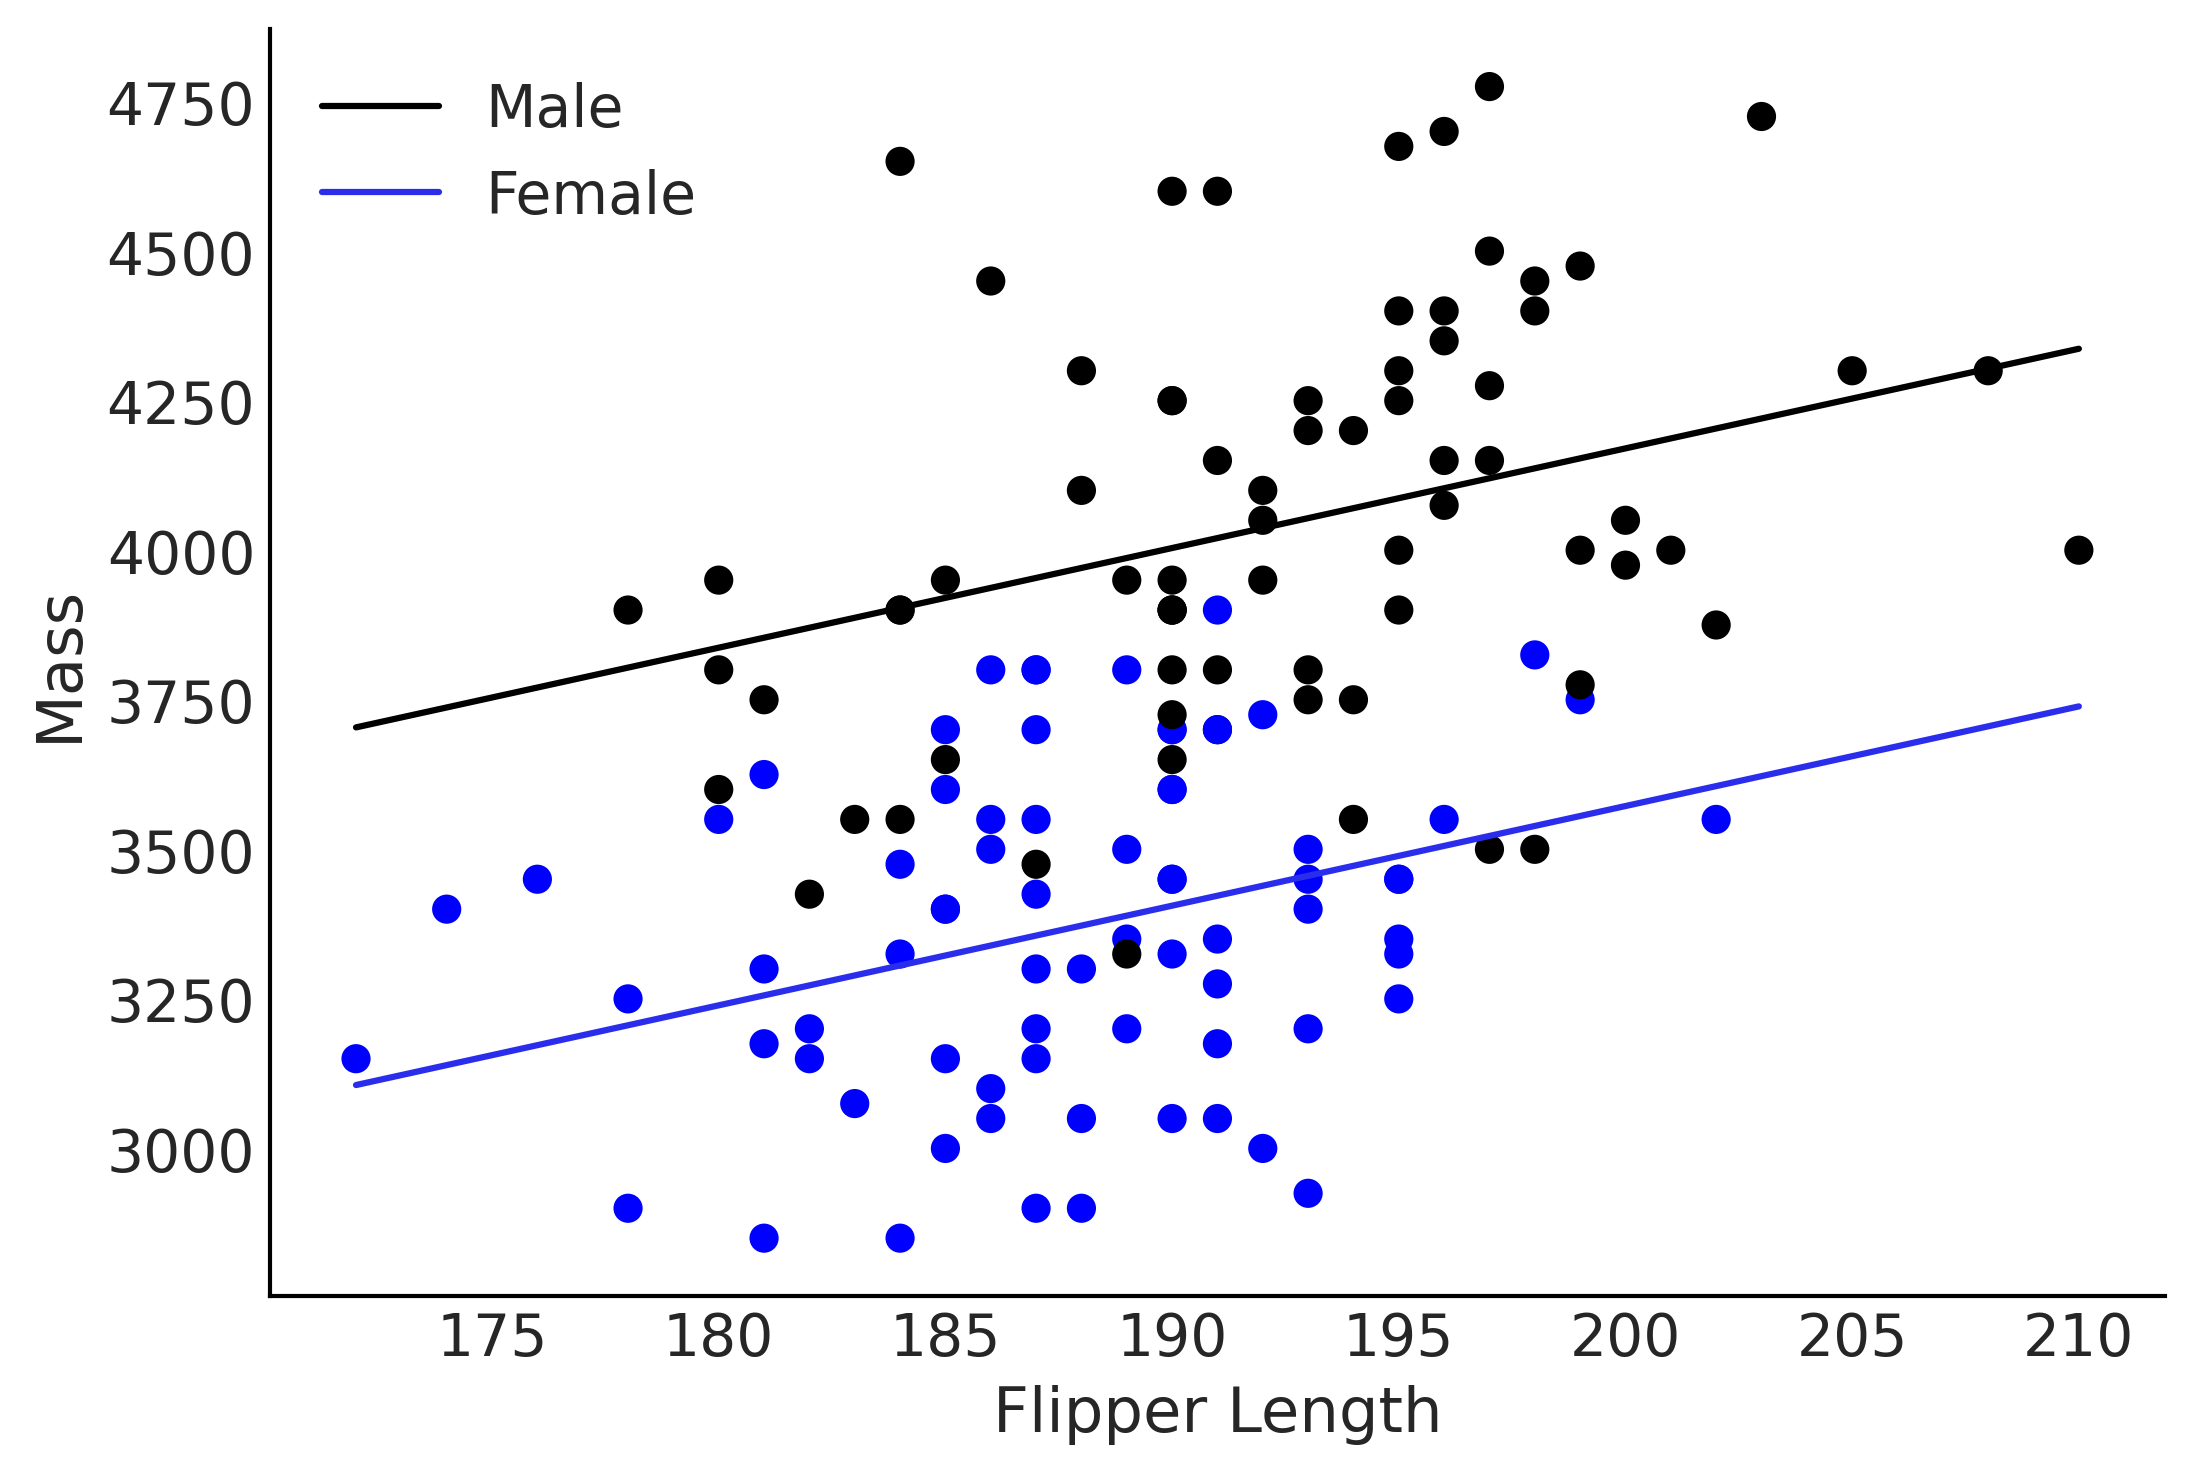

In [43]:
# Fix colors
fig, ax = plt.subplots()
alpha_1 = inf_data_penguin_mass_categorical.posterior["β_0"].mean().item()
beta_1 = inf_data_penguin_mass_categorical.posterior["β_1"].mean().item()
beta_2 = inf_data_penguin_mass_categorical.posterior["β_2"].mean().item()


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male")

ax.plot(flipper_length, mass_mean_female, c='C4',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"k", 1:"b"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()
plt.savefig("img/chp03/single_species_categorical_regression.png")

In [44]:
# def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
#     flipper_length, sex, bill_length = tf.nest.map_structure(
#         lambda x: tf.constant(x, dtype),
#         (flipper_length, sex, bill_length)
#     )

#     @tfd.JointDistributionCoroutine
#     def jd_flipper_bill_sex():
#         σ = yield root(
#             tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
#         β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
#         β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
#         β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
#         β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
#         μ = (β_0[..., None]
#              + β_1[..., None] * flipper_length
#              + β_2[..., None] * sex
#              + β_3[..., None] * bill_length
#             )
#         mass = yield tfd.Independent(
#             tfd.Normal(loc=μ, scale=σ[..., None]),
#             reinterpreted_batch_ndims=1,
#             name="mass")

#     return jd_flipper_bill_sex

# bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
# jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
#     adelie_flipper_length_obs, sex_obs, bill_length_obs)

# mcmc_samples, sampler_stats = run_mcmc(
#     1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
#     mass=tf.constant(adelie_mass_obs, tf.float32))

In [45]:
# idata_model_penguin_flipper_bill_sex = az.from_dict(
#     posterior={
#         k:np.swapaxes(v, 1, 0)
#         for k, v in mcmc_samples._asdict().items()},
#     sample_stats={
#         k:np.swapaxes(sampler_stats[k], 1, 0)
#         for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
# )

In [46]:
# az.plot_posterior(idata_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"]);

In [47]:
# az.summary(inf_data_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3", "sigma"])

### Code 3.21

In [48]:
# mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# # Counterfactual dimensions is set to 21 to allow us to get the mean exactly
# counterfactual_flipper_lengths = np.linspace(
#     mean_flipper_length-20, mean_flipper_length+20, 21)
# sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
# mean_bill_length = np.ones_like(
#     counterfactual_flipper_lengths) * bill_length_obs.mean()

# jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
#     counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)
# ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
# estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)

### Figure 3.16

In [49]:
# az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, color="C2", plot_kwargs={"ls": "--"})
# plt.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4, c="blue")
# plt.title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
# plt.xlabel("Counterfactual Flipper Length")
# plt.ylabel("Mass")
# plt.savefig("img/chp03/linear_counter_factual.png")

## Generalized Linear Models

### Figure 3.17

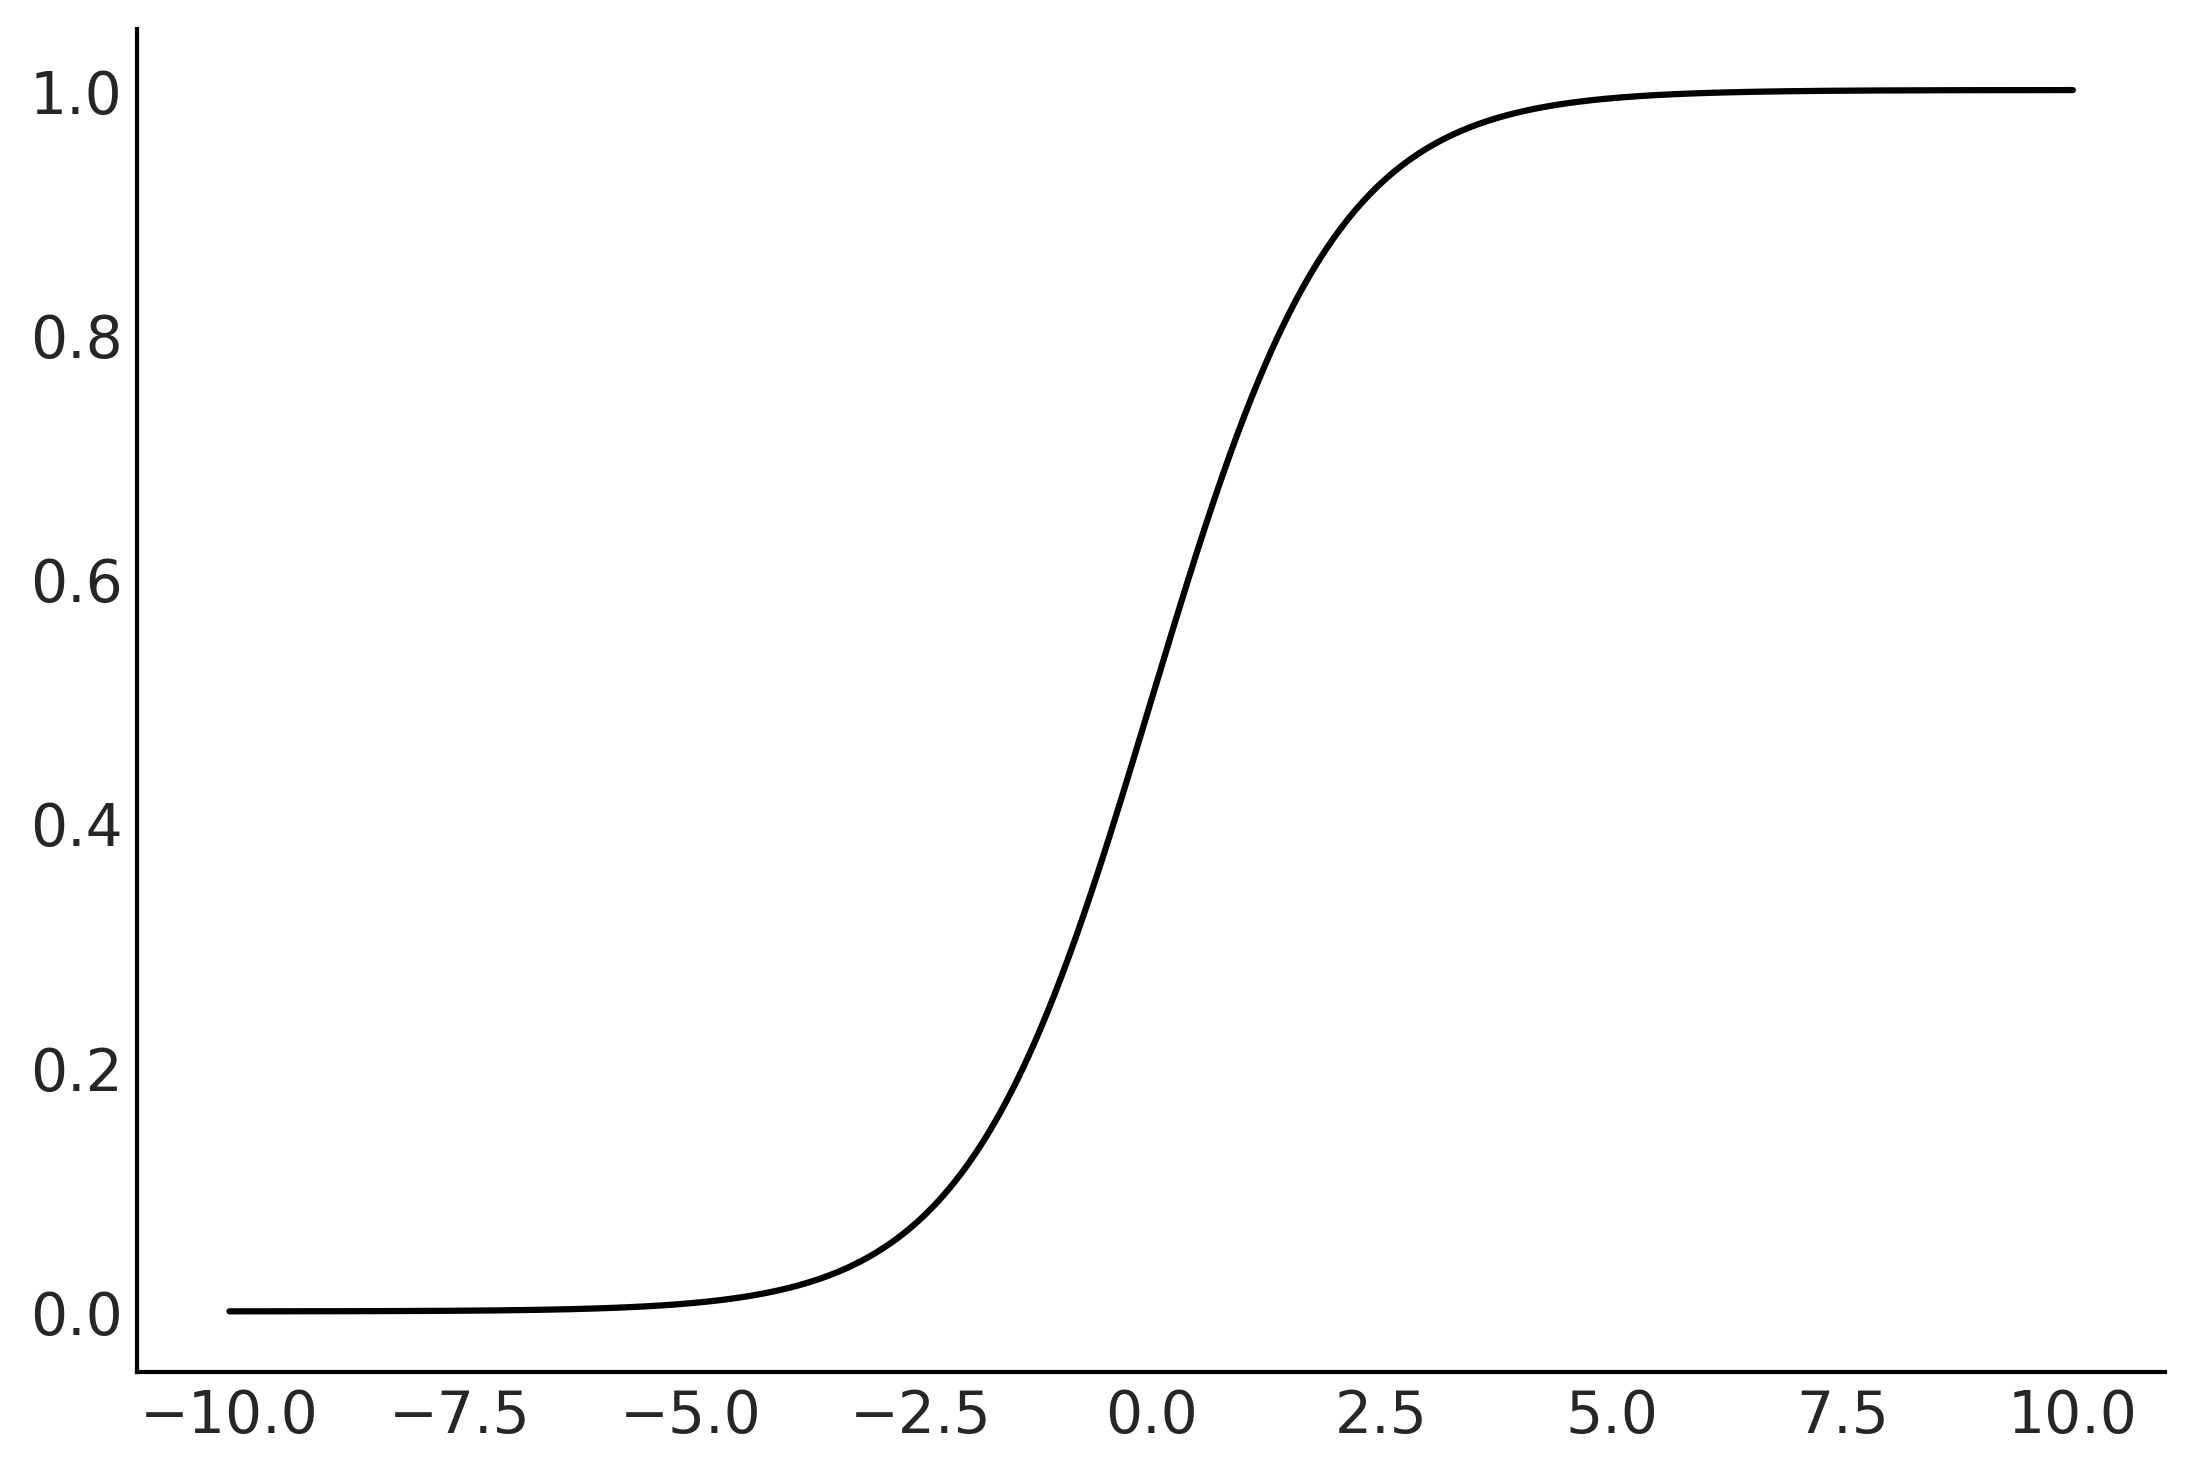

In [50]:
x = np.linspace(-10, 10, 1000)
y = special.expit(x)

plt.plot(x,y)
plt.savefig("img/chp03/logistic.png")

### Code 3.22

In [51]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length = pm.sample(5000, chains=2, random_seed=0,
                                                    idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length.extend(pm.sample_prior_predictive(samples=10000))
    idata_logistic_penguins_bill_length.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl, β_0, β_1]
Sampling: [yl]


### Figure 3.18

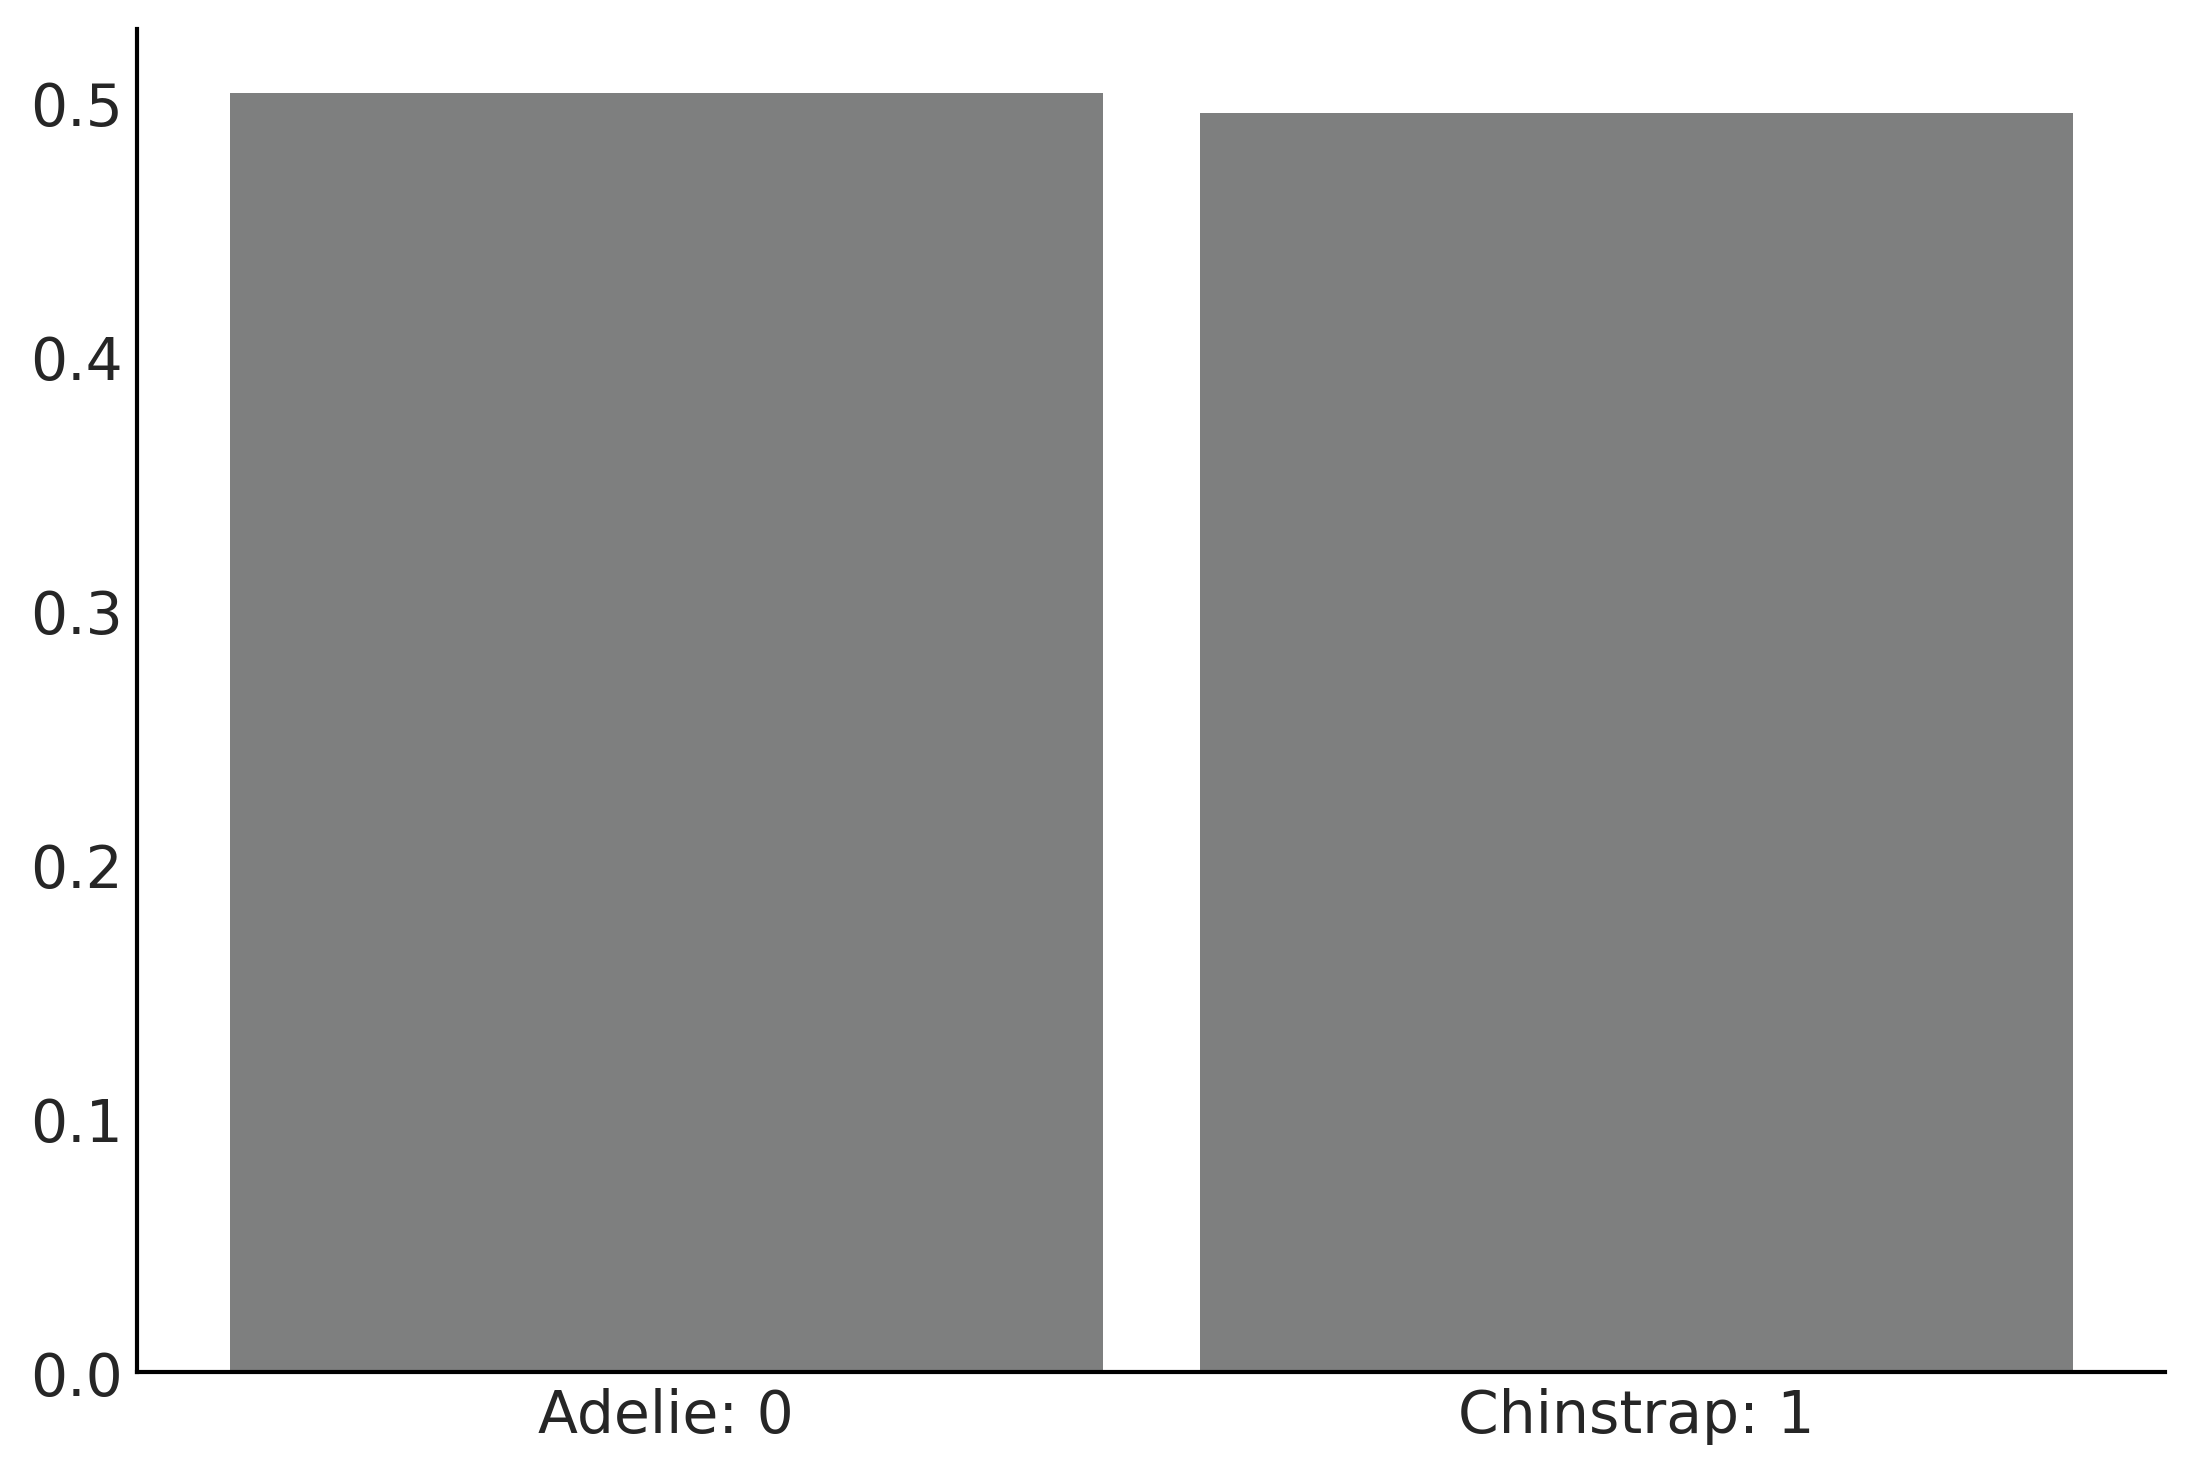

In [52]:
ax = az.plot_dist(idata_logistic_penguins_bill_length.prior_predictive["yl"], color="C2")
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )
plt.savefig("img/chp03/prior_predictive_logistic.png")

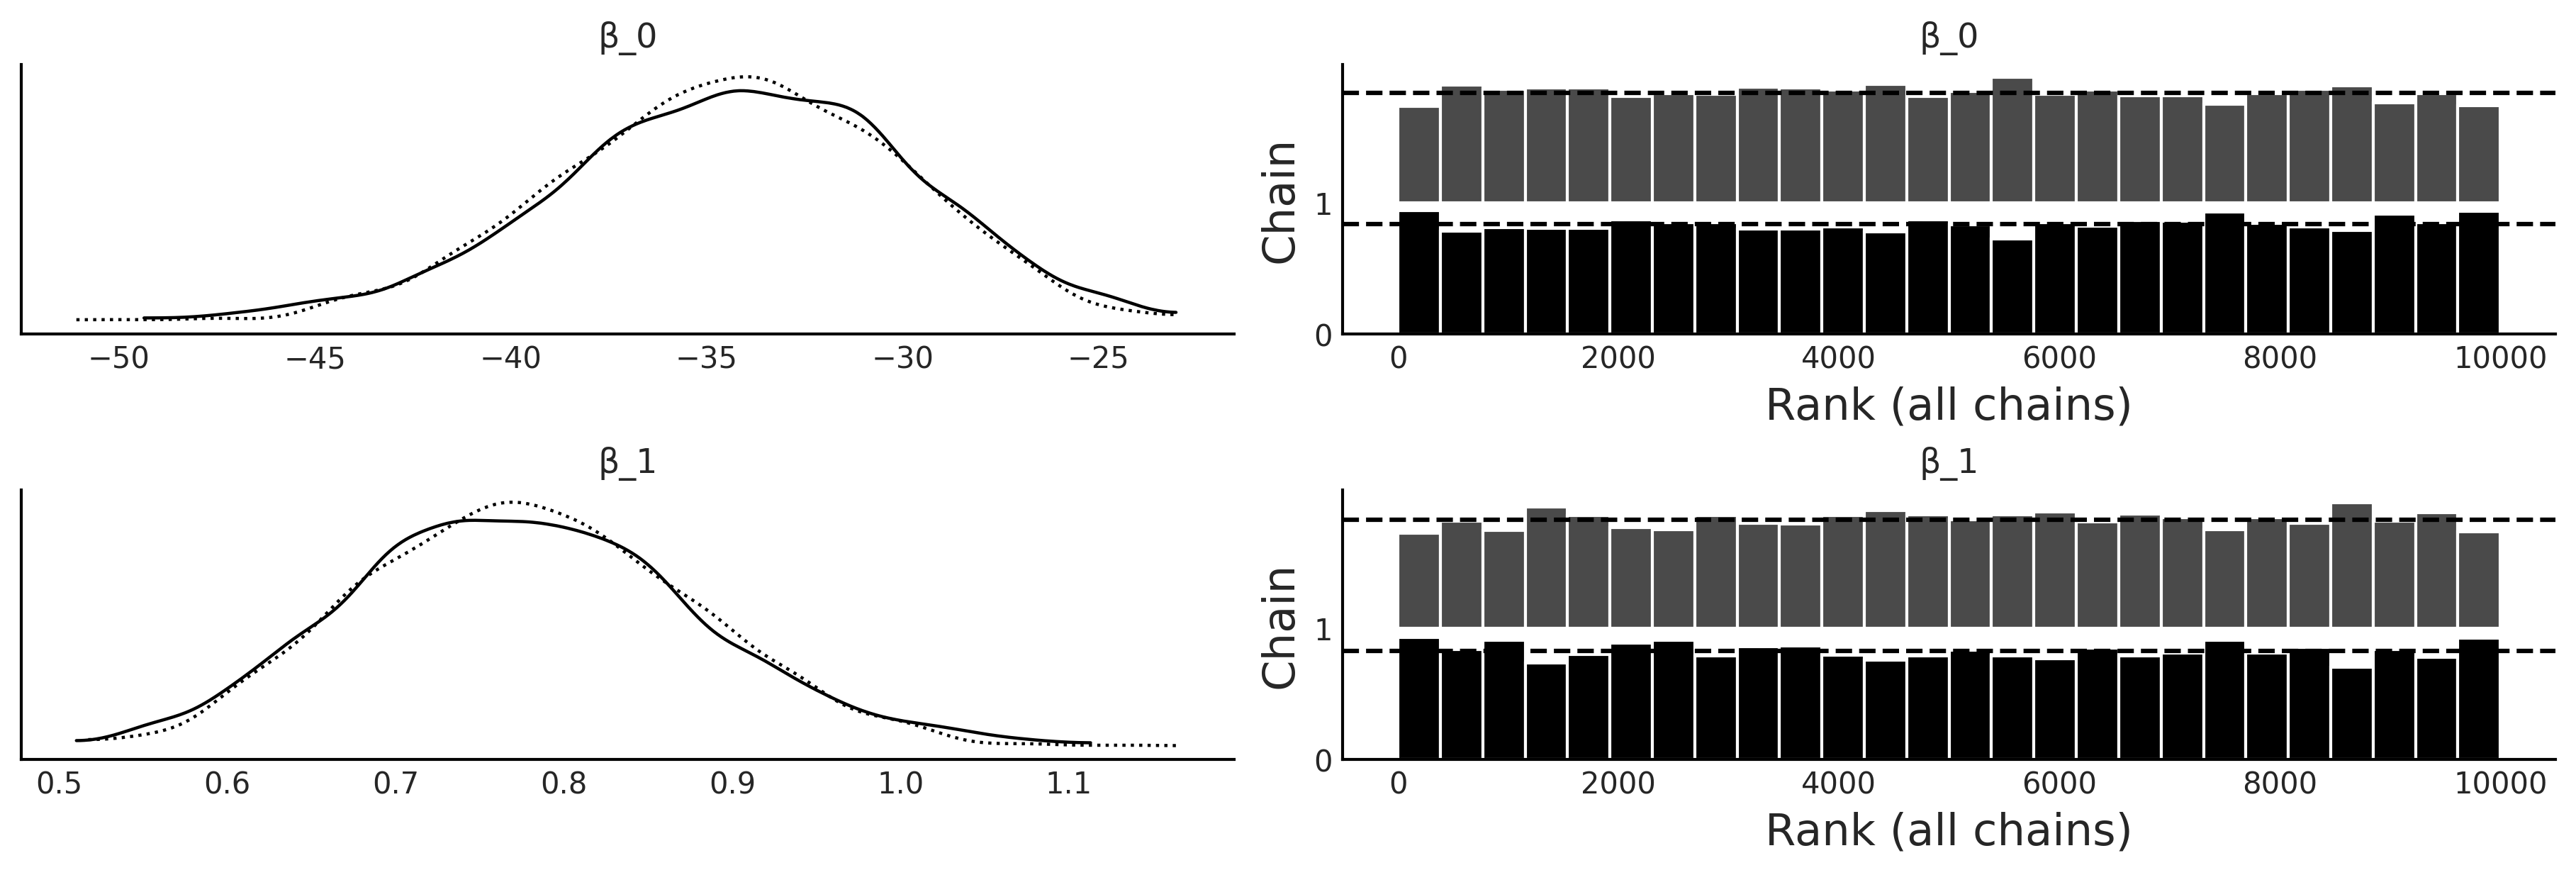

In [53]:
az.plot_trace(idata_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="rank_bars");

### Table 3.3

In [54]:
az.summary(idata_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -34.377  4.367 -42.339  -26.300
β_1   0.777  0.100   0.590    0.959

### Figure 3.19

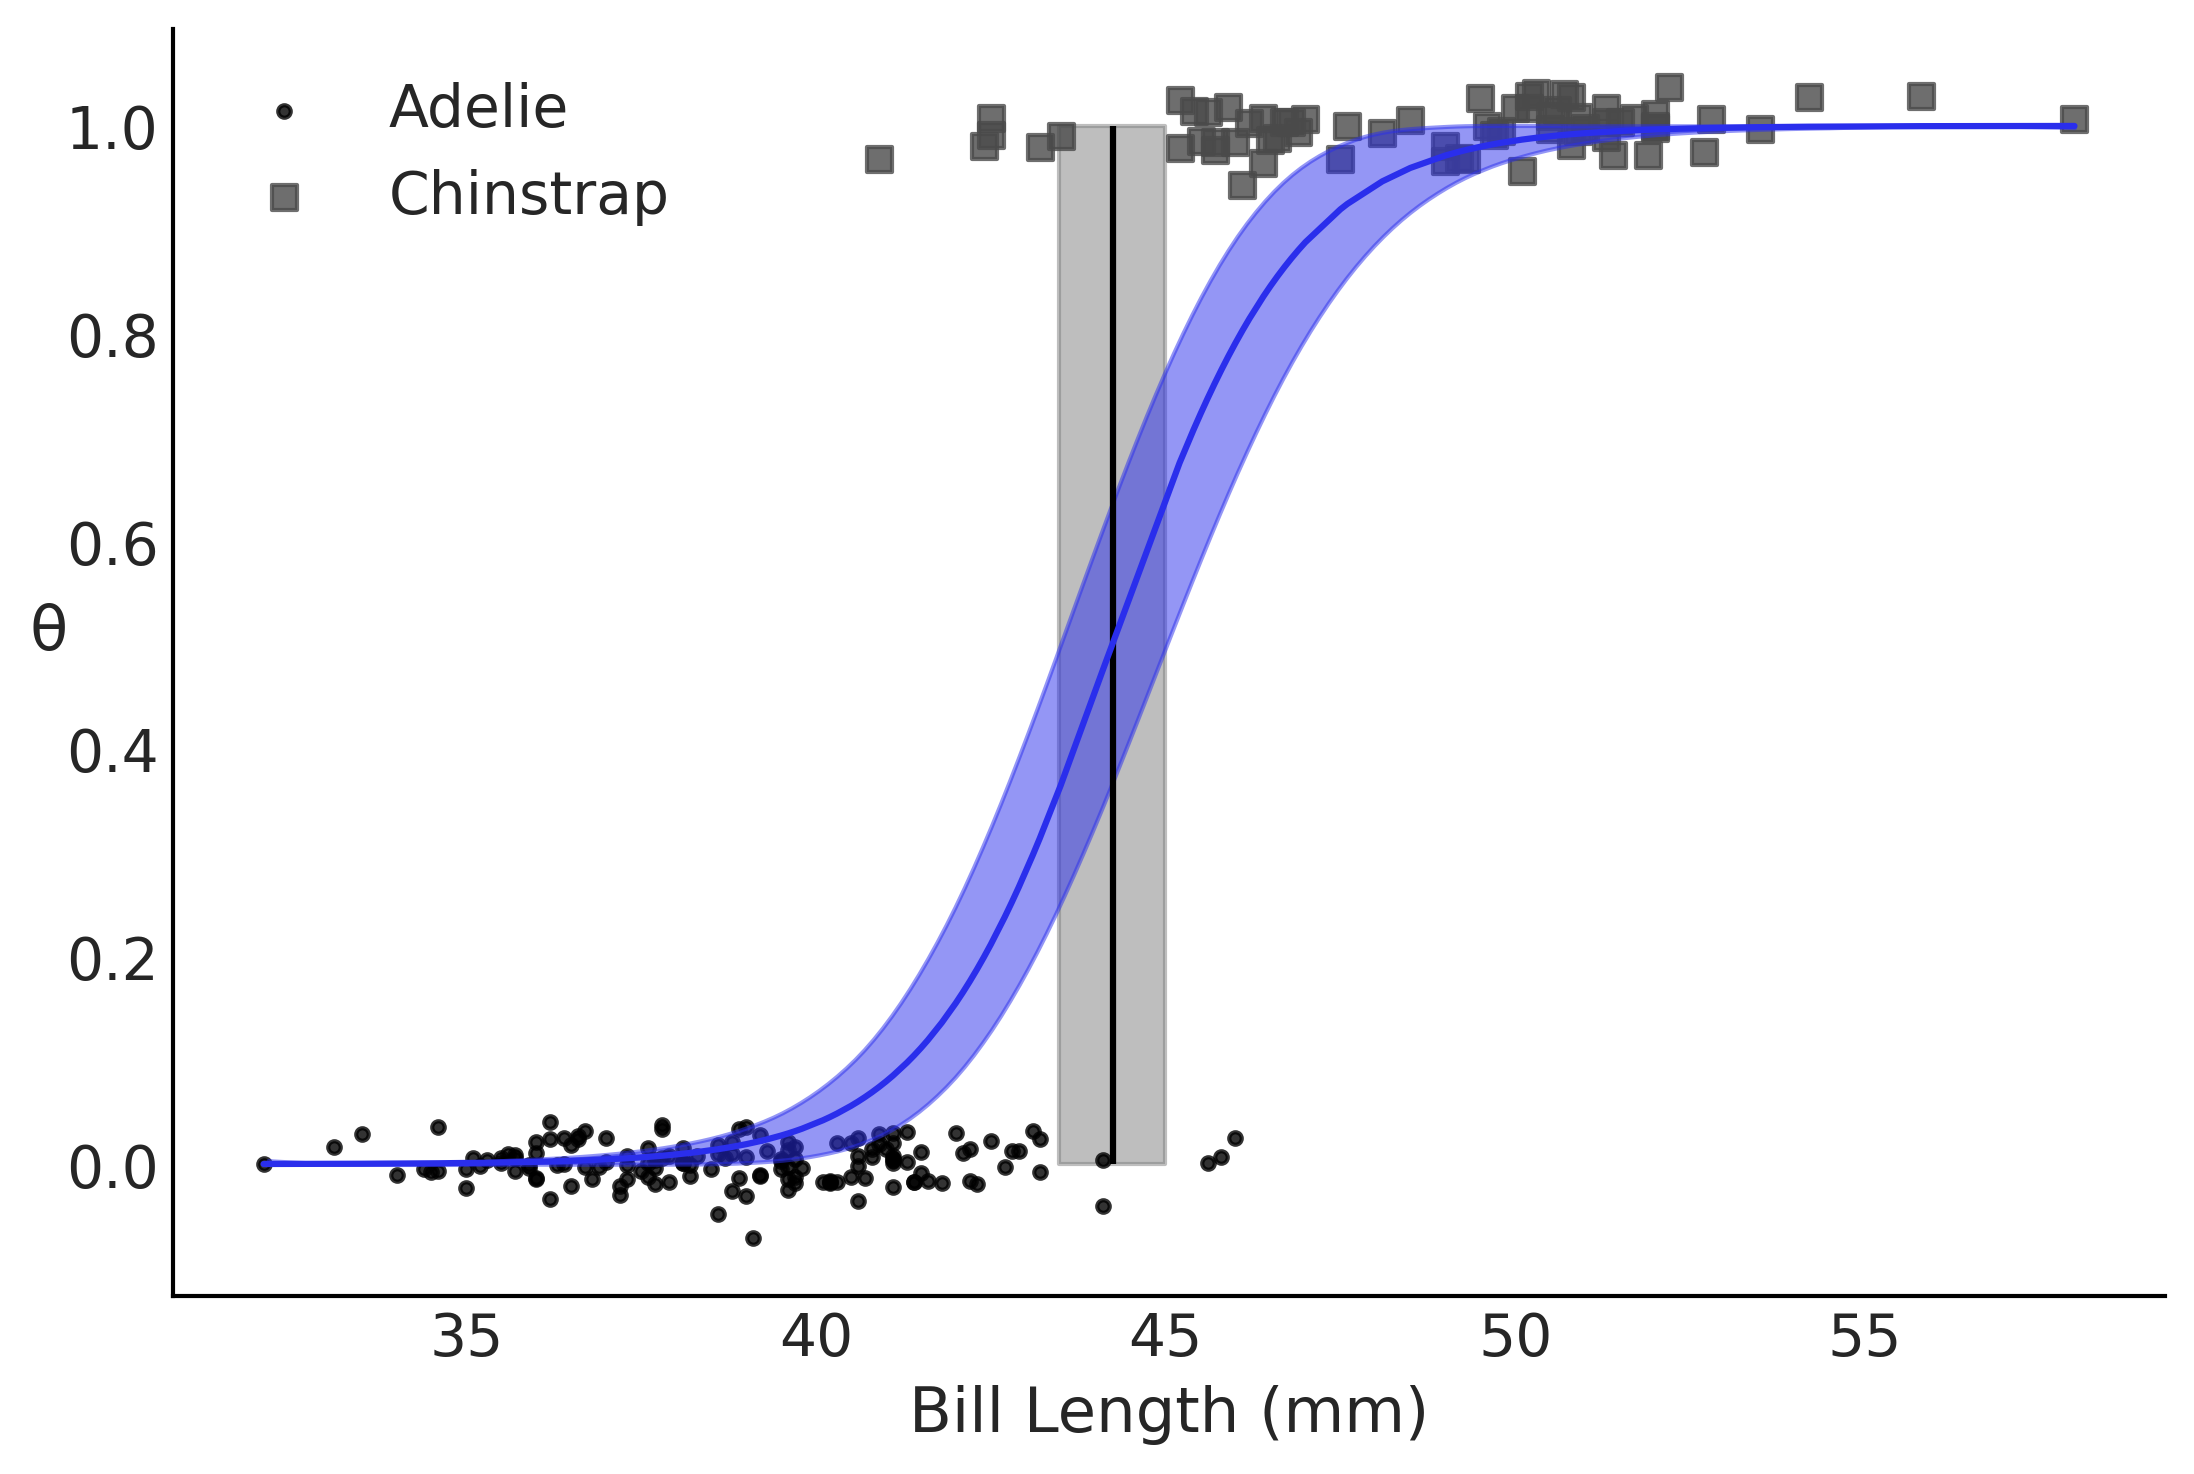

In [55]:
fig, ax = plt.subplots()

theta = idata_logistic_penguins_bill_length.posterior["θ"].mean(("chain", "draw"))


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(idata_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(idata_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, idata_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()
plt.savefig("img/chp03/logistic_bill_length.png")

#### Code 3.23

In [56]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)


    idata_logistic_penguins_mass = pm.sample(5000, chains=2, 
                                             target_accept=.9, random_seed=0, 
                                             idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_mass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


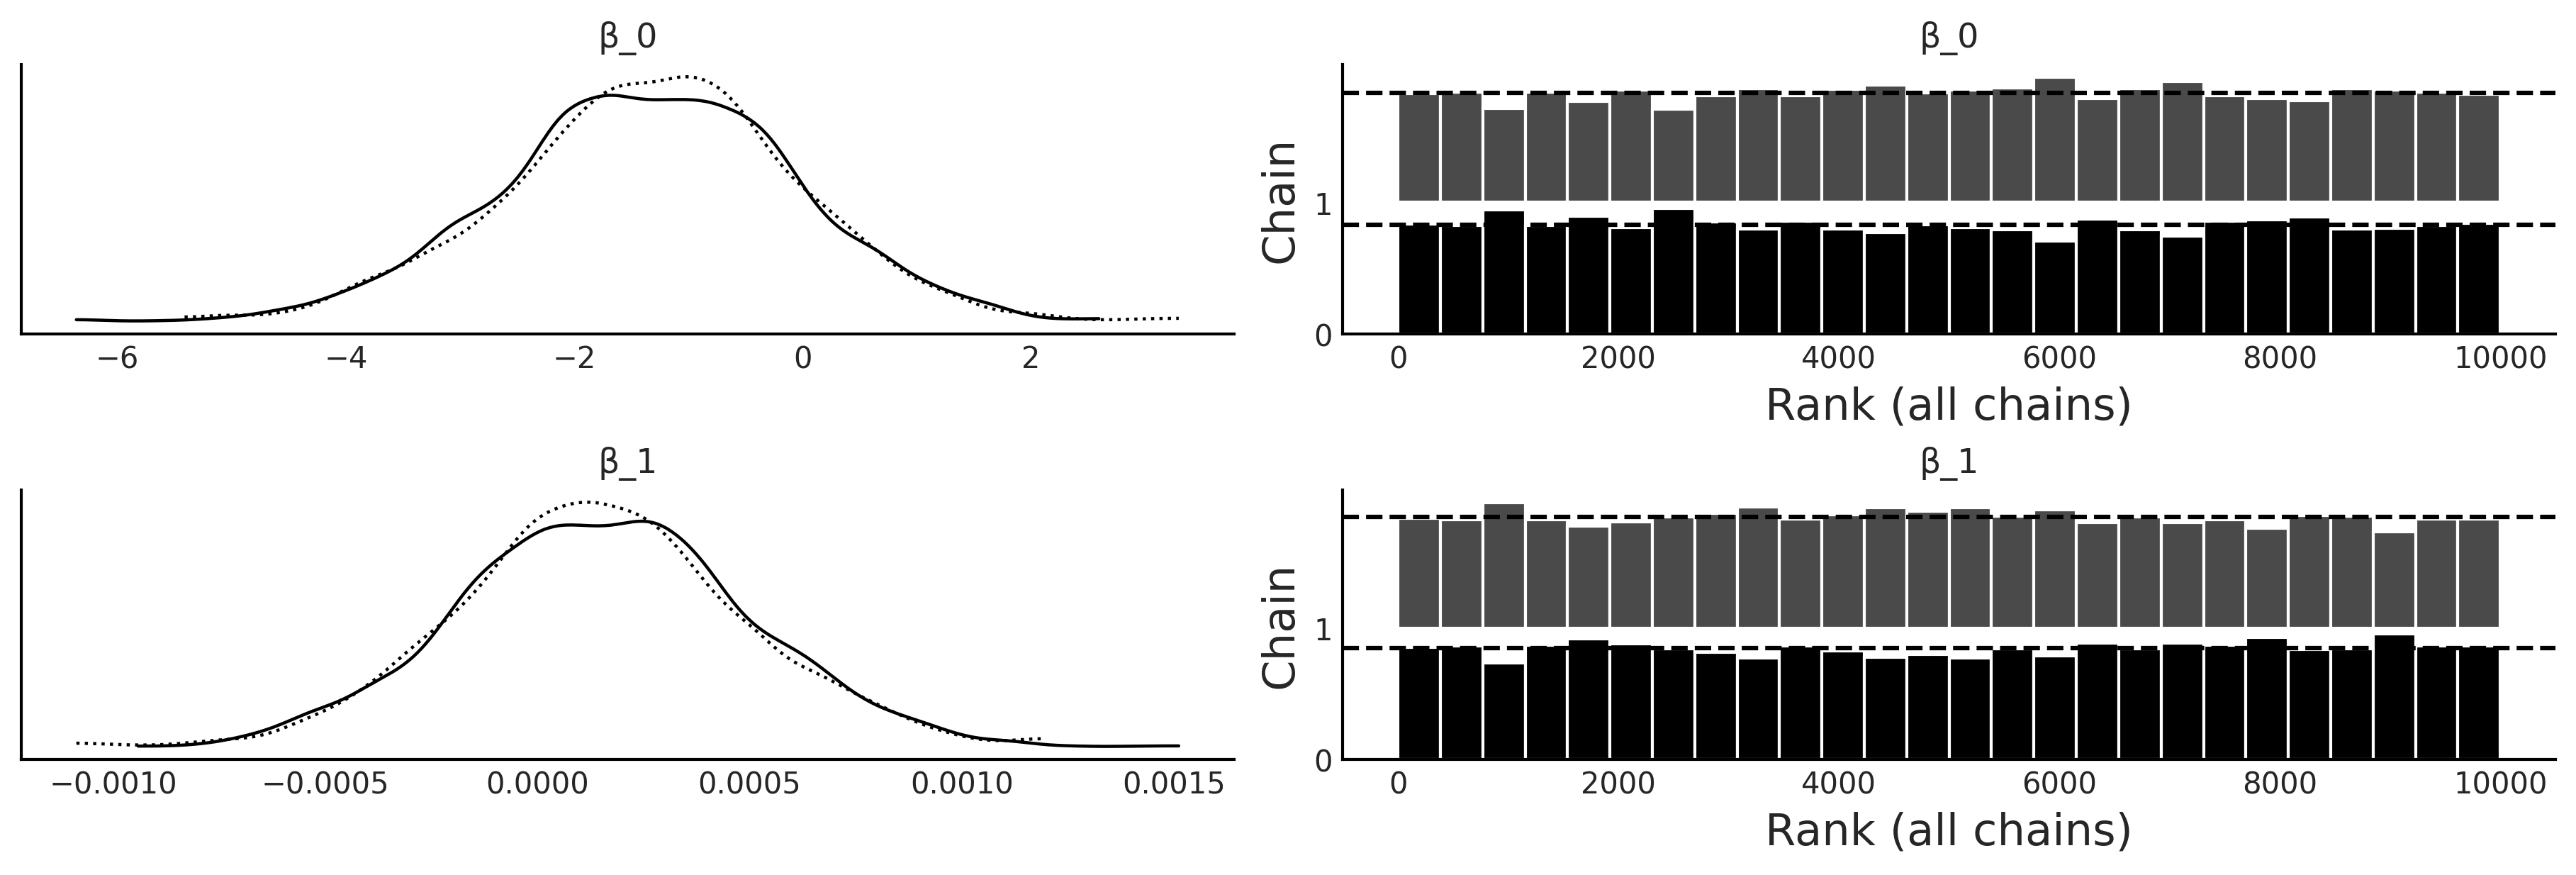

In [57]:
az.plot_trace(idata_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="rank_bars");

### Table 3.4

In [58]:
az.summary(idata_logistic_penguins_mass, var_names=["β_0", "β_1", "bd"], kind="stats")

mean          sd     hdi_3%    hdi_97%
β_0     -1.338       1.272     -3.833      0.996
β_1      0.000       0.000     -0.000      0.001
bd   14439.414  785539.146 -22330.299  35861.265

### Figure 3.20

In [59]:
species.codes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

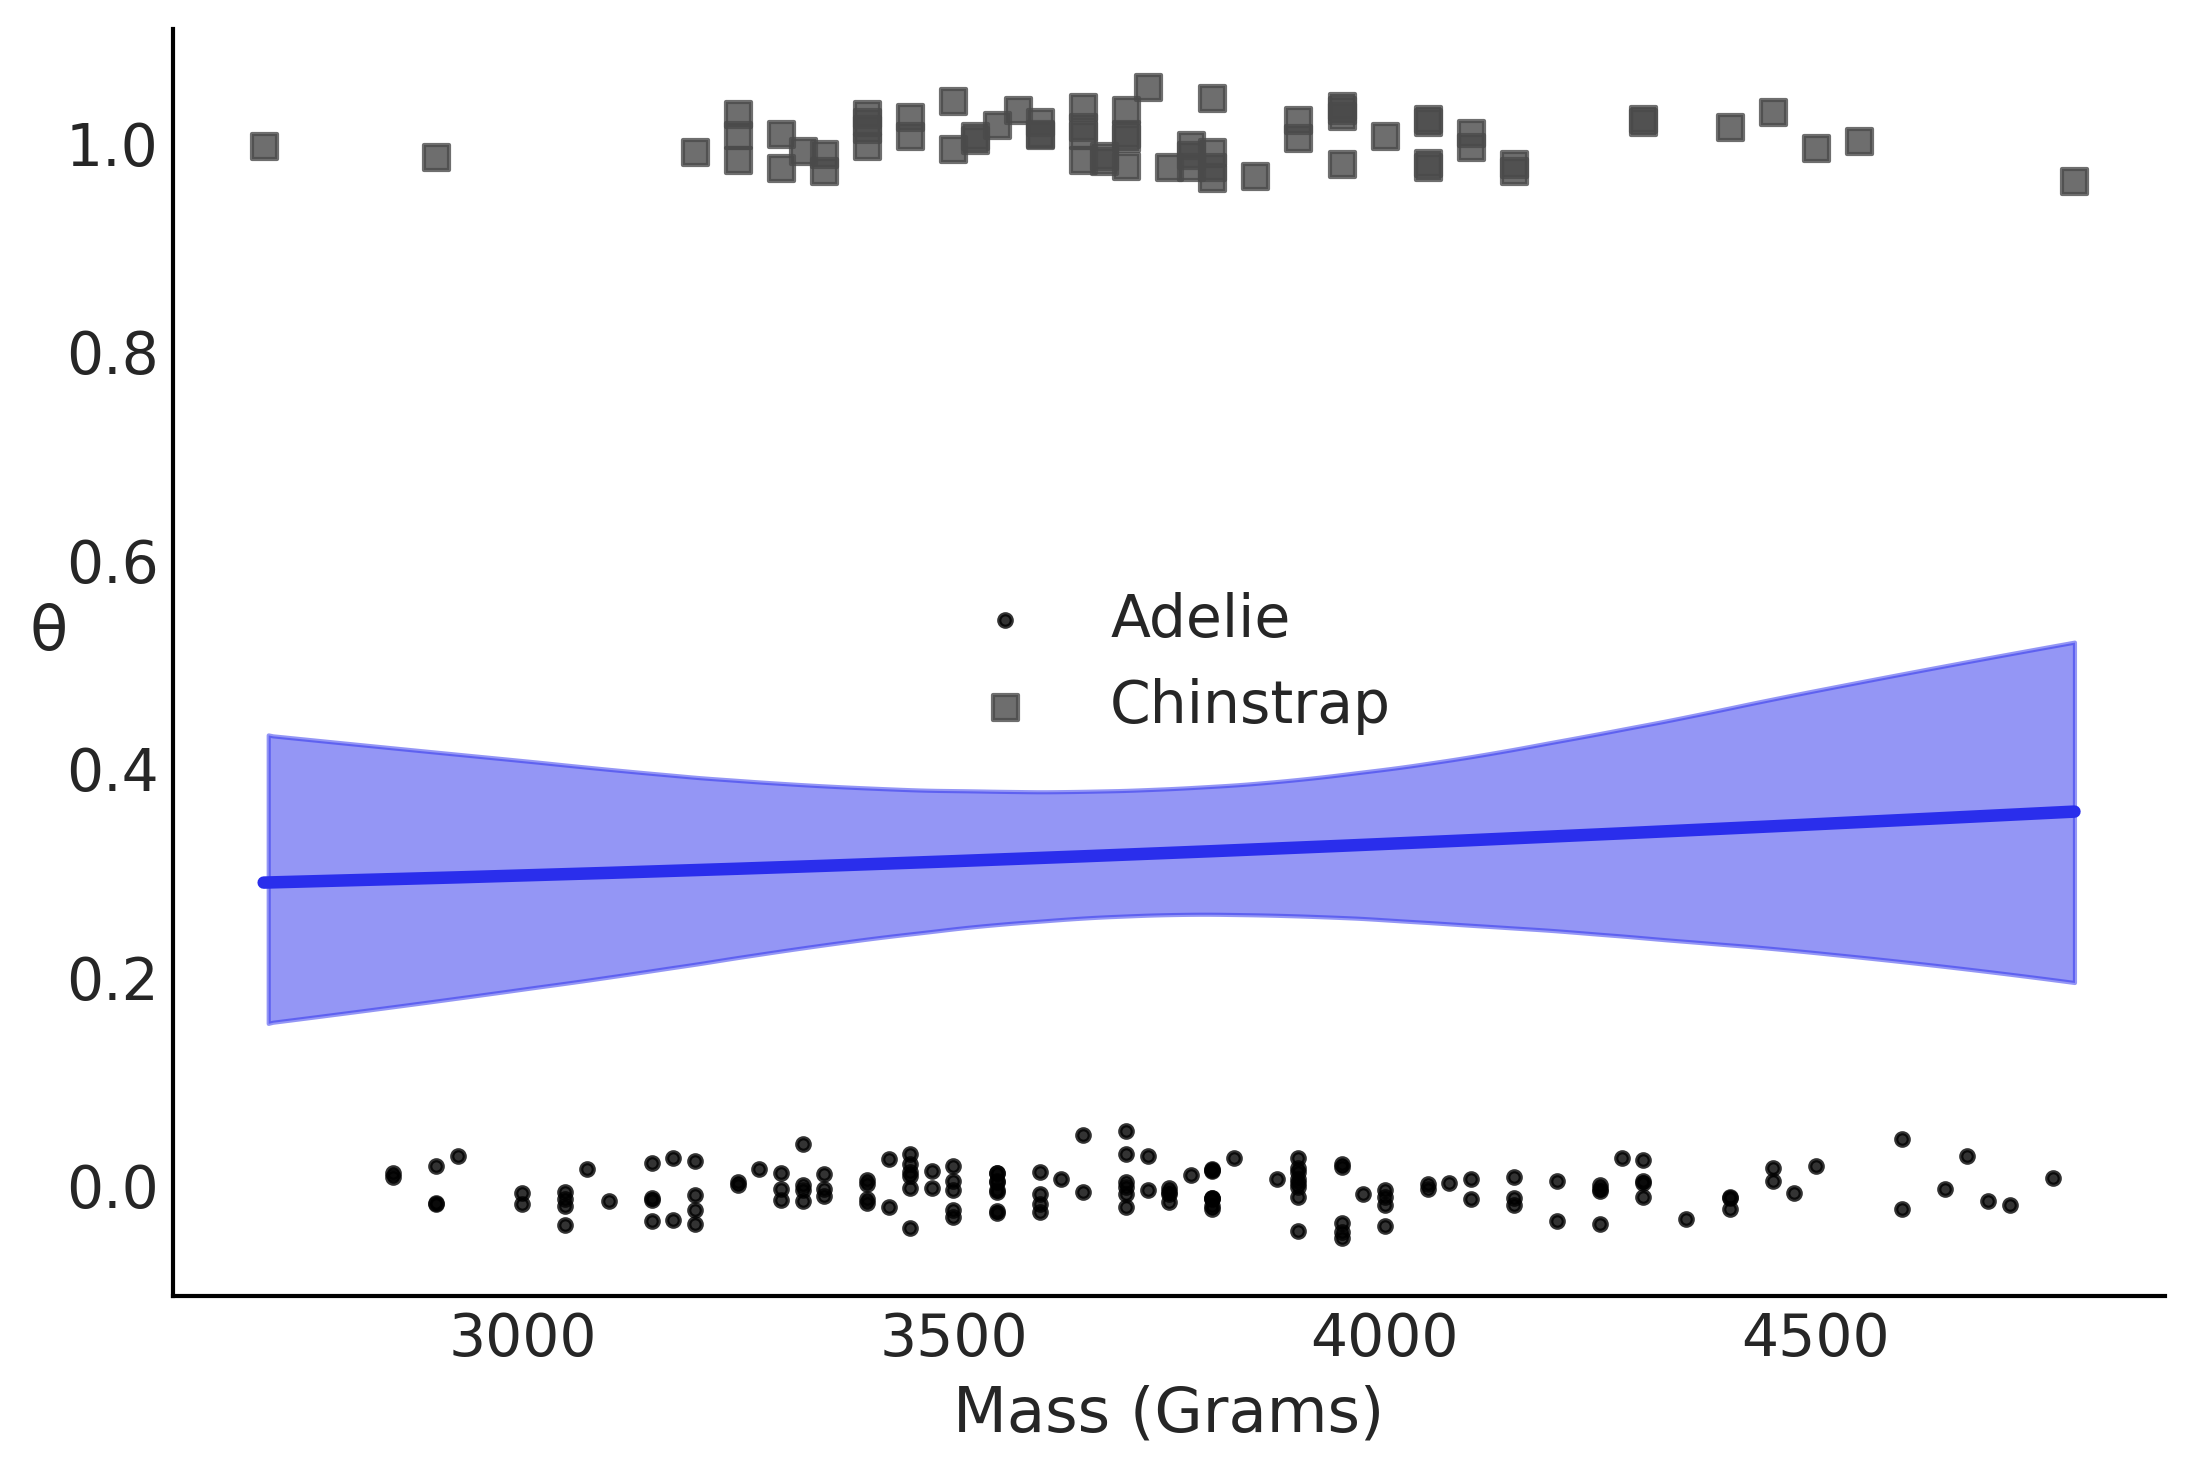

In [60]:
theta = idata_logistic_penguins_mass.posterior['θ'].mean(("chain", "draw"))
bd = idata_logistic_penguins_mass.posterior['bd']

fig, ax = plt.subplots()
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)



az.plot_hdi(mass_obs, idata_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

plt.savefig("img/chp03/logistic_mass.png")

### Code 3.24

In [61]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length_mass = pm.sample(5000, chains=2,
                                                         random_seed=0, 
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length_mass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


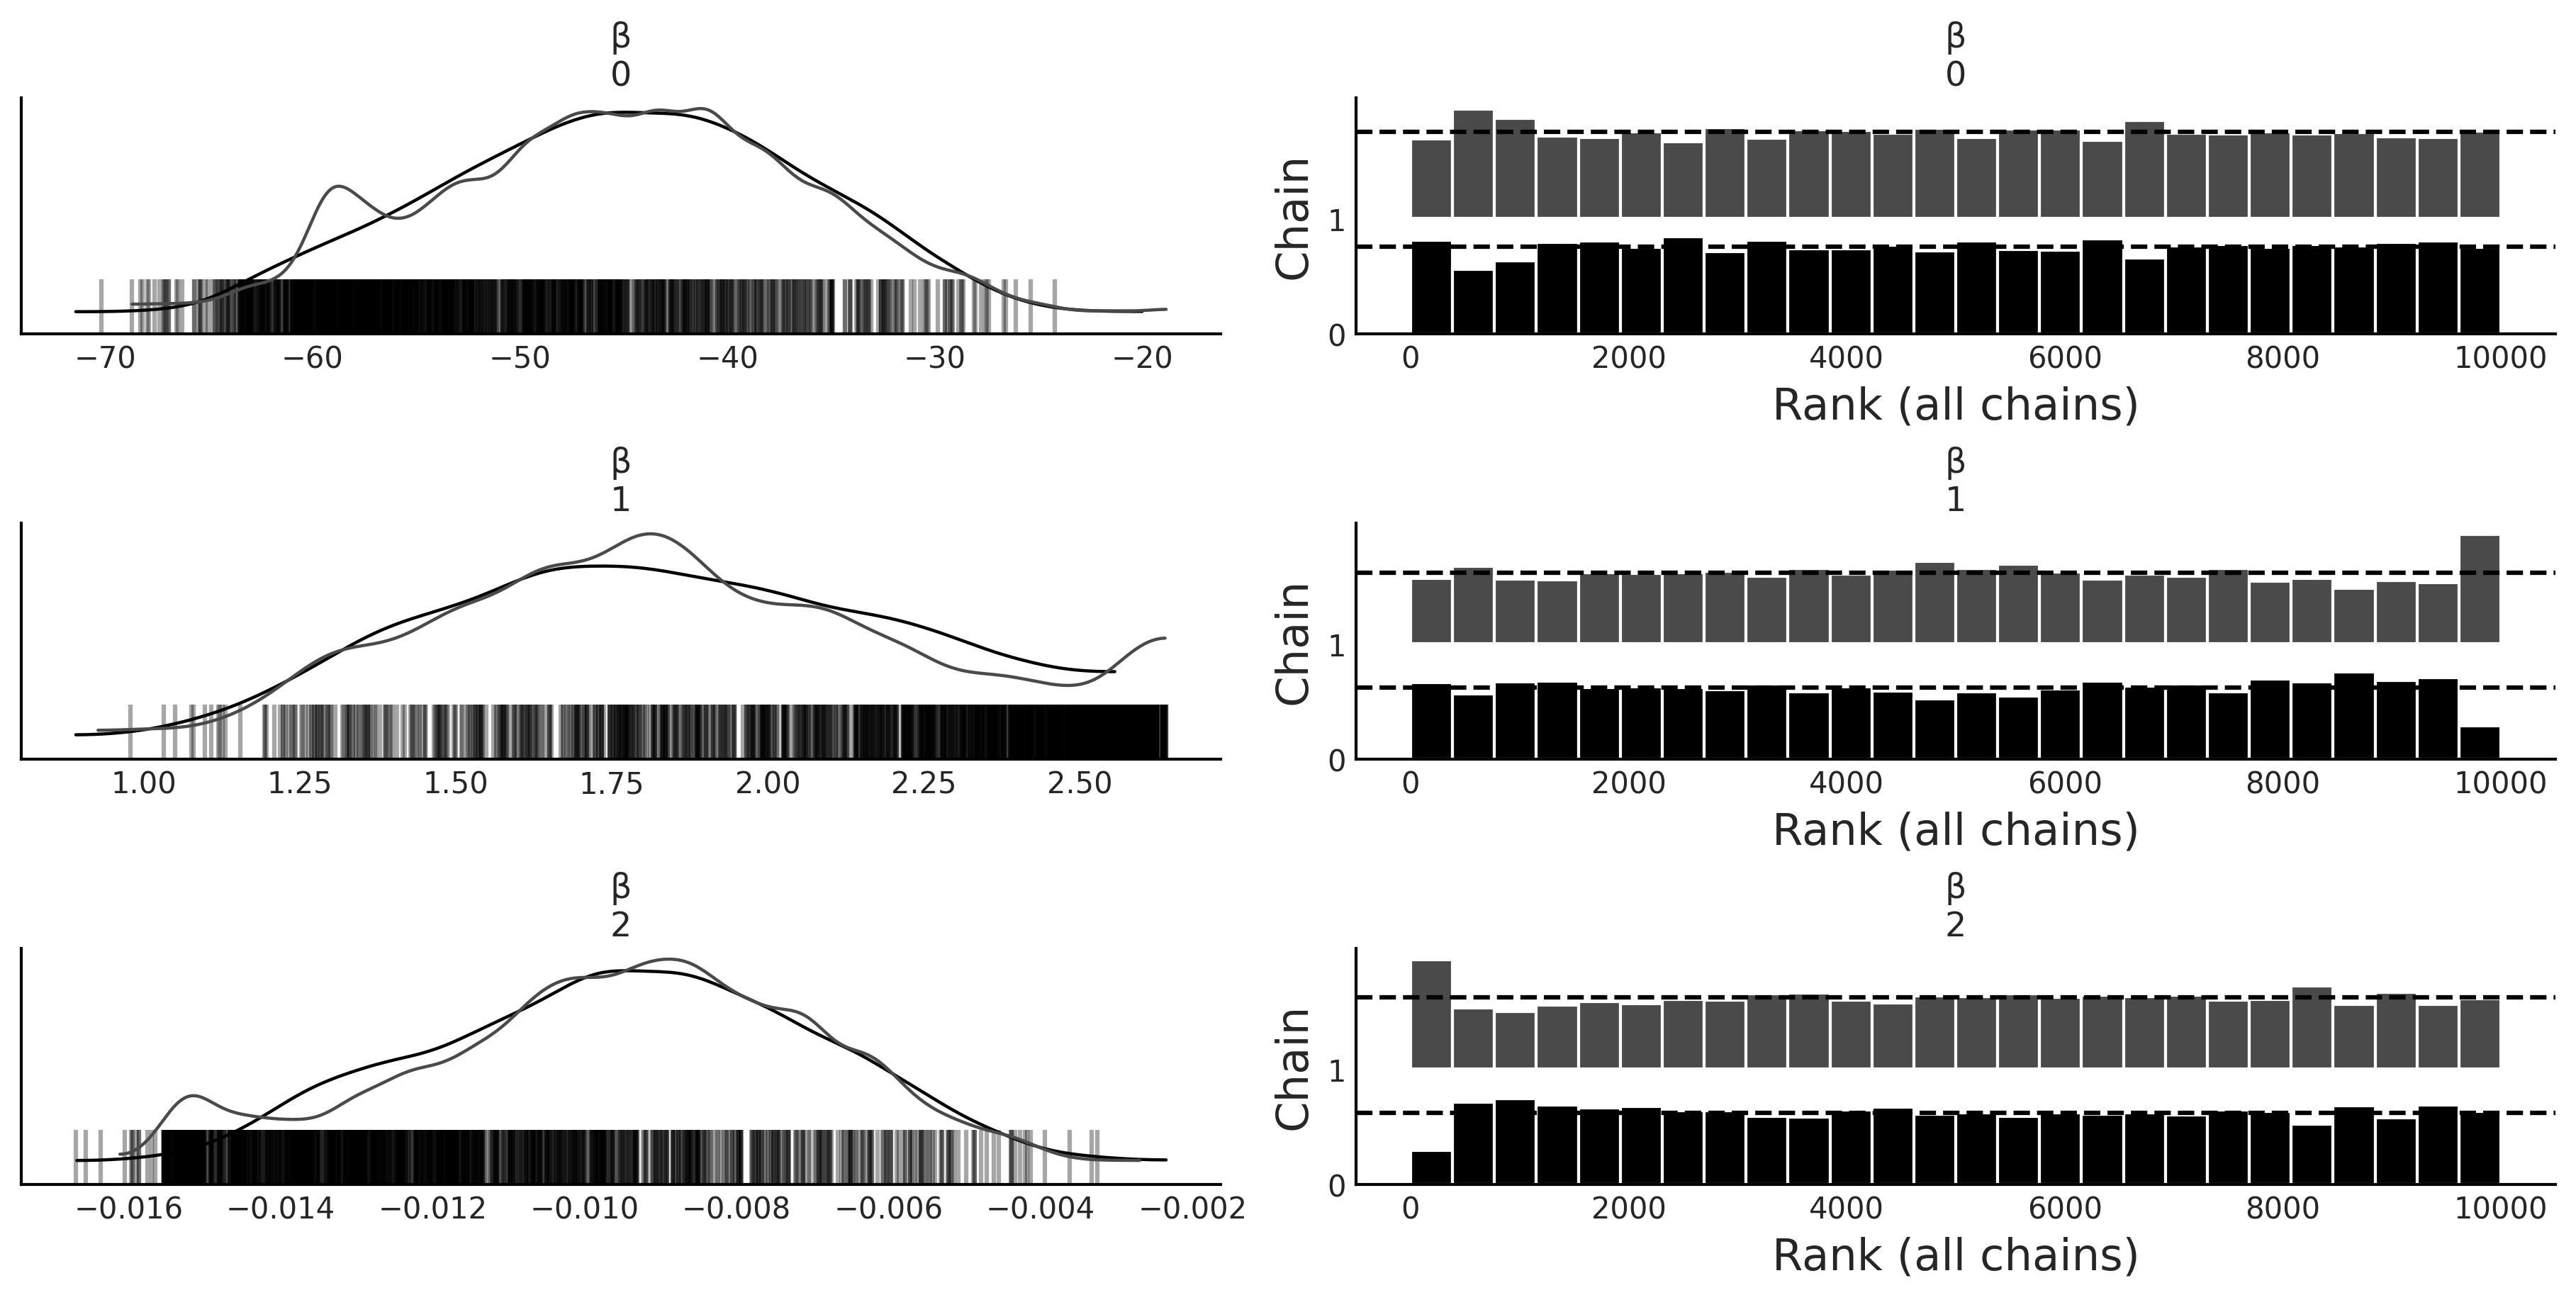

In [62]:
az.plot_trace(idata_logistic_penguins_bill_length_mass, compact=False, var_names=["β"], kind="rank_bars");

In [63]:
az.summary(idata_logistic_penguins_bill_length_mass, var_names=["β"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0] -45.266  8.614 -60.930  -29.800      0.386    0.296     536.0    1230.0   
β[1]   1.839  0.361   1.223    2.538      0.021    0.017     233.0      78.0   
β[2]  -0.010  0.003  -0.015   -0.005      0.000    0.000     315.0      86.0   

      r_hat  
β[0]   1.01  
β[1]   1.01  
β[2]   1.01

### Figure 3.21

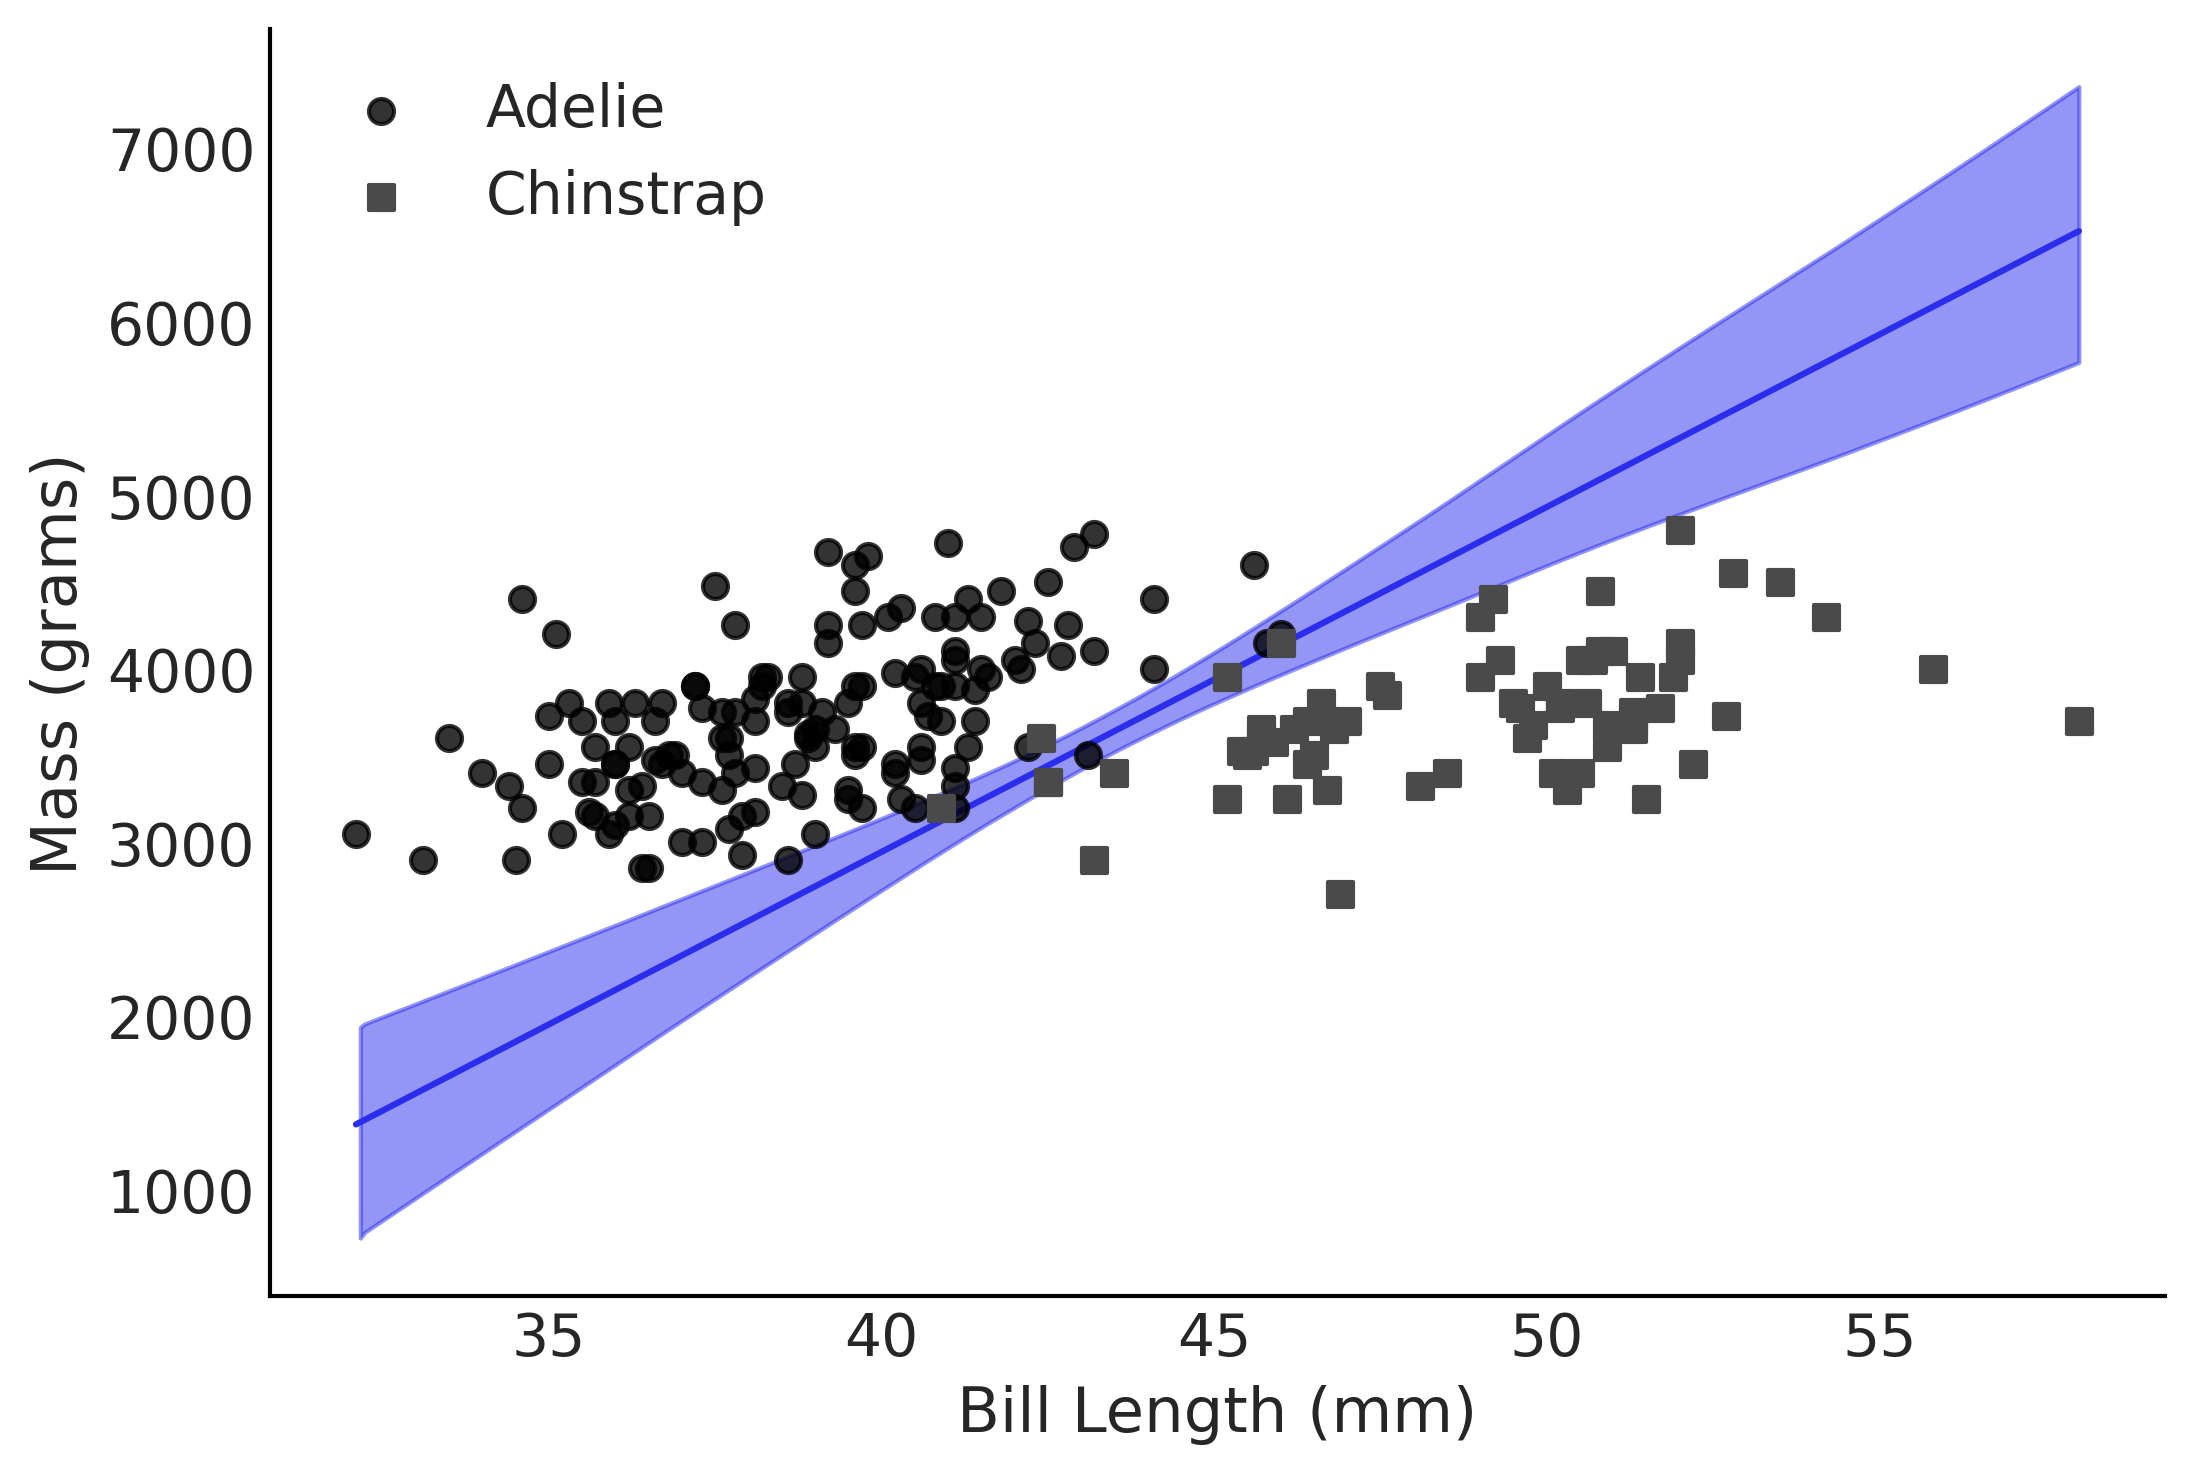

In [64]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1])
bd = idata_logistic_penguins_bill_length_mass.posterior["bd"].mean(("chain", "draw"))[idx]


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4');
az.plot_hdi(X[:,1], idata_logistic_penguins_bill_length_mass.posterior["bd"], color='C4', ax=ax)

# Scatter
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend()
plt.savefig("img/chp03/decision_boundary_logistic_mass_bill_length.png");

### Code 3.26

In [65]:
az.compare({"mass": idata_logistic_penguins_mass,
            "bill": idata_logistic_penguins_bill_length,
            "mass_bill": idata_logistic_penguins_bill_length_mass}).round(1)

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of p

rank  elpd_loo  p_loo  elpd_diff  weight   se  dse  warning scale
mass_bill     0     -11.3    1.6        0.0     1.0  3.1  0.0     True   log
bill          1     -28.0    1.0       16.7     0.0  5.0  3.9    False   log
mass          2    -135.7    1.9      124.4     0.0  5.3  5.8    False   log

### Code 3.25

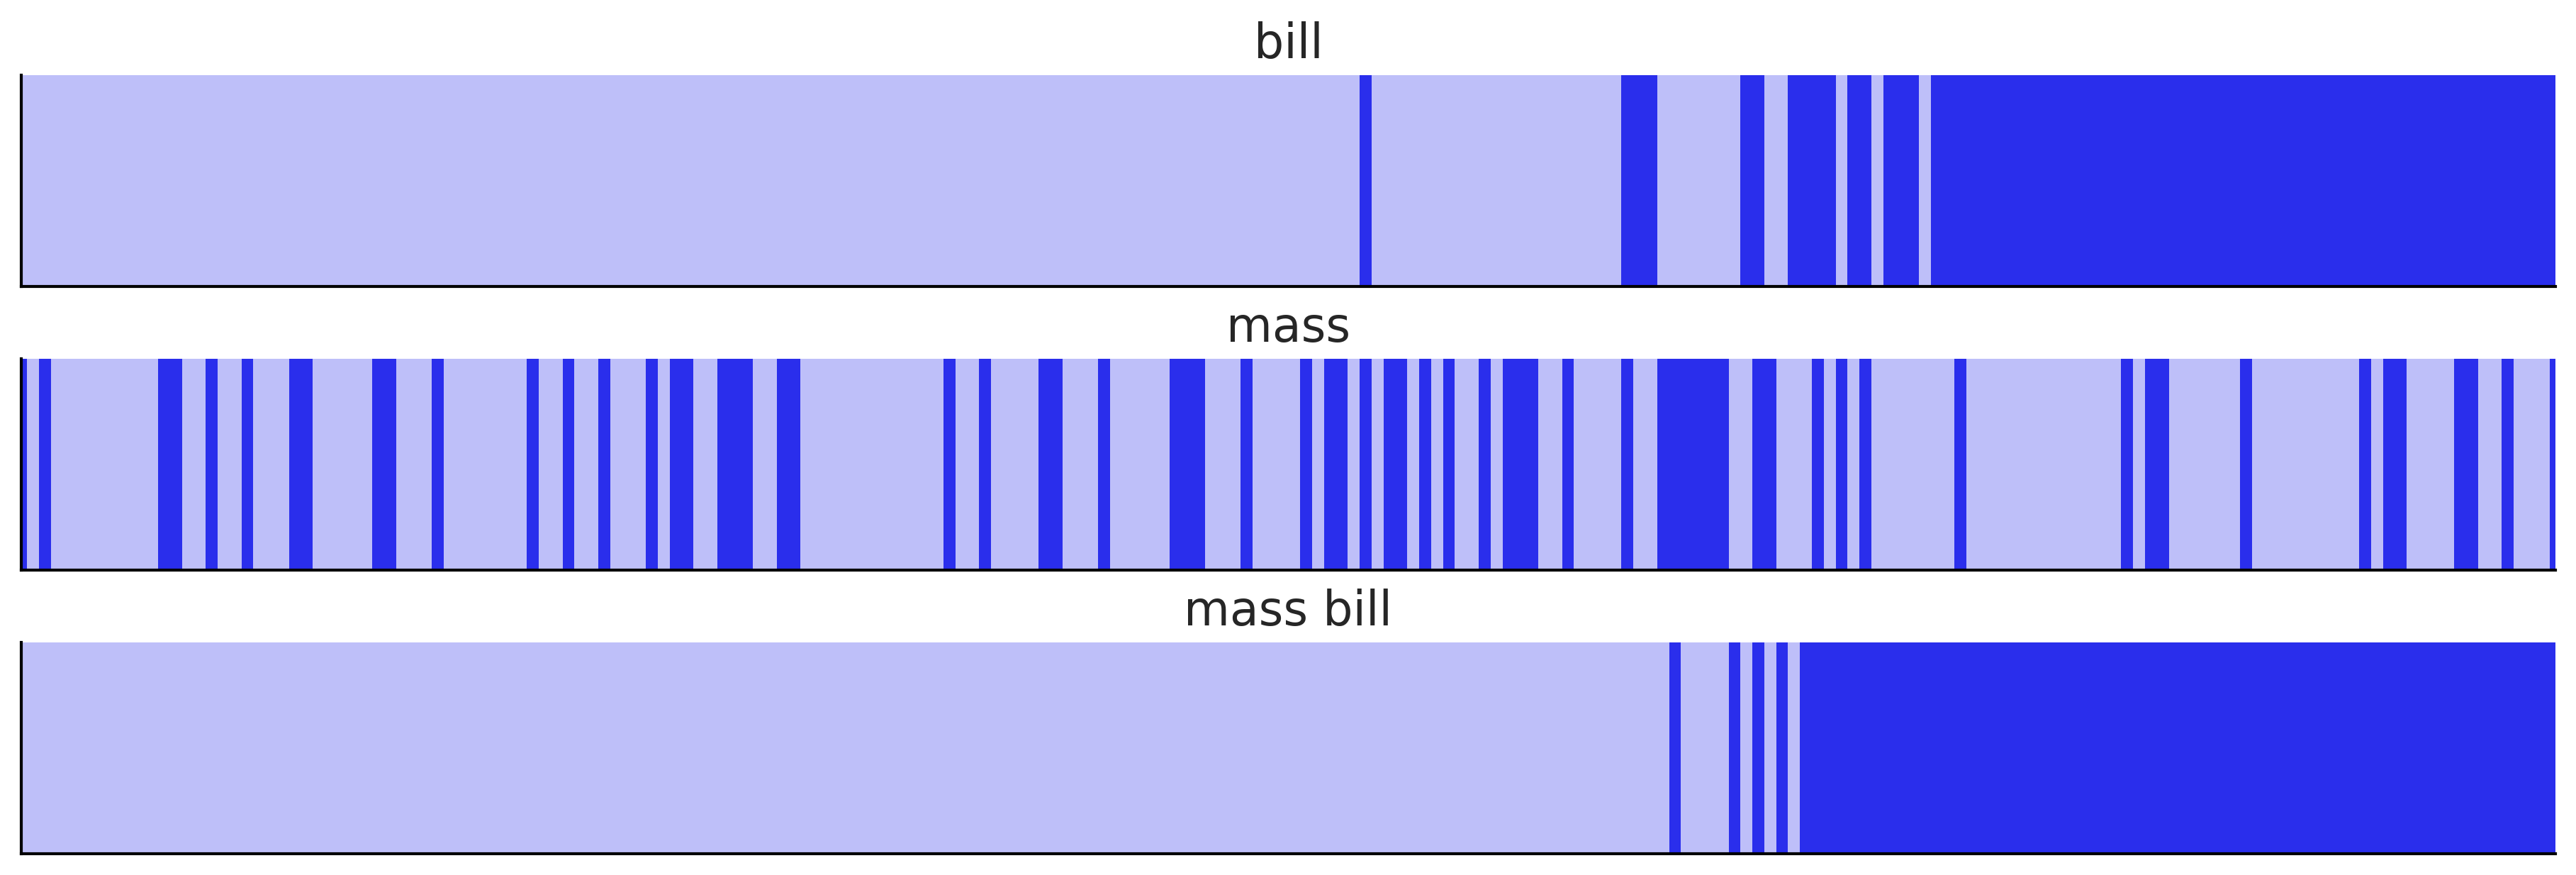

In [66]:
models = {"bill": idata_logistic_penguins_bill_length,
          "mass": idata_logistic_penguins_mass,
          "mass bill": idata_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)

plt.savefig("img/chp03/penguins_separation_plot.png")

### Code 3.27

In [67]:
penguins.loc[:,"species"].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

In [68]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count+chinstrap_count)

array([0.68224299])

### Code 3.28

In [69]:
adelie_count / chinstrap_count

array([2.14705882])

In [70]:
idata_logistic_penguins_bill_length.posterior["β_0"].mean().item()

-34.377071565966894

In [71]:
β_0 = idata_logistic_penguins_bill_length.posterior["β_0"].mean().item()
β_1 = idata_logistic_penguins_bill_length.posterior["β_1"].mean().item()

In [72]:
β_0

-34.377071565966894

In [73]:
β_1

0.7772435738075071

### Code 3.29

In [74]:
bill_length = 45
val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length+1)

f"Class Probability change from 45mm Bill Length to 46mm: {(special.expit(val_2) - special.expit(val_1))*100:.0f}%"

'Class Probability change from 45mm Bill Length to 46mm: 15%'

In [75]:
bill_length = np.array([30, 45])
val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length+1)

#f"Slope Change {(val_2 - val_1):.2f} Probability Change {(special.expit(val_2) - special.expit(val_1)):.2f}"

In [76]:
special.expit(val_2) - special.expit(val_1)

array([1.84924431e-05, 1.52967053e-01])

## Picking Priors in Regression Models

### Figure 3.23

In [77]:
x = np.arange(-2,3,1)
y = [50, 44, 50, 47, 56]

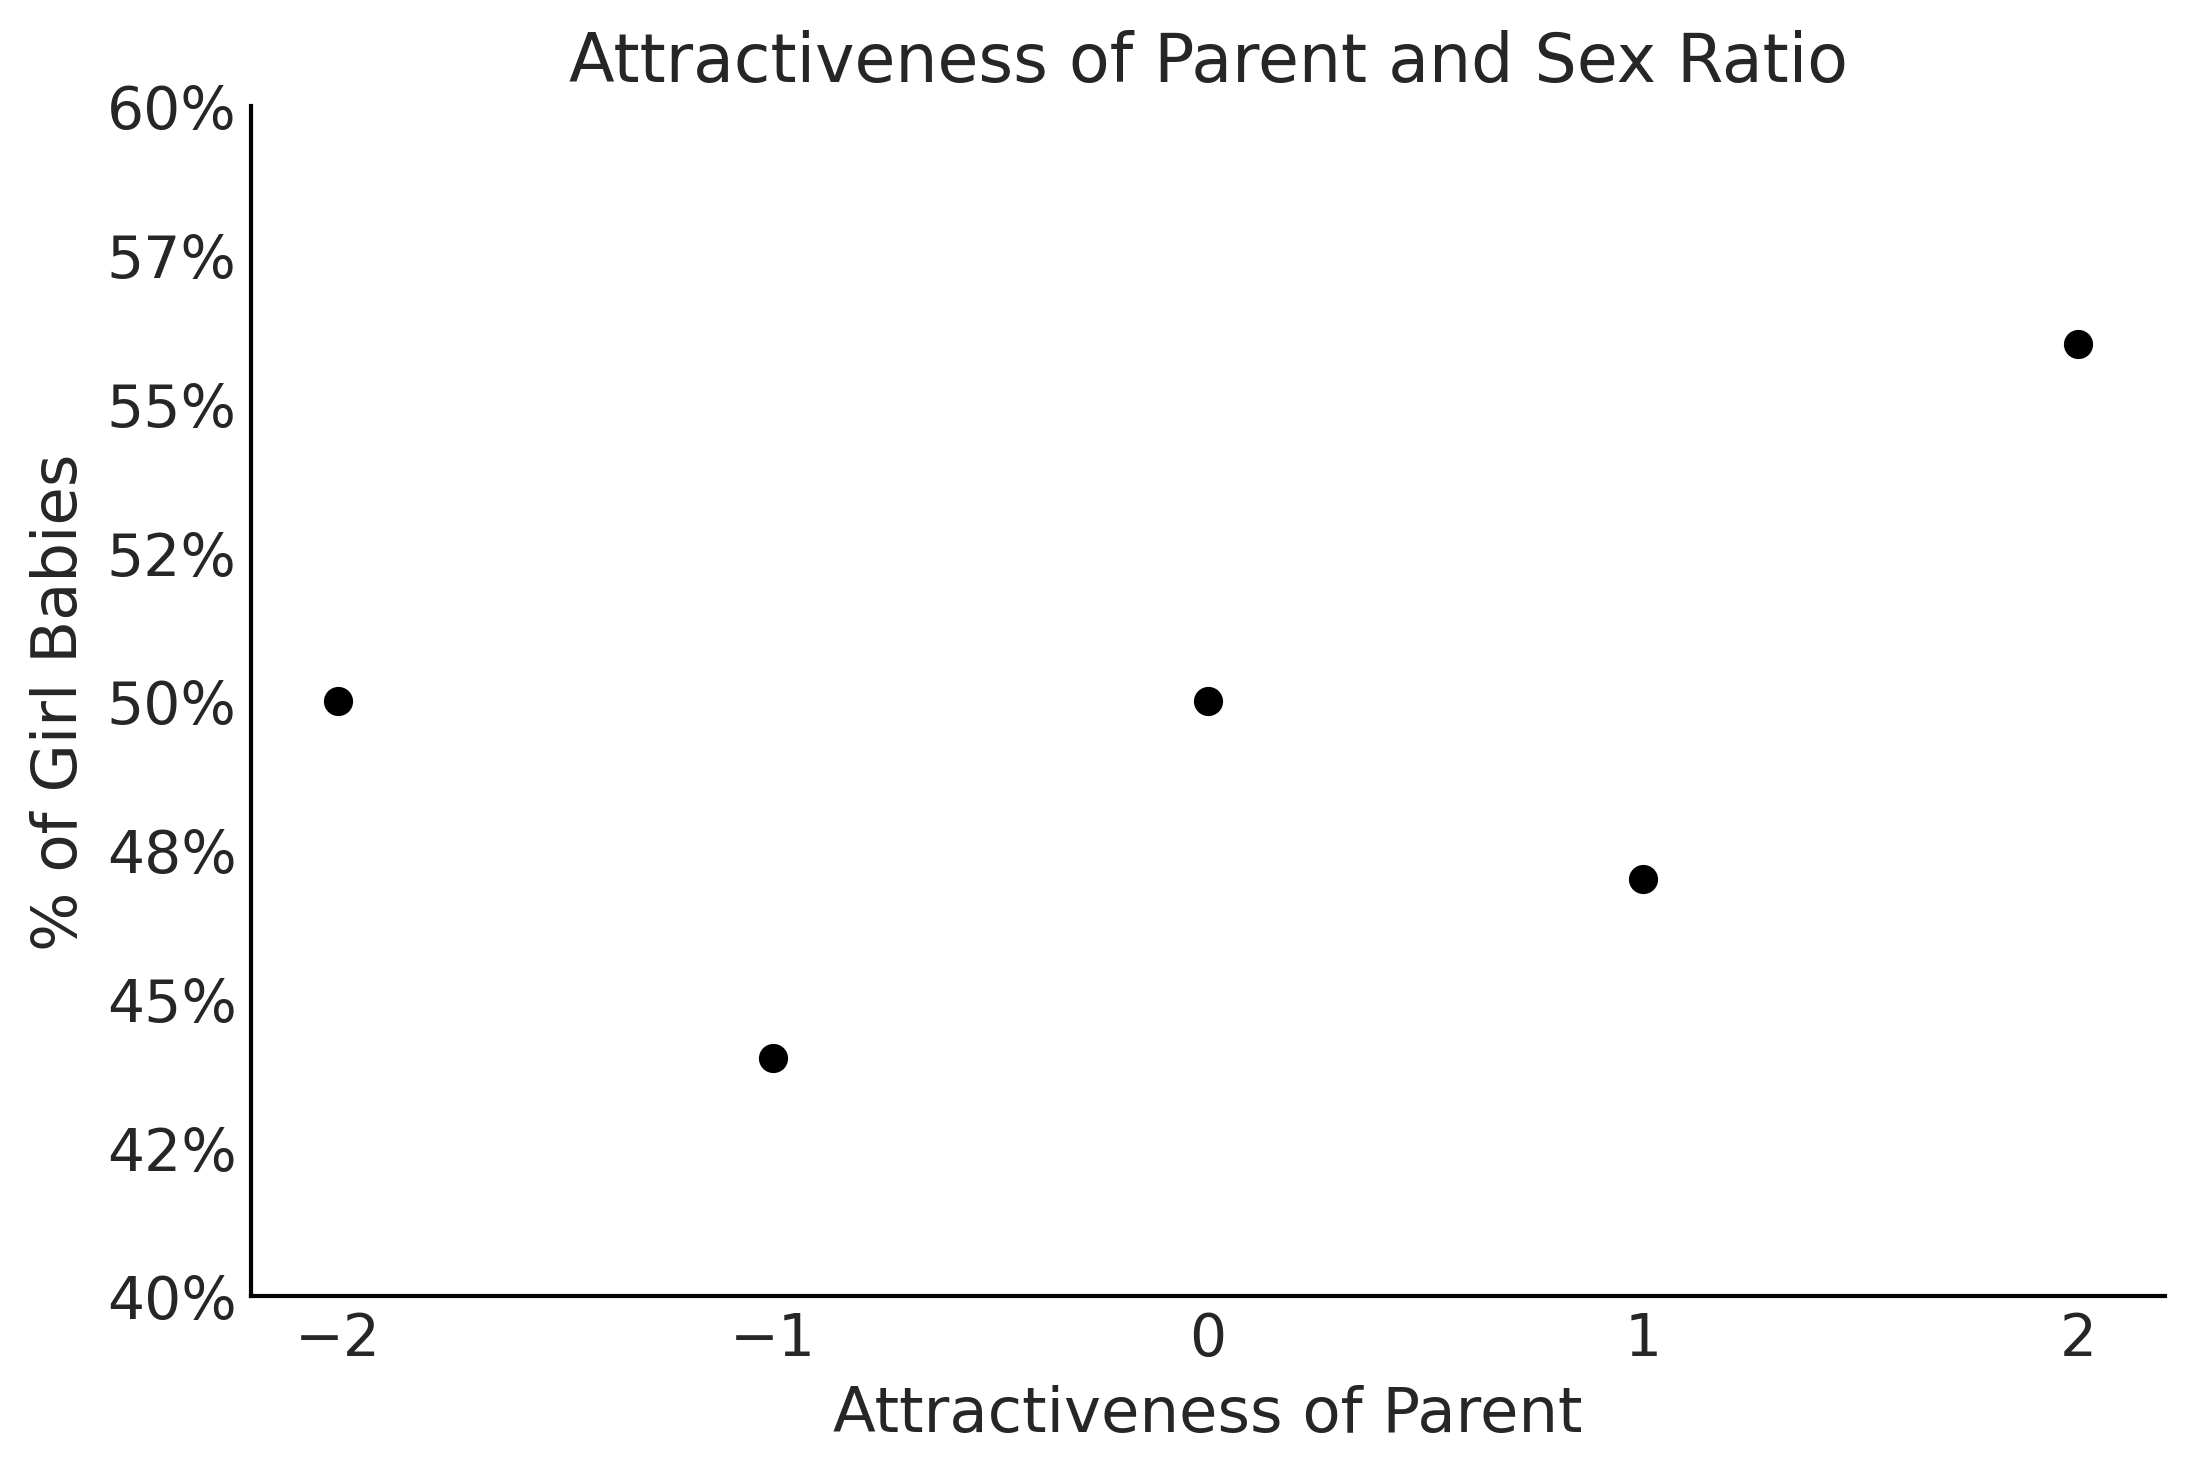

In [78]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xticks(x)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_ylim(40, 60)
ax.set_xlabel("Attractiveness of Parent")
ax.set_ylabel("% of Girl Babies")
ax.set_title("Attractiveness of Parent and Sex Ratio")
plt.savefig("img/chp03/beautyratio.png")

### Code 3.30

In [79]:
with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    idata_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
    idata_uninformative_prior_sex_ratio.extend(pm.sample_prior_predictive(samples=10000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [ratio, β_0, β_1, σ]


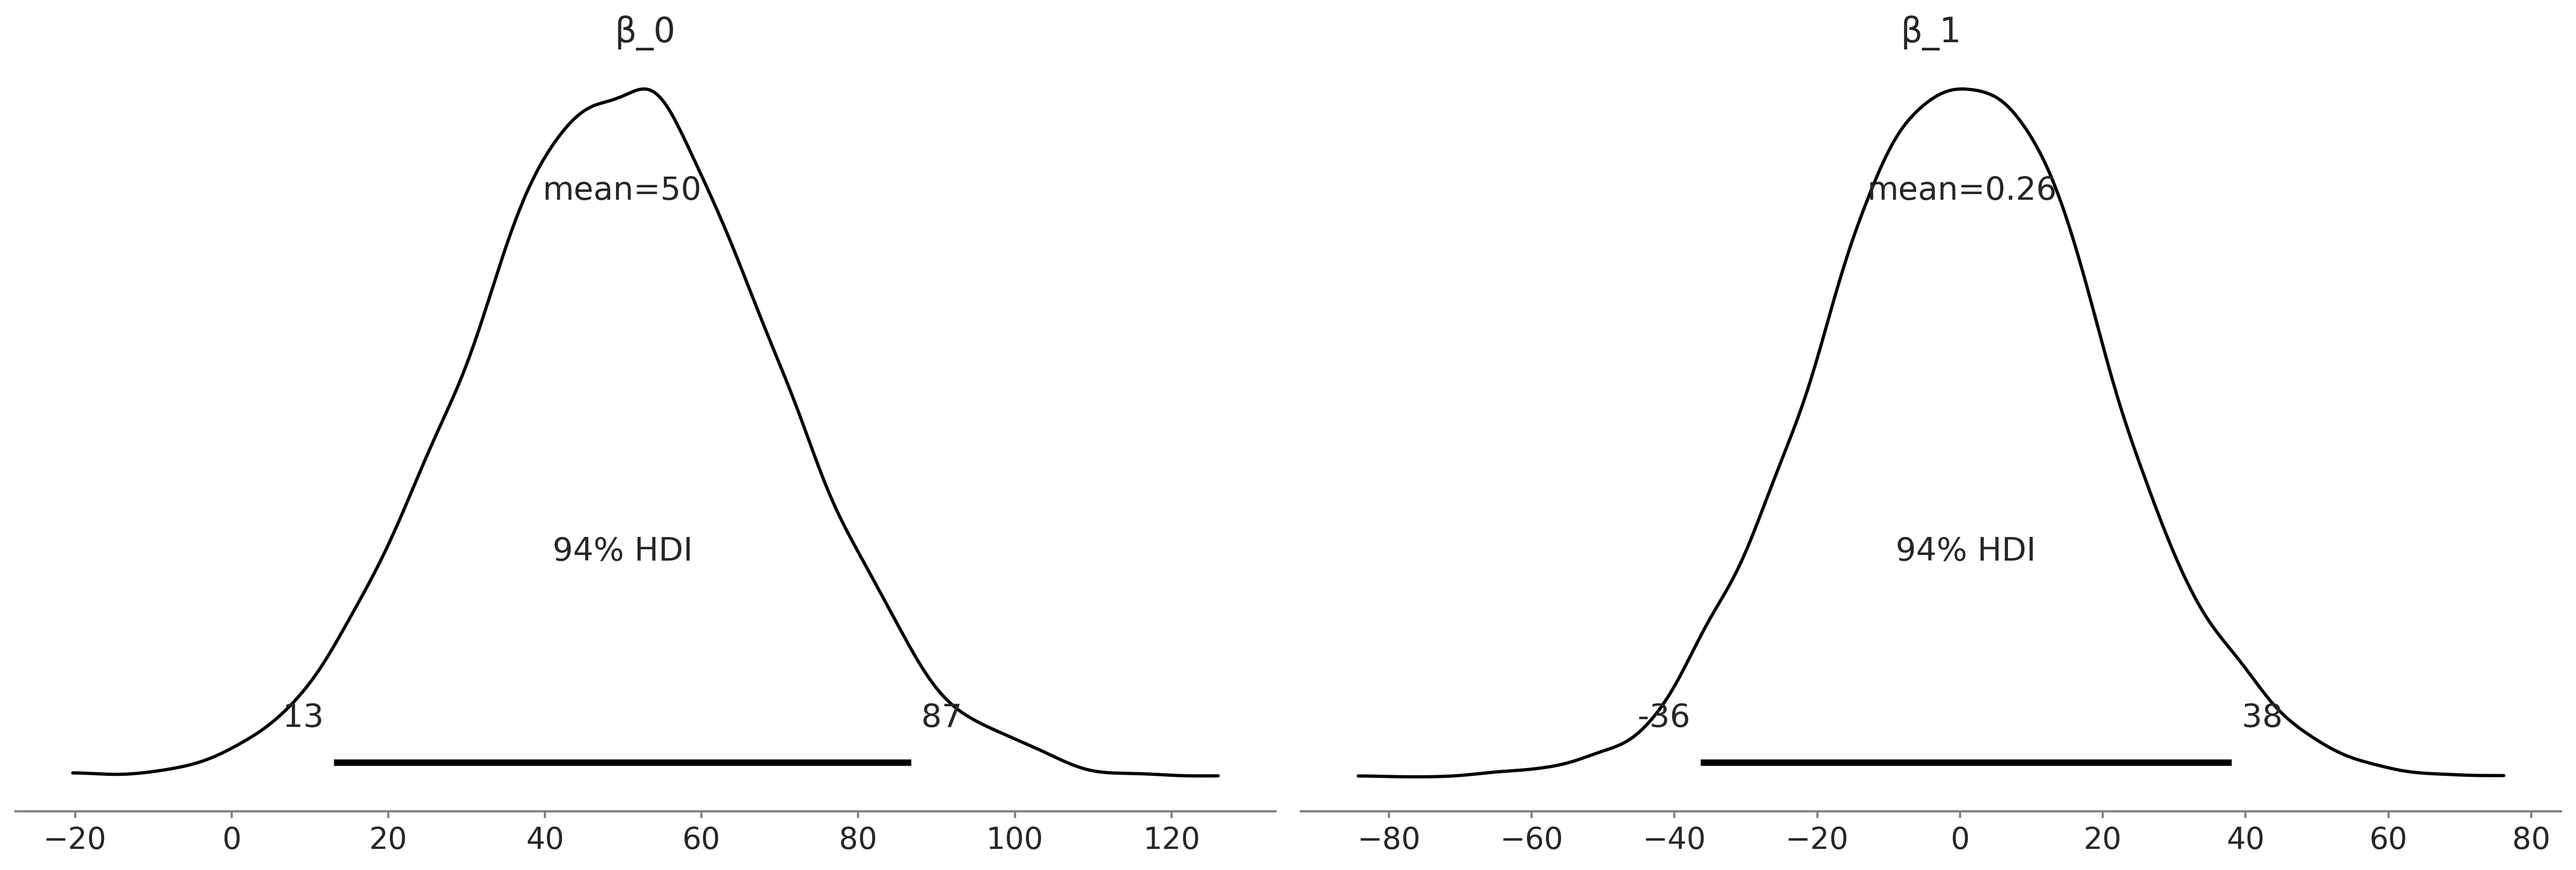

In [80]:
az.plot_posterior(idata_uninformative_prior_sex_ratio.prior, var_names=["β_0", "β_1"])
plt.savefig("img/chp03/priorpredictiveuninformativeKDE.png")

In [81]:
az.summary(idata_uninformative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  49.411  1.991  45.672   53.178
β_1   1.533  1.413  -1.068    4.401
σ     4.262  1.456   2.047    6.955

### Figure 3.24

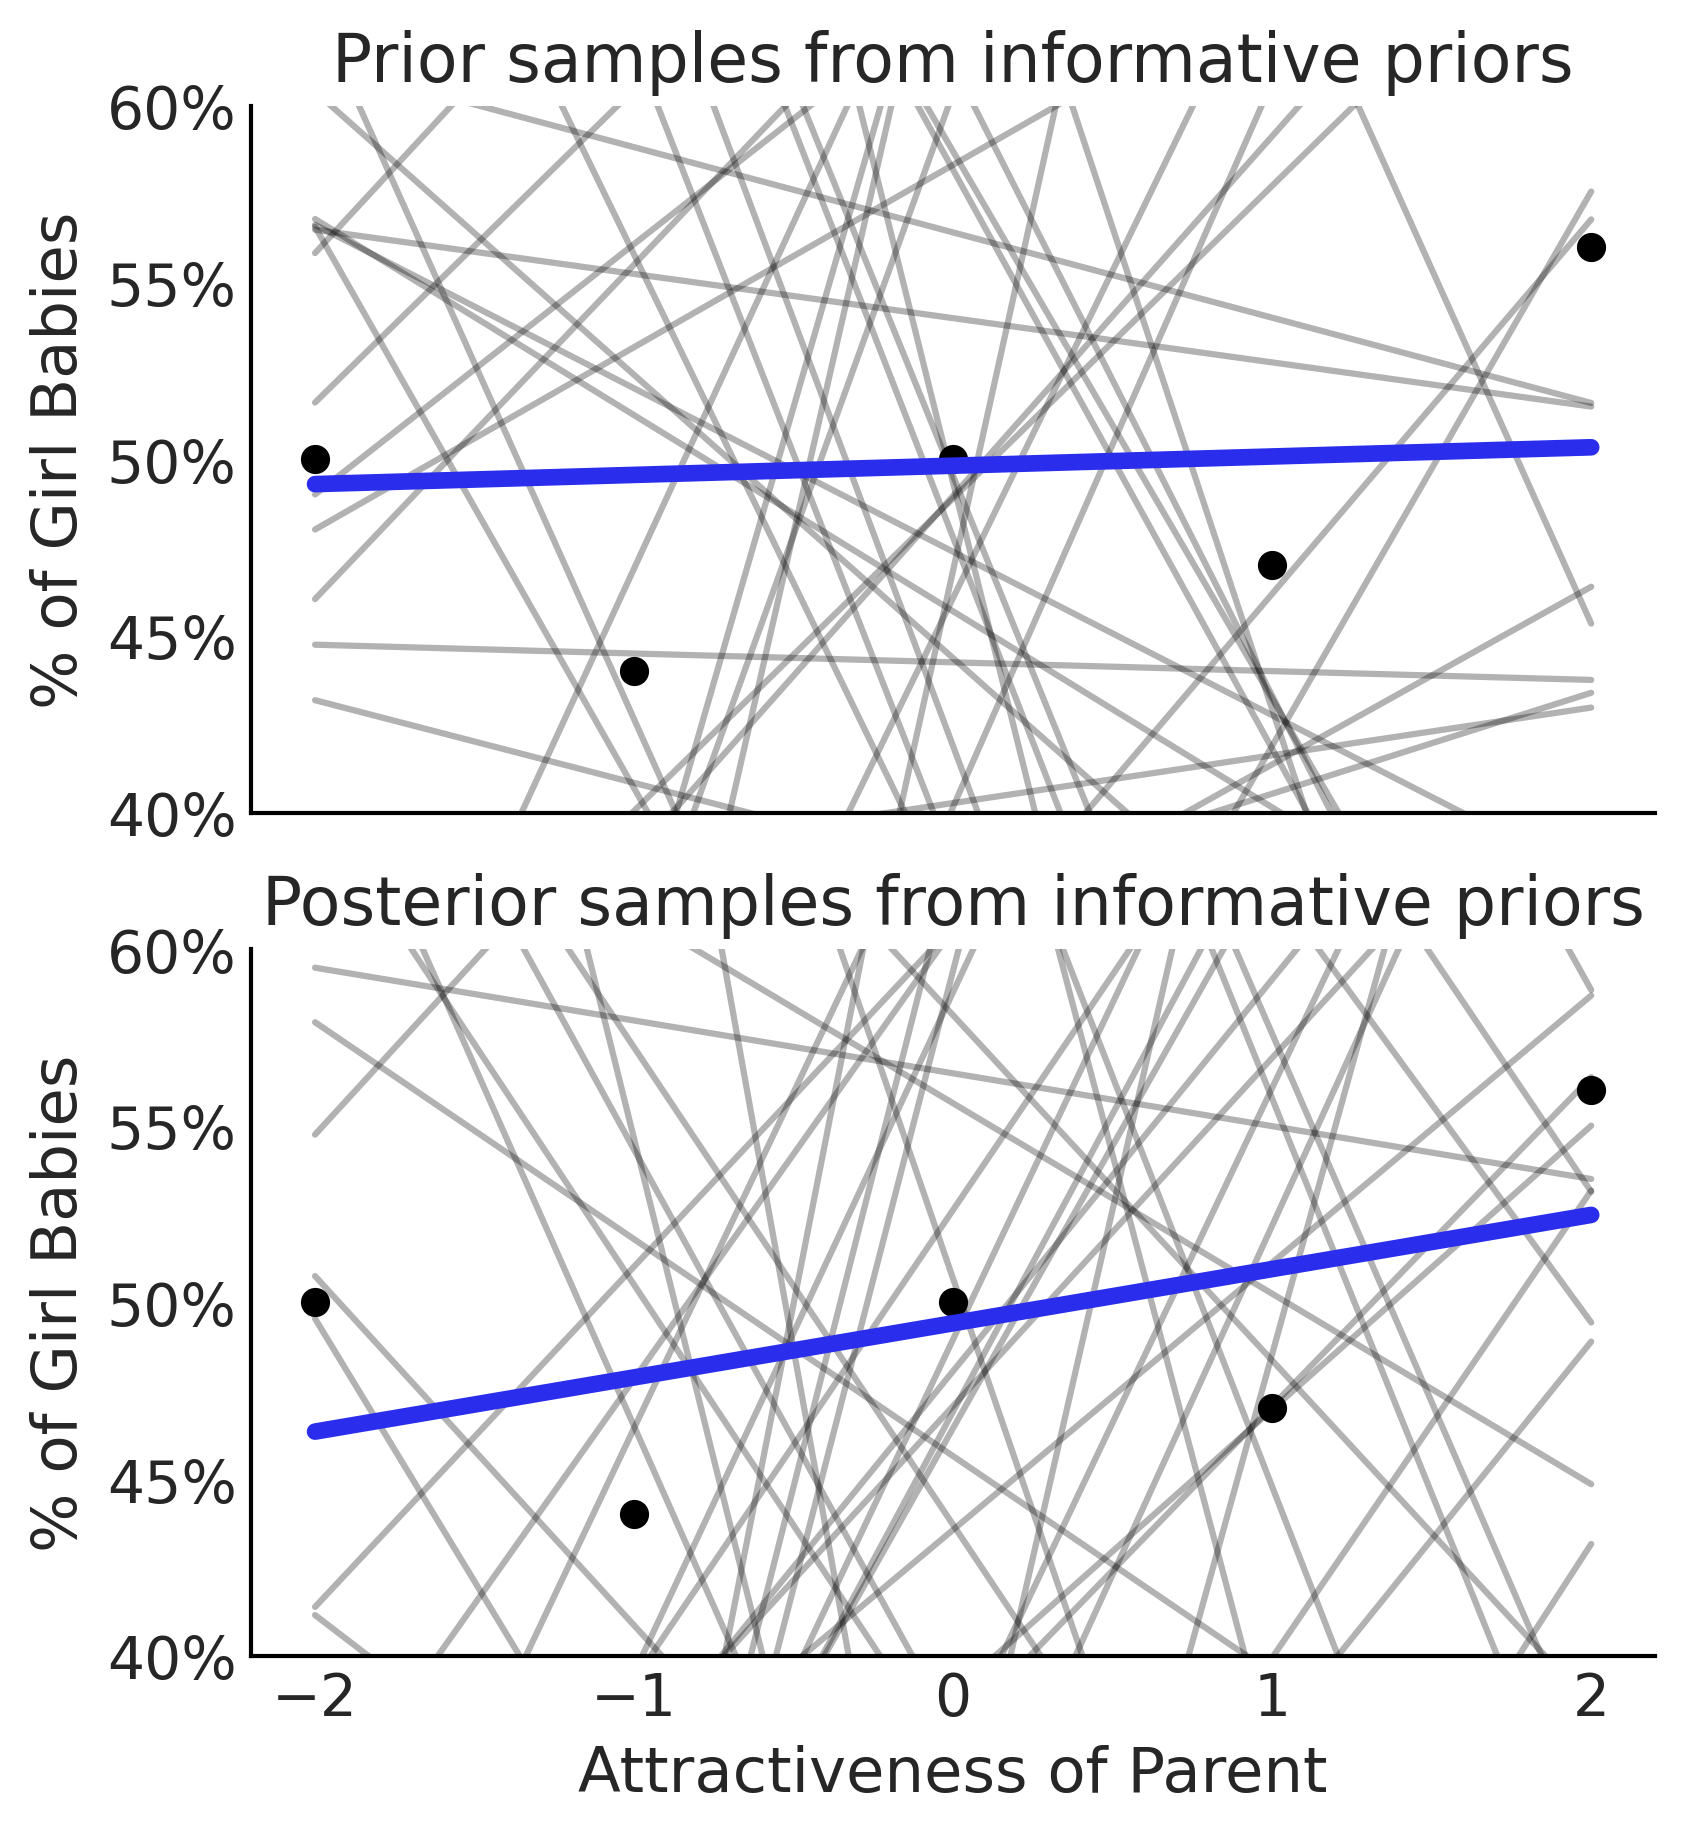

In [82]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 50 sample from the prior
num_samples = 50
subset = az.extract(idata_uninformative_prior_sex_ratio, group="prior", num_samples=50)

# Plot Line
axes[0].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_uninformative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = idata_uninformative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
subset = az.extract(idata_uninformative_prior_sex_ratio, group="prior", num_samples=50)

axes[1].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_uninformative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = idata_uninformative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")



plt.savefig("img/chp03/posterioruninformativelinearregression.png")

### Code 3.31

In [83]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    idata_informative_prior_sex_ratio = pm.sample(random_seed=0)
    idata_informative_prior_sex_ratio.extend(pm.sample_prior_predictive(samples=10000))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [ratio, β_0, β_1, σ]


In [84]:
az.summary(idata_informative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  48.565  0.486  47.661   49.475
β_1   0.240  0.465  -0.641    1.065
σ     4.045  1.246   2.140    6.395

### Figure 3.25

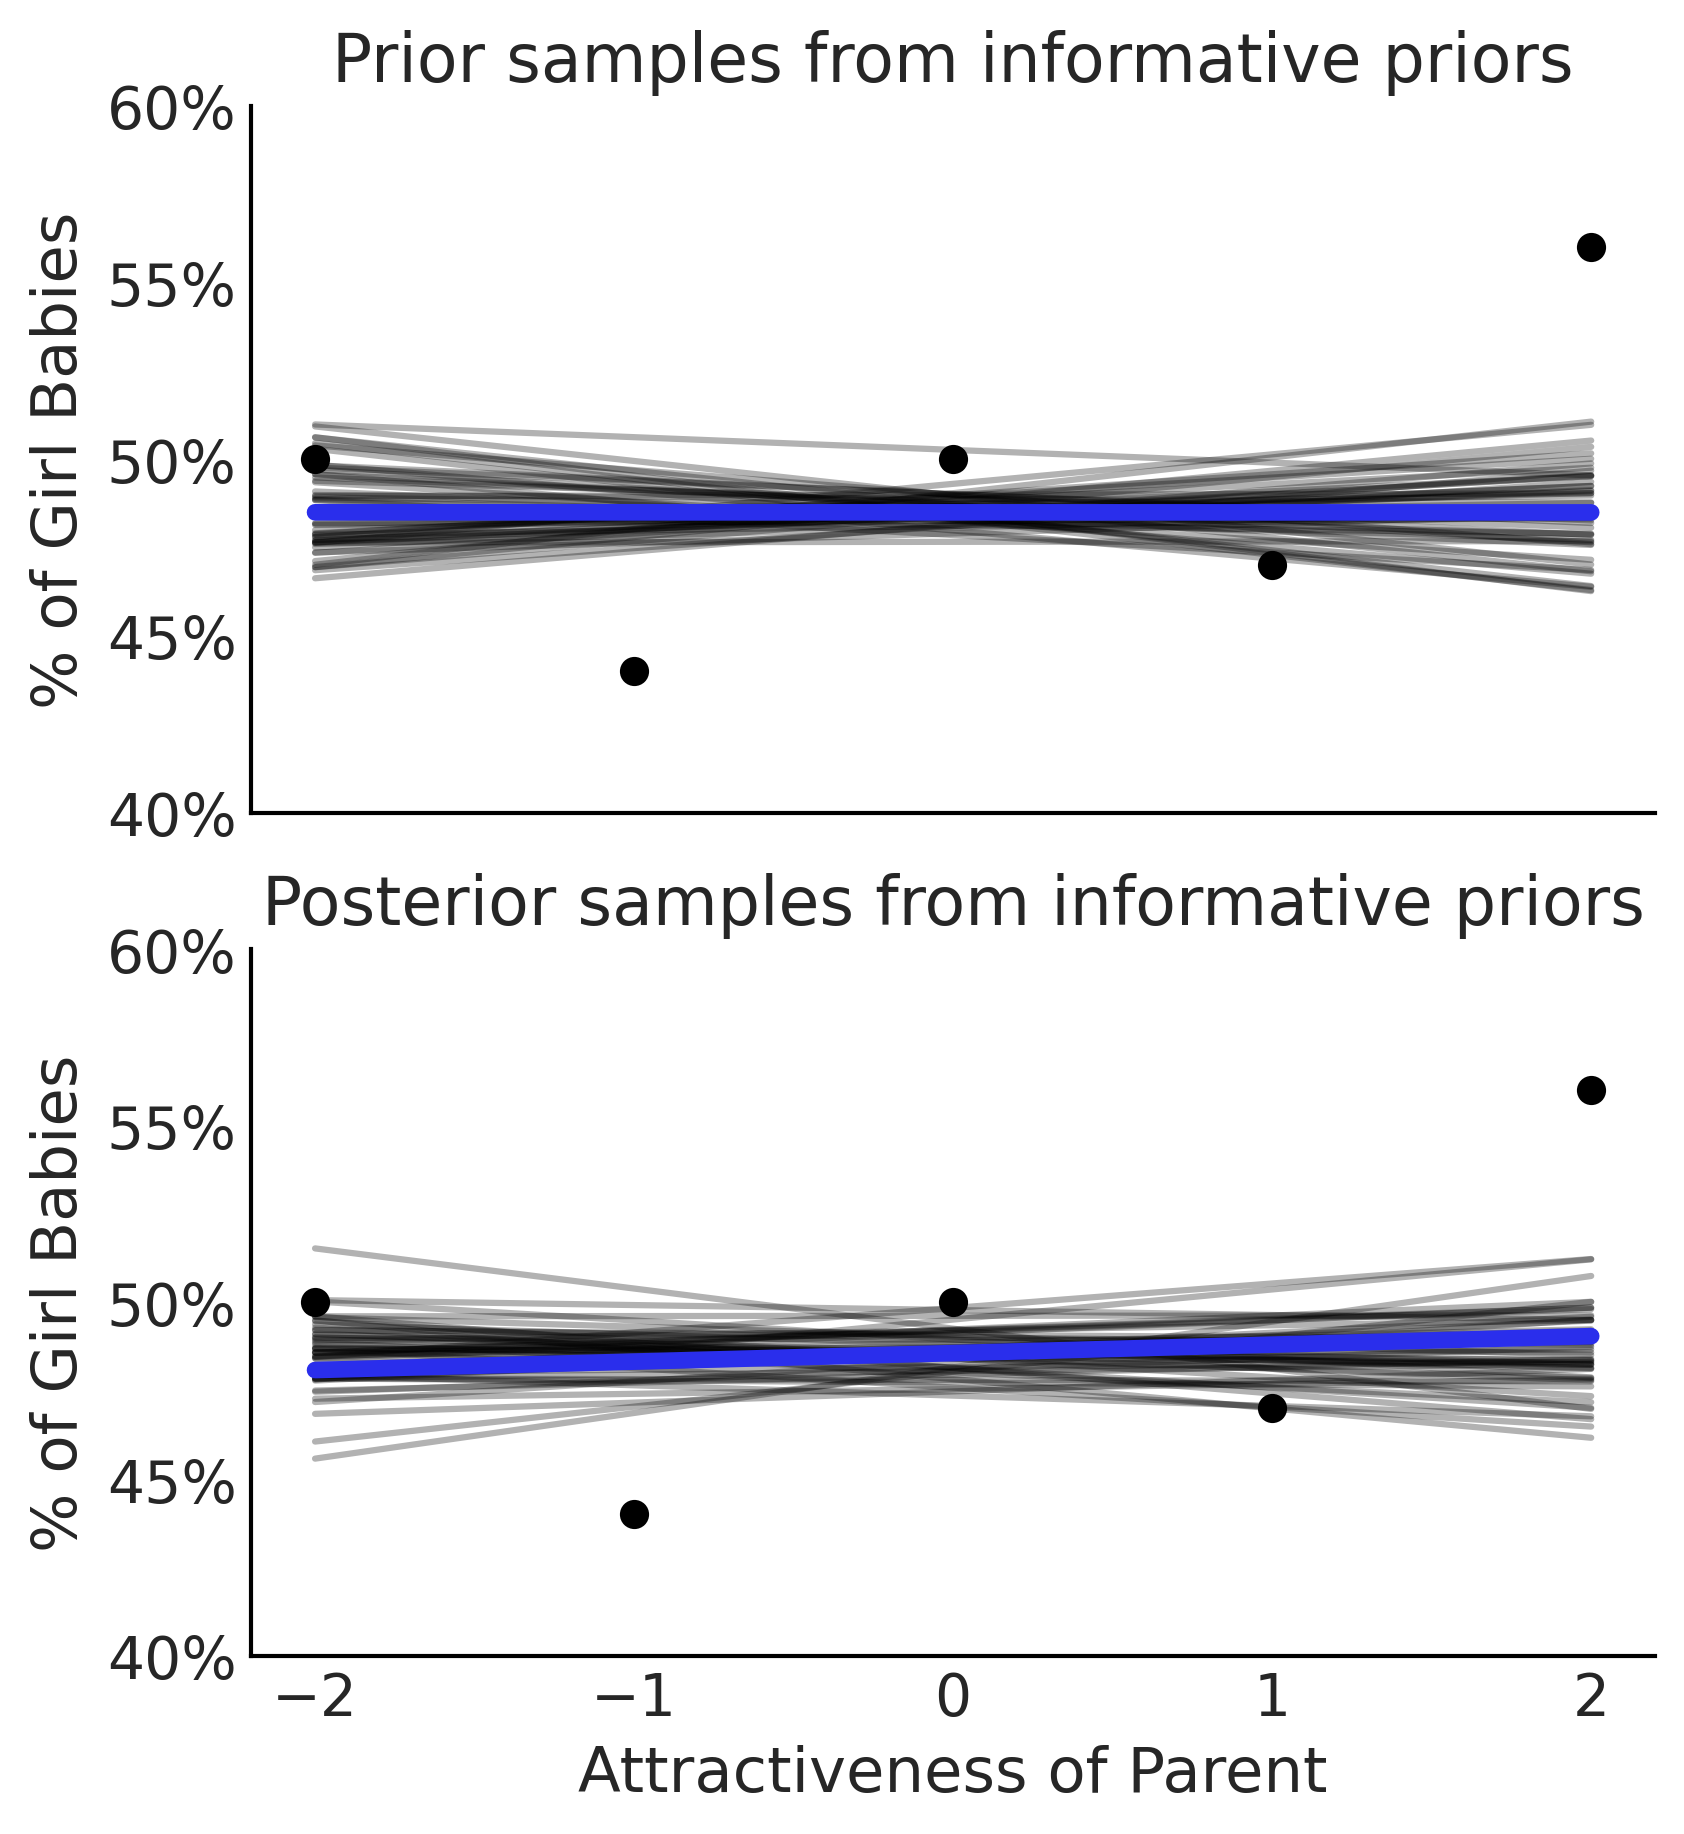

In [85]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 50 sample from the prior
num_samples = 50
subset = az.extract(idata_informative_prior_sex_ratio, group="prior", num_samples=50)

# Plot Line
axes[0].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_informative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = idata_informative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
subset = az.extract(idata_informative_prior_sex_ratio, group="prior", num_samples=50)

axes[1].plot(x, (subset["β_0"]+subset["β_1"]*xr.DataArray(x)).T, c="black", alpha=.3)

# Add median line later
b_0_hat = idata_informative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = idata_informative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="C4", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")


b_0_hat, b_1_hat
plt.savefig("img/chp03/posteriorinformativelinearregression.png")